TG-AI

# 진단검사 결과 검체뒤바뀜 오류 감지

세부 목표

1. Clinical Tabular DB 다루기

2. 진단검사 내 오류 감지 모델 개발

3. 하이퍼파라미터 튜닝

## 진단검사란

- 정의 : 인체에서 유래하는 각종 검체(혈액, 소변, 체액, 등)에 대한 적절한 검사로 질병 진단이나 치료효과 판정에 도움을 주는 검사

- 그림. 검사 순서

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/image1.png?raw=true)


- 진단검사 오류 ?

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/image3.png?raw=true)

- 문제점 (기존 방법 포함)

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/image2.png?raw=true)

- 그 중 샘플 뒤바뀜 오류 

    ![image-3.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/image-3.png?raw=true)



- 문제 해결 방안




## 튜토리얼 목차

튜토리얼은 **제시된 상황에서 문제 해결하는 방식**으로 진행됩니다.

## 문제 상황

### 배경
서울의 한 번창하던 병원에서 갑자기 수많은 환자들이 이틀에 걸쳐 몰렸습니다. 이 과정에서 **혈액 검체가 뒤바뀌는 사고**가 발생하며, 잘못된 진단과 치료로 인해 몇몇 환자는 심각한 부작용을 겪거나 생명을 잃는 비극적인 일이 벌어졌습니다. 

이 사고로 인해 병원의 신뢰도는 급격히 하락했고, 환자들은 다른 병원을 찾기 시작했습니다. 병원장은 이러한 상황을 지켜보며 극심한 스트레스와 우울증에 시달렸고, 기존 시스템으로는 문제를 해결할 수 없다는 것을 깨달았습니다. 병원은 문을 닫을 위기에 처하게 되었고, 병원장은 절망 끝에 생을 마감하려는 결심을 했습니다.

그러나, 그 순간 **신비로운 힘**에 의해 과거로 돌아갈 수 있는 기회를 얻게 되었습니다. 과거로 돌아온 병원장은 **AI(인공지능)**를 활용해 검체 뒤바뀜 문제를 근본적으로 해결하고 병원 시스템을 혁신하기로 결심했습니다.

---

### 목표
11종의 검사항목으로 구성된 검체들의 검사 결과에서 **뒤바뀐 검체를 식별하는 AI 모델을 개발**하는 것입니다.

#### 검사항목
- **Albumin**
- **ALP**
- **ALT**
- **AST**
- **BUN**
- **Creatinine**
- **GGT**
- **Glucose**
- **LDH**
- **Total Bilirubin**
- **Total Protein**

#### 상황
- 기간: **2024년 10월 29일 ~ 2024년 10월 31일**
- 문제: **검체 및 검사가 폭주**하며 원인 미상으로 검체 뒤바뀜 사고 발생.
- 목표: 뒤바뀐 검체를 정확히 찾아내는 **인공지능 모델 개발**.

---

## 데이터베이스

| 파일 이름            | 설명                                       |
|----------------------|--------------------------------------------|
| **development_set.csv** | 검증된 오류가 없는 데이터 (`error-free`).    |
| **test_set.csv**      | 검체 뒤바뀜 사고가 있는 데이터.             |
| **test_label.csv**    | 검체-정답으로 구성된 데이터 (`ground truth`).     |

---

## 평가 방법

### 기존 문제점
- 기존 방법은 검체 뒤바뀜 오류를 충분히 탐지하지 못함.
- 탐지한 오류조차 많은 오판을 포함함.

### 해결 목표
- **F1-score**가 가장 높은 인공지능 모델을 개발하여 오류 탐지 능력을 개선.

#### F1-score 정의
F1-score는 **Precision**과 **Recall**을 결합하여 계산됩니다:

\[\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}\]

- **Precision:** 탐지된 오류 중 실제 오류인 비율.
- **Recall:** 실제 오류 중 탐지된 오류의 비율.

F1-score를 통해 오류를 **더 많이, 더 정확히 탐지**할 수 있는지를 평가합니다.

---

## 평가 방법 및 데이터 형식 예시

### 테스트 라벨 (`test_label.csv`)
| 검체번호    | Label |
|-------------|-------|
| H8XGOUY1S   | 1     |
| VADI4FDVY   | 0     |
| X40XHJF6V   | 0     |
| ...         | ...   |

- **Label 설명:**
  - `1`: 검체 뒤바뀜 발생.
  - `0`: 검체 뒤바뀜 미발생.

- 최종 예측정보는 테스트 라벨과 같이 구성하여 evaluation_predictions(arg.)에서 평가바람.


In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')

In [268]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix

def evaluate_predictions(df_result):
    """
    Compare AI-generated predictions (df_result) with true labels (df_E_set)
    and print various evaluation metrics.
    
    Parameters:
        df_result (pd.DataFrame): AI-generated predictions with columns ['검체번호', 'Label'].
    """
    # for Evaluation 
    df_E_set=pd.read_csv('test_label.csv')
    display(df_E_set)
    
    merged_df = pd.merge(df_E_set, df_result, on='검체번호', suffixes=('_true', '_pred'))
    
    # 정답(Label_true)과 예측(Label_pred) 추출
    y_true = merged_df['Label_true']
    y_pred = merged_df['Label_pred']
    
    # 혼동 행렬 계산
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    # 평가 지표 계산
    f1 = f1_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
    
    # 결과 출력
    print(f"F1-score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"PPV (Precision): {ppv:.4f}")
    if f1 >= 0.8:
        print("🎉 비극적인 사고를 예방했습니다! 병원은 안전합니다.")
    elif f1 <= 0.5:
        print("💔 병원이 망했습니다. 더 나은 모델이 필요합니다.")
    else:
        print("⚠️ 모델 성능이 보통 수준입니다. 추가 개선이 필요합니다.")

## load data

In [269]:
import pandas as pd

# Development 
df_D_set = pd.read_csv('development_set.csv')
display(df_D_set)

,검체번호,검사일,환자번호,성별,나이,검사항목,결과,진료과,입원/외래
0,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,GGT,19,3ZU,입원
1,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Glucose,94,3ZU,입원
2,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Creatinine,3,3ZU,입원
3,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,AST,16,3ZU,입원
4,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Albumin,2.8,3ZU,입원
...,...,...,...,...,...,...,...,...,...
241694,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,LDH,245,D9S,외래
241695,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,Total Bilirubin,0.18,D9S,외래
241696,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,AST,21,D9S,외래
241697,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,ALT,15,D9S,외래


In [270]:
# test set
df_T_set=pd.read_csv('test_set.csv')
display(df_T_set)

,검체번호,검사일,환자번호,성별,나이,검사항목,결과,진료과,입원/외래
0,01JITNXLT,2024-10-29 11:26:47,3STQ71Z,F,51,Albumin,4,D9S,입원
1,01JITNXLT,2024-10-29 11:26:47,3STQ71Z,F,51,Glucose,100,D9S,입원
2,01JITNXLT,2024-10-29 11:26:47,3STQ71Z,F,51,AST,97,D9S,입원
3,01JITNXLT,2024-10-29 11:26:47,3STQ71Z,F,51,Total Protein,6.6,D9S,입원
4,01JITNXLT,2024-10-29 11:26:47,3STQ71Z,F,51,Total Bilirubin,0.59,D9S,입원
...,...,...,...,...,...,...,...,...,...
7652,ZZIGZ7YFN,2024-10-30 14:17:44,8N76BKB,F,76,Total Protein,7.4,D9S,입원
7653,ZZIGZ7YFN,2024-10-30 14:17:44,8N76BKB,F,76,ALT,22,D9S,입원
7654,ZZIGZ7YFN,2024-10-30 14:17:44,8N76BKB,F,76,Albumin,4.5,D9S,입원
7655,ZZIGZ7YFN,2024-10-30 14:17:44,8N76BKB,F,76,LDH,484,D9S,입원


# 입력데이터 구성을 위한 피벗팅

In [271]:
# 1. 데이터 피벗팅 (pivot_table)
df_pivot = df_D_set.pivot_table(
    index=['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래'],  # 고정할 인덱스 열
    columns='검사항목',  # 피벗팅할 열
    values='결과',  # 피벗된 열의 값으로 사용할 데이터
    aggfunc='first'  # 중복된 값이 있을 경우 첫 번째 값 사용
).reset_index()  # 결과를 데이터프레임으로 반환
display(df_pivot)  # 피벗 결과 확인

# 2. '환자번호'와 '검사일' 기준으로 데이터 정렬
df_pivot.sort_values(['환자번호', '검사일'], inplace=True)

# 3. '환자번호' 기준으로 그룹화
grouped = df_pivot.groupby('환자번호')

# 4. 그룹 내에서 이전 행 데이터를 가져옴
previous_results = grouped.shift(1)  # 각 그룹의 이전 행을 가져옴
previous_results.columns = ['prev_' + str(col) for col in previous_results.columns]  # 열 이름에 'prev_' 접두사 추가

# 5. 현재 결과(df_pivot)와 이전 결과(previous_results)를 합침
final_df = pd.concat([df_pivot, previous_results], axis=1).reset_index(drop=True)  # 두 데이터프레임을 열 방향으로 합침

# 6. 결측치 제거 (이전 결과가 없는 첫 행 등)
df_input = final_df.dropna()  # NaN이 포함된 행 제거
display(df_input)  # 최종 데이터프레임 확인

# 7. 최종 데이터프레임의 열 이름 출력
print(df_input.columns)

검사항목,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,Albumin,BUN,Creatinine,GGT,Glucose,LDH,Total Bilirubin,Total Protein
0,001DTNY7L,2021-09-08 09:13:07,9HEUF99,M,40,D9S,외래,68,13,21,4.7,6.5,0.9,21,97,268,0.72,7.4
1,001JX9J2L,2024-01-04 23:12:05,ZYJFPVK,F,37,MNI,외래,67,18,31,4.5,9.3,0.6,10,88,155,0.52,6.8
2,003M08XZH,2024-10-05 18:50:59,89DER5N,M,61,3ZU,입원,81,17,15,3.1,6.9,0.4,55,93,274,1.03,6.7
3,004PN9OS8,2024-11-01 23:44:44,11JX8YC,F,47,MS0,입원,54,20,22,4.1,15.3,0.4,19,95,326,0.31,7
4,009CL402Z,2024-11-01 00:21:06,ZK33CA6,F,89,D9S,외래,102,130,294,4.3,43.9,1.7,107,226,482,1.52,7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21965,ZZNM0D4KF,2022-09-12 22:28:00,AHR4G1K,M,56,K5S,외래,60,22,17,5,12.9,1,28,121,157,0.8,7.4
21966,ZZOX5O5H3,2024-10-08 14:50:02,SU70K7G,F,29,D9S,입원,132,2317,1842,4.9,8.3,0.6,1013,129,2725,8.82,8.4
21967,ZZW5ACAVI,2024-09-07 23:36:39,IC4J9KZ,F,59,D9S,외래,353,758,1234,4.6,7.3,0.5,825,115,998,2.32,6.7
21968,ZZWPT2EU4,2024-10-17 07:41:00,41OC0JM,M,2,Y92,입원,180,26,65,4.5,11.6,0.3,12,99,771,0.44,7.1


,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
1,EVE6NNR3L,2024-09-13 23:21:23,000T8NY,M,66,D9S,외래,118,191,236,...,17,21,3.1,20.4,1.2,23,113,260,0.95,6.3
3,506HFY625,2024-09-10 23:37:06,006A2VZ,F,19,D9S,입원,60,13,20,...,13,20,4.7,13.2,0.6,17,101,309,0.34,7.2
5,FJNPE148M,2024-10-28 23:10:04,00D2LN5,F,1,Y92,입원,283,28,32,...,25,37,4.5,23,0.3,7,91,725,0.19,6.3
7,GSLO14AW0,2024-09-25 23:58:50,00GAI20,M,47,YQV,입원,173,437,212,...,393,823,4.1,17.1,0.7,923,142,1367,1.6,6.8
8,DLJ2OU5HJ,2024-10-09 23:25:50,00GAI20,M,47,YQV,입원,95,25,22,...,437,212,4.1,9.6,0.7,842,112,626,1.35,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,XVBH25YNQ,2024-10-25 00:02:23,ZYWX4N9,M,41,MNI,외래,71,31,30,...,32,31,5.5,17.3,0.8,54,75,258,1.62,9.2
21964,D8PWEANPI,2023-10-10 22:57:49,ZZ006ZJ,M,77,K5S,외래,82,41,29,...,28,35,4,30.8,1.5,36,148,352,1.34,7.1
21965,G94WFQNCF,2024-10-14 23:54:34,ZZ006ZJ,M,78,K5S,외래,101,35,27,...,41,29,4.5,20.7,1.1,48,141,151,0.45,7
21967,YTVT6RVNM,2024-09-10 00:32:01,ZZMZWI3,M,35,D9S,외래,59,16,22,...,11,18,4.8,8.5,0.9,35,119,176,0.38,6.9


Index(['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래', 'ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein', 'prev_검체번호', 'prev_검사일', 'prev_성별',
       'prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein'],
      dtype='object')


In [272]:
# ---------------------------------------------------------------------
# df_T_set 피벗팅
final_df = []
df_pivot = df_T_set.pivot_table(
    index=['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래'],  # 고정할 인덱스 열
    columns='검사항목',  # 피벗팅할 열
    values='결과',  # 피벗된 열의 값으로 사용할 데이터
    aggfunc='first'  # 중복된 값이 있을 경우 첫 번째 값 사용
).reset_index()  # 결과를 데이터프레임으로 반환
display(df_pivot)  # 피벗 결과 확인
df_pivot.sort_values(['환자번호', '검사일'], inplace=True)
grouped = df_pivot.groupby('환자번호')
previous_results = grouped.shift(1)
previous_results.columns = ['prev_' + str(col) for col in previous_results.columns]  # 열 이름에 'prev_' 접두사 추가
final_df = pd.concat([df_pivot, previous_results], axis=1).reset_index(drop=True)  # 두 데이터프레임을 열 방향으로 합침
df_test = final_df.dropna()  

검사항목,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,Albumin,BUN,Creatinine,GGT,Glucose,LDH,Total Bilirubin,Total Protein
0,01JITNXLT,2024-10-29 11:26:47,3STQ71Z,F,51,D9S,입원,58,97,97,4,62.5,9.8,45,100,478,0.59,6.6
1,01LFHSY5W,2024-10-29 22:44:34,SRG3L4Q,F,69,A9N,입원,84,31,40,4.2,11.5,0.5,38,127,346,1.1,7
2,01QVN513W,2024-10-29 08:40:29,8ZEE3NY,M,66,YQV,입원,116,59,49,4,25.7,1,139,121,344,0.48,7.3
3,046PVR136,2024-10-29 20:42:27,F18M8R2,F,44,D9S,외래,47,14,14,4,8,0.7,12,124,186,0.22,6.7
4,04BORTAX9,2024-10-29 03:16:10,HN0E4TS,M,65,YQV,입원,110,232,736,4.1,20.2,1.2,417,101,464,4.53,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,ZUK3GULYJ,2024-10-31 23:33:30,OJ80SFI,M,47,YQV,입원,44,41,37,4.8,9.2,1,57,100,383,0.82,7.9
692,ZUP33JVZP,2024-10-30 23:58:53,553QFOU,M,72,R98,입원,55,32,42,3.9,24,1.5,32,138,395,0.62,6.7
693,ZVFPTXPPA,2024-10-31 20:24:02,SE1J8GP,F,66,D9S,입원,66,23,30,3.3,78.6,5.1,19,191,535,0.64,6.1
694,ZWU952BSU,2024-10-31 06:37:45,VSJ416F,F,79,D9S,외래,203,12,37,3.4,16.4,0.5,56,178,196,0.59,5.7


# 튜토리얼을 위한 데이터세트 생성 코드 (추후 편집 or 보관)

--------------------------------------- 2024/12/01 현황

- 데이터의 구조: 환자 --> 여러 검체 --> 여러 검사 결과 순으로 구성됨

- 검사결과들은 대부분 정규분포를 띄는점을 보여주기

## gen DB

- DB 구성 및 형태에 대해 제시
- 11월 1일을 제외한 데이터 만들기

In [273]:
df_raw = df_D_set.copy()

In [274]:
import pandas as pd

pivot_df = df_raw.pivot_table(index=['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래'],
                              columns='검사항목', 
                              values='결과',
                              aggfunc='first').reset_index()

# display(pivot_df)
pivot_df.sort_values(['환자번호', '검사일'], inplace=True)
grouped = pivot_df.groupby('환자번호')
previous_results = grouped.shift(1)
previous_results.columns = ['prev_' + str(col) for col in previous_results.columns]
final_df = pd.concat([pivot_df, previous_results], axis=1).reset_index(drop=True)
df_input=final_df.dropna()
display(df_input)

,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
1,EVE6NNR3L,2024-09-13 23:21:23,000T8NY,M,66,D9S,외래,118,191,236,...,17,21,3.1,20.4,1.2,23,113,260,0.95,6.3
3,506HFY625,2024-09-10 23:37:06,006A2VZ,F,19,D9S,입원,60,13,20,...,13,20,4.7,13.2,0.6,17,101,309,0.34,7.2
5,FJNPE148M,2024-10-28 23:10:04,00D2LN5,F,1,Y92,입원,283,28,32,...,25,37,4.5,23,0.3,7,91,725,0.19,6.3
7,GSLO14AW0,2024-09-25 23:58:50,00GAI20,M,47,YQV,입원,173,437,212,...,393,823,4.1,17.1,0.7,923,142,1367,1.6,6.8
8,DLJ2OU5HJ,2024-10-09 23:25:50,00GAI20,M,47,YQV,입원,95,25,22,...,437,212,4.1,9.6,0.7,842,112,626,1.35,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,XVBH25YNQ,2024-10-25 00:02:23,ZYWX4N9,M,41,MNI,외래,71,31,30,...,32,31,5.5,17.3,0.8,54,75,258,1.62,9.2
21964,D8PWEANPI,2023-10-10 22:57:49,ZZ006ZJ,M,77,K5S,외래,82,41,29,...,28,35,4,30.8,1.5,36,148,352,1.34,7.1
21965,G94WFQNCF,2024-10-14 23:54:34,ZZ006ZJ,M,78,K5S,외래,101,35,27,...,41,29,4.5,20.7,1.1,48,141,151,0.45,7
21967,YTVT6RVNM,2024-09-10 00:32:01,ZZMZWI3,M,35,D9S,외래,59,16,22,...,11,18,4.8,8.5,0.9,35,119,176,0.38,6.9


# Preprocessing + Encoding + simulation + Feature generation

![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/data_type.png?raw=true)

## Encoding
- 범주형 데이터를 숫자로 변환하여 알고리즙에 적합한 입력 형식으로 만드는 과정
- https://medium.com/aiskunks/categorical-data-encoding-techniques-d6296697a40f 참고

### Label Encoding : manual , auto (수치적인 설정에 따라 모델에서 예측성능이 달라질 수 있는점 강조)
- 범주형 데이터를 불연속적인 숫자 표현으로 변환

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Label_Encoding.png?raw=true)
- 할당된 정수가 정렬된 관계가 있는 것으로 잘못 해석될 수 있다는 단점이 있음
- 순서가 존재하는 Ordinal Data에 대해서는 효과적일 수 있음
    - 10대, 20대, 30대 ...

### One-Hot Encoding
- n개의 클래스로 구성된 변수를 n개의 이진 특성(열)로 변환
- 범주형 변수를 인코딩 하는 가장 일반적인 방법

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/One_Hot_Encoding.png?raw=true)

### Dummy Encoding
- One-Hot Encoding과 유사
- n개의 클래스로 구성된 변수를 n-1개의 이진 특성(열)로 변환

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Dummy_Encoding.png?raw=true)

### Binary Encoding
- one-Hot Encoding과 유사
- 각 범주에 대해 별도의 열을 만드는 대신 범주를 이진 숫자로 표시

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Binary_Encoding.png?raw=true)

### Count Encoding
- 데이터 세트에 나타나는 횟수를 계산하여 범주형 변수를 인코딩
- 동일한 빈도를 가지는 카테고리에 대해선 구분이 모호함

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Count_Encoding.png?raw=true)

### Target Encoding
- 높은 cardinality 변수에 적용할 수 있으며 Target을 활용해 Encoding하는 방법
- 각 범주의 평균 목표값이 계산되고 이 평균 값을 범주형 변수를 대체하는 곳에 사용
- Target과 변수 간 관계를 고려할 수 있는 장점이 있으나 과적합(Overfitting)으로 이어질 수 있다

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Target_Encoding.png?raw=true)
    - cardinality : 각 변수에 속한 유니크한 범주의 갯수
- Target Encoding과 비슷한 Summary Encoding이 존재
- Quantile Encoding으로도 알려져 있으며 평균 대신 분위수를 활용하여 드문 클래스를 처리

## Scaling
- 변수들마다 데이터의 범위가 다 제가각이기 때문에 범위 차이가 클 경우 학습이 잘 안될 수 있다
- Scaling을 적용하여 데이터의 분포나 범위를 조정해 줄 수 있다
- 주로 StandardScaler, MinMaxScaler, RobustScaler가 있다
- https://medium.com/@hhuseyincosgun/which-data-scaling-technique-should-i-use-a1615292061e 참고

### StandardScaler
- 평균이 0, 표준 편차가 1이 되도록 데이터를 변환

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/StandardScaler.png?raw=true)
- 장점
    - 주성분 분석(PCA)과 같이 zero-centered input에 의존하는 방법에 유리
- 단점
    - 이상치가 포함된 데이터에는 적합하지 않을 수 있음
    - 정규 분포 패턴을 가정하기 때문에 비정규 분포를 갖는 데이터에는 적합하지 않을 수 있음

### MinMaxScaler
- 데이터를 최소값 0에서 최대값 1사이의 특정 범위로 데이터를 변환
- 모든 변수가 유사한 스케일을 가지며 특정 범위 내에서 제한되도록 하는 경우에 유용
- Gradient-based 최적화 알고리즘과 같이 입력 변수의 스케일에 민감한 알고리즘의 성능 향상 시킬 수 있음

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/MinMaxScaler.png?raw=true)
- 장점
    - 서포트 벡터 머신(SVM) 및 입력에 민감한 활성화 함수가 있는 Neural Network에 적합함
- 단점
    - 최소값과 최대값에 따라 스케일링 하므로 이상치가 포함된 데이터에는 적합하지 않을 수 있음
    - 균일하지 않은 분포를 나타내는 데이터에는 적합하지 않을 수 있음

### RobustScaler
- StandardScaler와 MinMaxScaler와 달리 이상치의 영향을 덜 받을 수 있게 설계된 스케일러
- 평균, 표준편차 대신 Median, IQR(Interquartile Range)를 사용

    ![image.png](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/RobustScaler.png?raw=true)
- 장점
    - MinMaxScaler와 유사한 데이터 간 관계를 유지하면서 이상값에 대해 영향을 덜 받을 수 있음
- 단점
    - Median과 IQR을 사용하기 때문에 균일하지 않은 분포를 나타내는 데이터에는 적합하지 않을 수 있음

## 데이터 변환
- https://medium.com/@reinapeh/16-data-feature-normalization-methods-using-python-with-examples-part-3-of-6-1a8beb49fe7f 참고

### 로그 변환
- 변수에 로그를 씌워줌으로써 분포를 변경
- 치우쳐져 있는 분포가 좀 더 고르게 정규분포에 가까워 질 수 있다
    - 이상치를 덜 강조 할 수 있다
- 원본 데이터가 log normal distribution을 따르지 않으면 효과가 없을 수 있다 (logX를 했을 때 정규분포가 되는 X의 분포)

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/log_t.png?raw=true)

### 제곱근 변환
- 변수의 제곱근을 사용하여 분포를 변경
- 로그 변환과 동일하게 치우쳐져 있는 분포를 좀 더 정규분포에 가깝게 만들기 위해 사용

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/root_t.png?raw=true)

### 역수 변환
- 변수의 역수를 사용하여 분포를 변경
- 로그 변환과 동일하게 치우쳐져 있는 분포를 좀 더 정규분포에 가깝게 만들기 위해 사용

#### 이 변환들은 Positive Skew(큰 숫자)를 줄여주는 변환

### 제곱 변환
- 변수에 제곱을 적용하여 분포를 변경

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/square_t.png?raw=true)

### 지수 변환
- 변수를 특정 값의 지수로 사용하여 분포를 변경
- x가 1,2일 때 3^x를 사용하면 3,9로 차이가 커짐

#### 이 변환들은 negative Skew(작은 숫자)를 키워주는 변환

### Box-Cox 변환
- 양수인 데이터를 정규분포에 가깝게 만드는 방법

### Yeo-Johnson 변환
- 데이터가 음수 값을 가지는 데이터에도 적용할 수 있도록 확장된 방

## 변수 생성

### 델타 변수 생성 (Delta Check)
- 현재 결과를 이전 결과와 비교했을 때 일정한 기준치 이상의 변화를 보일 수 있음
- 이러한 변화량의 차이를 수치화하여 분석할 수 있는 변수로 만드는 과정

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/delta_check.png?raw=true)
- Absolute delta check : 값들의 차이만을 변수로 사용
- Percentage delta check : 값들의 차이를 이전 값으로 나눠 백분율로 변환
- Absolute rate-difference delta check : 값들의 차이를 시간 간격으로 나눠 사용
- Percentage rate-difference delta check : Percentage delta check를 시간 간격으로 나눠 사용

### 변수 간 비율 계산
- 의료 데이터에서 AST/ALT 비율이 알코올성 간질환, C형 간염에서 간경변의 지표로 입증된 등 변수간 비율이 의미를 가지는 경우가 존재
- 이러한 변수들을 추가하여 학습을 진행

###### AST/ALT - The AST/ALT ratio as an indicator of cirrhosis in patients with PBC
###### AST/ALP - Evaluation of De Ritis (AST/ALT), ALP/ALT, and AST/ALP ratios as prognostic factors in patients with acute ischemic stroke
###### ALP/ALT - Evaluation of De Ritis (AST/ALT), ALP/ALT, and AST/ALP ratios as prognostic factors in patients with acute ischemic stroke
###### ALT/LDH - Microcirculatory disturbance in acute liver injury
###### GGT/ALT - Serum GGT/ALT ratio predicts vascular invasion in HBV-related HCC
###### GGT/ALP - A Comparative Study of Serum Gamma-Glutamyl Transpeptidase, Serum Alkaline Phosphatase and GGT/ALP Ratio in Different Liver Disorders
###### BUN/Creatinine - The meaning of the blood urea nitrogen/creatinine ratio in acute kidney injury

### 이산화
- 데이터를 구간(bin)으로 그룹화 하는 작업
- 숫자 뿐만이 아닌 범주형 데이터에도 적용할 수 있음
- 데이터가 간소화 되기 때문에 데이터 구조를 이해하기 용이해지고 효율성도 향상하지만 데이터 정보가 손실됨 (Supervised and Unsupervised Discretization of Continuous Features)

#### Binarizer
- 임계값(threshold)를 기준으로 그 값을 넘으면 1, 그 값보다 낮으면 0의 값을 부여
- 이번 데이터는 이상치로 판단할 수 있는 데이터가 많이 있음
- 원본 데이터는 변환을 통해 분포를 최대한 정규 분포에 가깝게 만들고, 이산화한 변수를 추가적인 변수로 사용할 수 있음

## 데이터 차원 축소

- 통계 분석 에서 독립 변수x는 종속 변수 y하고만 상관 관계가 있어야 하며, 독립 변수 x들끼리 상관 관계가 있어서는 안됨
- 독립 변수 간 상관 관계를 보이는 것을 다중공선성(Multicollinearity)라고 함
    - 부정확한 회귀 결과가 도출될 수 있음
 
- 이번 분석에서는 Xgboost, DNN, CNN 등 머신러닝 모델을 사용할 것이기 때문에 자세히는 ㄴㄴ

## Sample misidientification error simultation
- 시뮬레이션 개요 (상황 설정 포함)
- 프로세스 내 시뮬레이션 적용 방법 및 위치

### feature list
- 성별, 입원/외래, 진료과, 검체번호, 나이 <-- 입력데이터 사용?
- 원 검사 결과만 활용?
- 검사결과 간 차이를 활용한 델타 지표 개발
- 델타 지표와 유사하게 사용가능한 지표 개발 - 비율, AMR(Absolute mean ratio) 등

# Data EDA

### 원본 데이터 기간별 시각화

In [275]:
import pandas as pd
import numpy as np
import pickle 
import warnings
from datetime import datetime, timedelta

import os
import math
import re
import random
import warnings

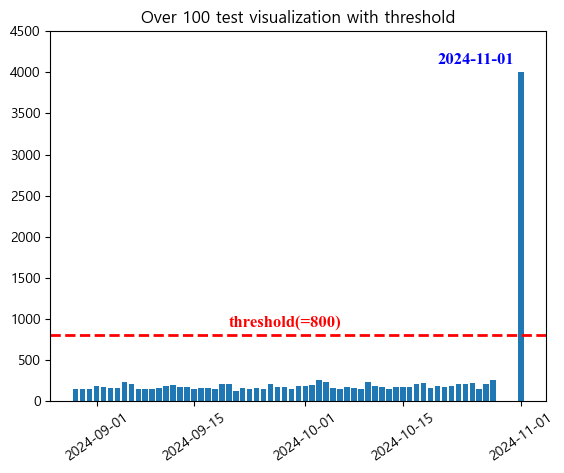

In [276]:
date_set, date_num = np.unique([datetime.strptime(x[:-9], "%Y-%m-%d") for x in pivot_df['검사일']], return_counts = True)

plt.bar(date_set[np.where(date_num > 100)], date_num[np.where(date_num > 100)])
plt.ylim([0, 4500])
plt.axhline(800, 0, 1, color='red', linestyle='--', linewidth=2)
plt.text(date_set[np.where(date_num > 100)][-10], 4100, str(date_set[np.where(date_num > 100)][-1])[:-9], fontdict = {'family': 'Times New Roman',
                                                                                                                      'color':  'blue',
                                                                                                                      'weight': 'bold',
                                                                                                                      'size': 12})
plt.text(date_set[np.where(date_num > 100)][-40], 900, "threshold(=800)", fontdict = {'family': 'Times New Roman',
                                                                                      'color':  'red',
                                                                                      'weight': 'bold',
                                                                                      'size': 12})
plt.title("Over 100 test visualization with threshold")
plt.xticks(rotation=35)
plt.show()

- 데이터 일별 시각화
- 그 중 date의 개수가 100개가 넘는 경우만 확인
- 대부분의 데이터가 100개를 못넘지만 2024년 11월 1일의 경우 기준인 800개를 훨씬 상회하는 값을 가짐

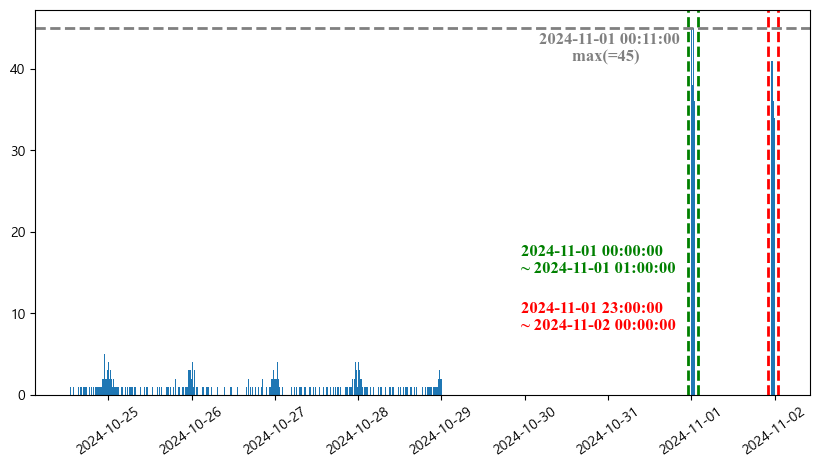

In [277]:
base_date = datetime.strptime('2024-10-25', '%Y-%m-%d')
start_datetime = base_date - timedelta(hours=12)
end_datetime = base_date + timedelta(hours=24+12)  
df_input['검사일_datetime'] = pd.to_datetime(df_input['검사일'])

date_set, date_num = np.unique([datetime.strptime(x[:-3], "%Y-%m-%d %H:%M") for x in df_input[df_input['검사일_datetime'] >= start_datetime]['검사일']],
                               return_counts = True)

plt.figure(figsize = (10, 5))
plt.bar(date_set, date_num, width = 0.01)
plt.axvline(datetime.strptime('2024-10-31', '%Y-%m-%d') + timedelta(hours=23), 0, 1, color='green', linestyle='--', linewidth=2)
plt.axvline(datetime.strptime('2024-10-31', '%Y-%m-%d') + timedelta(hours=26), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(datetime.strptime('2024-10-31', '%Y-%m-%d') - timedelta(hours=25), 15, f"{datetime.strptime('2024-10-31', '%Y-%m-%d') + timedelta(hours=24)} \n~ {datetime.strptime('2024-10-31', '%Y-%m-%d') + timedelta(hours=25)}",
                                         fontdict = {'family': 'Times New Roman',
                                                     'color':  'green',
                                                     'weight': 'bold',
                                                     'size': 12})


plt.axvline(datetime.strptime('2024-11-01', '%Y-%m-%d') + timedelta(hours=22), 0, 1, color='red', linestyle='--', linewidth=2)
plt.axvline(datetime.strptime('2024-11-01', '%Y-%m-%d') + timedelta(hours=25), 0, 1, color='red', linestyle='--', linewidth=2)
plt.text(datetime.strptime('2024-10-31', '%Y-%m-%d') - timedelta(hours=25), 8, f"{datetime.strptime('2024-11-01', '%Y-%m-%d') + timedelta(hours=23)} \n~ {datetime.strptime('2024-11-01', '%Y-%m-%d') + timedelta(hours=24)}",
                                         fontdict = {'family': 'Times New Roman',
                                                     'color':  'red',
                                                     'weight': 'bold',
                                                     'size': 12})

plt.axhline(max(date_num), 0, 1, color='gray', linestyle='--', linewidth=2)
plt.text(datetime.strptime('2024-10-31', '%Y-%m-%d') - timedelta(hours=20), max(date_num) - 4, f"{date_set[np.argmax(date_num)]} \n        max(={max(date_num)})", fontdict = {'family': 'Times New Roman',
                                                                                      'color':  'gray',
                                                                                      'weight': 'bold',
                                                                                      'size': 12})

plt.xticks(rotation=35)
plt.show()

- 데이터 분별 시각화
- 2024년 11월 1일 00시 11분에 검사가 45번이나 몰리는 등 실질적으로 검사가 몰린 구간은 두 구간으로 나뉨
    - 2024년 11월 1일 00시 00분부터 2024년 11월 1일 01시 00분까지
    - 2024년 11월 1일 23시 00분 부터 2024년 11월 1일 23시 59분까지

## Data split

In [278]:
# display(final_df)
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

df_input.loc[:,'성별']=df_input['성별'].astype(str).map({'M':1,'F':2})
df_input.loc[:,'prev_성별']=df_input['prev_성별'].astype(str).map({'M':1,'F':2})
df_input.loc[:,'입원/외래']=df_input['입원/외래'].astype(str).map({'입원':1,'외래':2})
df_input.loc[:,'prev_입원/외래']=df_input['prev_입원/외래'].astype(str).map({'입원':1,'외래':2})

encoder = LabelEncoder()
df_input.loc[:,'진료과'] = df_input['진료과'].astype(str)
df_input.loc[:,'prev_진료과'] = df_input['prev_진료과'].astype(str)
all_departments = pd.concat([df_input['진료과'], df_input['prev_진료과']]).dropna().unique()
encoder.fit(all_departments)
df_input.loc[:,'진료과'] = encoder.transform(df_input['진료과'])
df_input.loc[:,'prev_진료과'] = encoder.transform(df_input['prev_진료과'])

# print(df_input.columns)
x=df_input[['검체번호','환자번호','검사일','성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']]

# 11월 1일 데이터는 x_target으로 제외하고 학습 및 분석 진행
from datetime import datetime, timedelta
base_date = datetime.strptime('2024-11-01', '%Y-%m-%d')
start_datetime = base_date - timedelta(hours=0)
end_datetime = base_date + timedelta(hours=24)  
df_input['검사일_datetime'] = pd.to_datetime(df_input['검사일'])
x_target = x[(df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime)]
x = x[~((df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime))]

In [279]:
print('x patient num : '+str(x['환자번호'].value_counts().shape[0])+'명') # 5676명 확인
print('x_target patient num : '+str(x_target['환자번호'].value_counts().shape[0])+'명') # 4000명 확인

x patient num : 5494명
x_target patient num : 3740명


## Data histogram

In [280]:
# 데이터 숫자로 변환
def extract_number(value):
    match = re.search(r'\d+(\.\d+)?', str(value)) 
    if match:
        return float(match.group())
    return None

In [281]:
input_str = ['성별', '나이', 'prev_나이','진료과','prev_진료과', '입원/외래','prev_입원/외래', 'ALP','prev_ALP', 'ALT','prev_ALT', 'AST','prev_AST', 'Albumin',
       'prev_Albumin','BUN', 'prev_BUN', 'Creatinine','prev_Creatinine', 'GGT','prev_GGT', 'Glucose','prev_Glucose', 'LDH','prev_LDH', 'Total Bilirubin','prev_Total Bilirubin',
       'Total Protein','prev_Total Protein']

tx=x[input_str]

for col in tx.columns:
    tx[col] = tx[col].apply(extract_number)

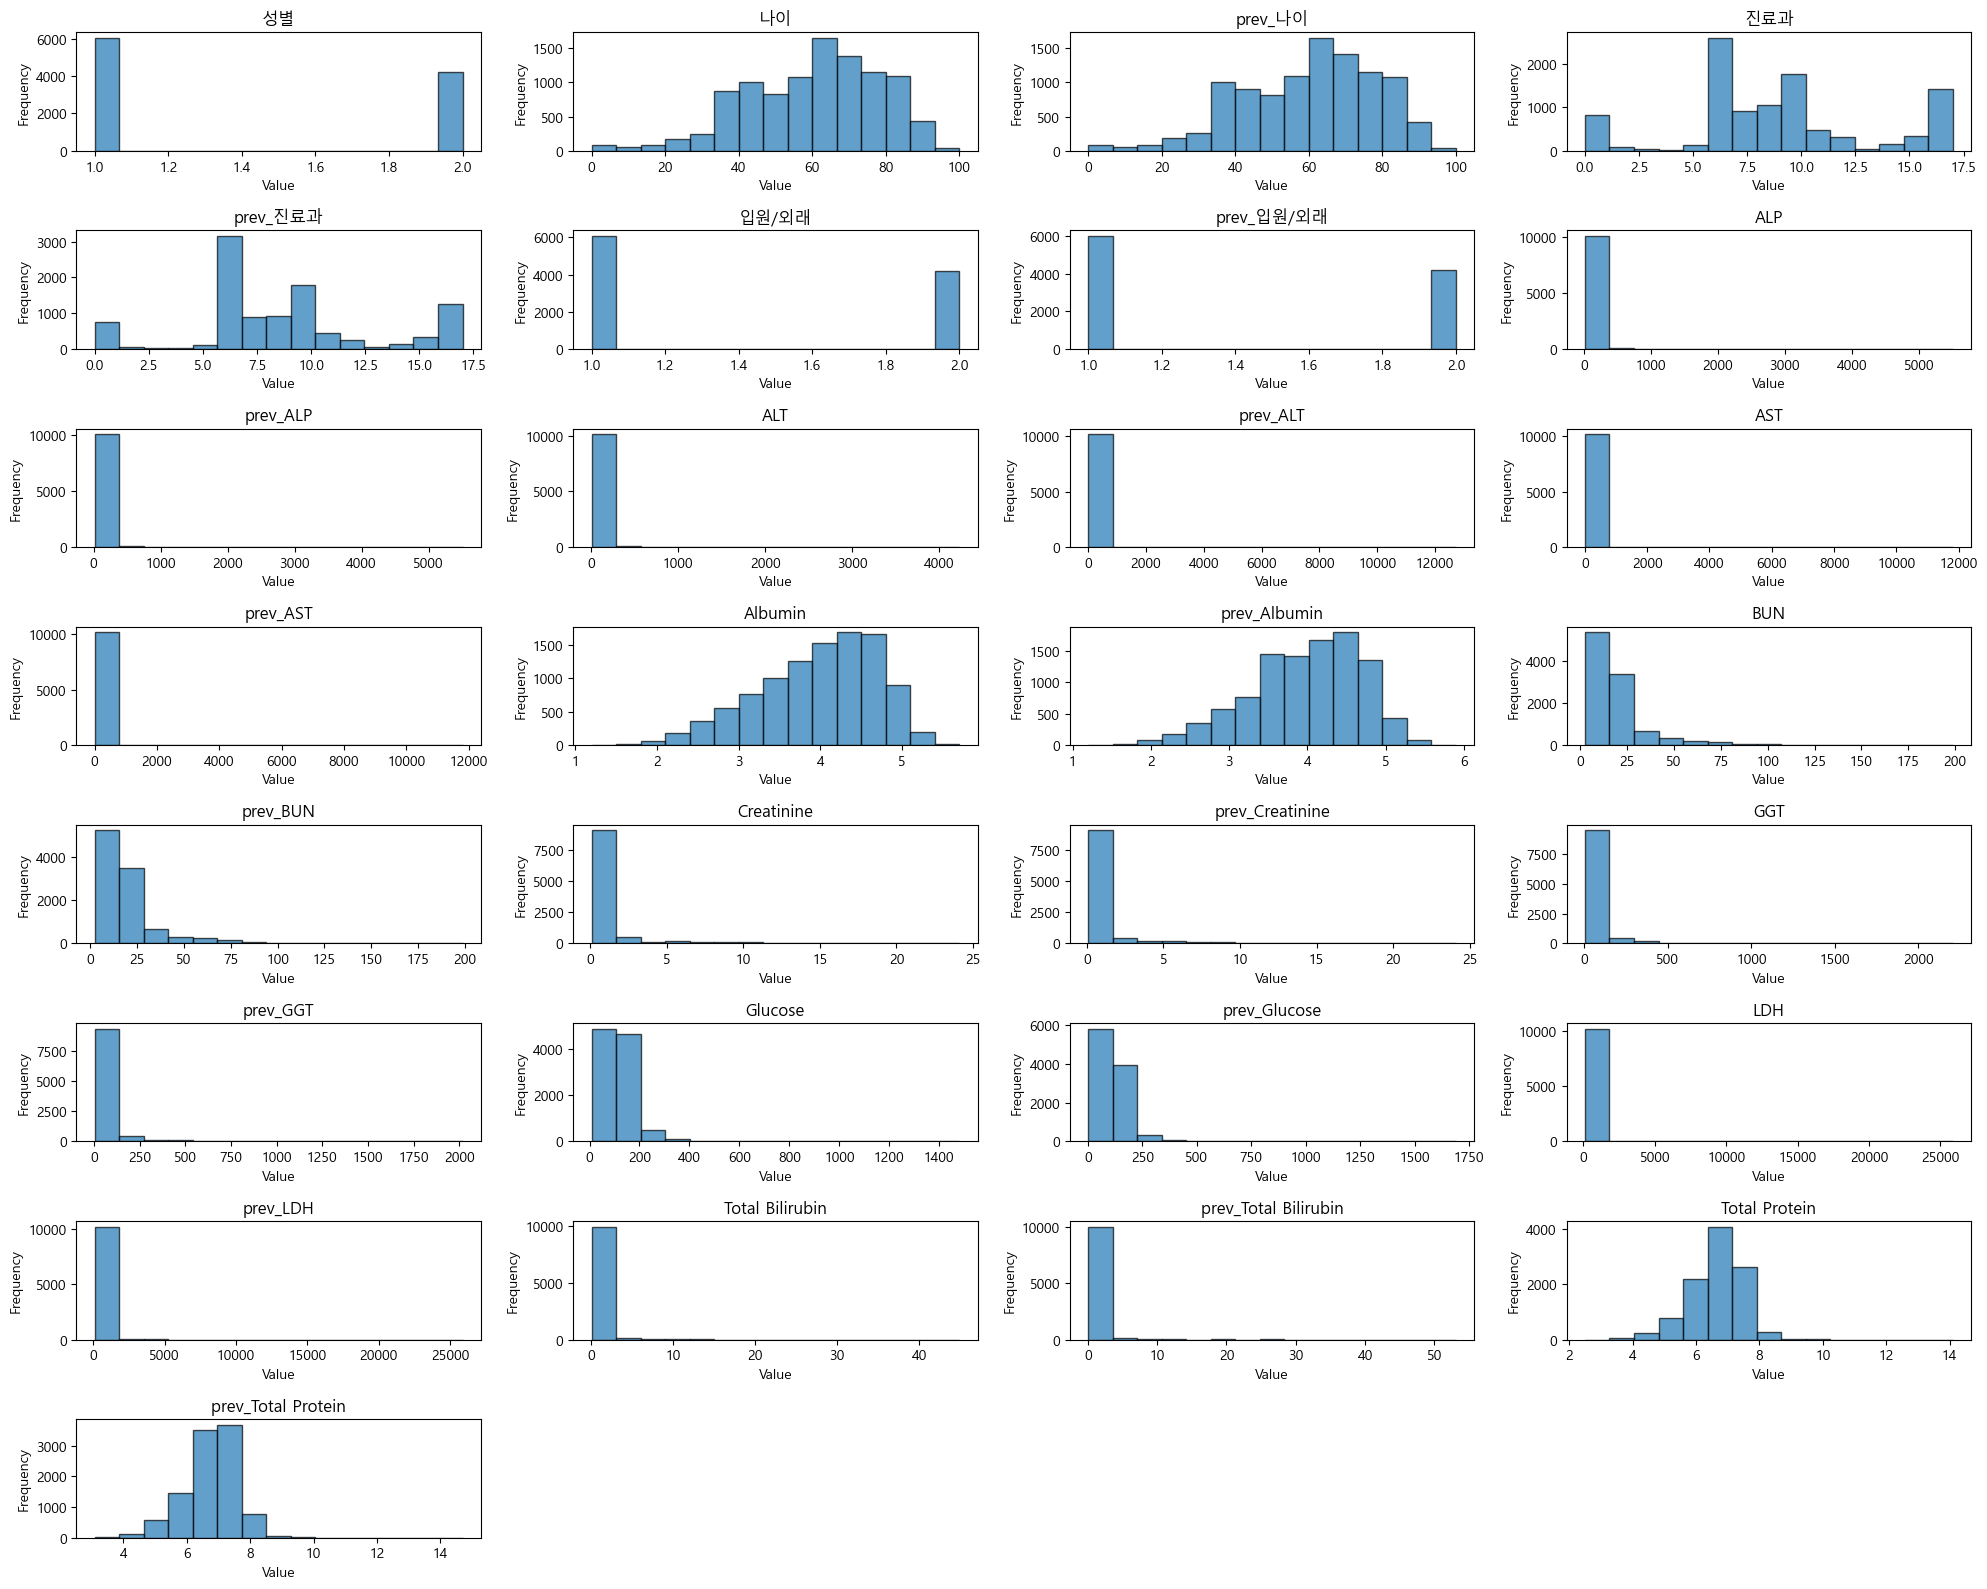

In [282]:
# 데이터 분포 시각화
num_cols = tx.shape[1]
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 16))

for i, col in enumerate(tx.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(tx[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(num_cols, 32):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

- 성별, 입원/외래, 진료과의 범주형 데이터는 제외하고 확인
- 나이, Albumin, Total_Protein은 정규 분포라고 할 순 없지만 분포가 확인 가능할 정도로 구성되어 있음
- ALP, ALT, AST, BUN, Creatinine, GGT, Glucose, LDH, Total Bilirubin은 이상치가 존재하여 분포가 이상하게 그려짐을 확인할 수 있음

### Binarizer

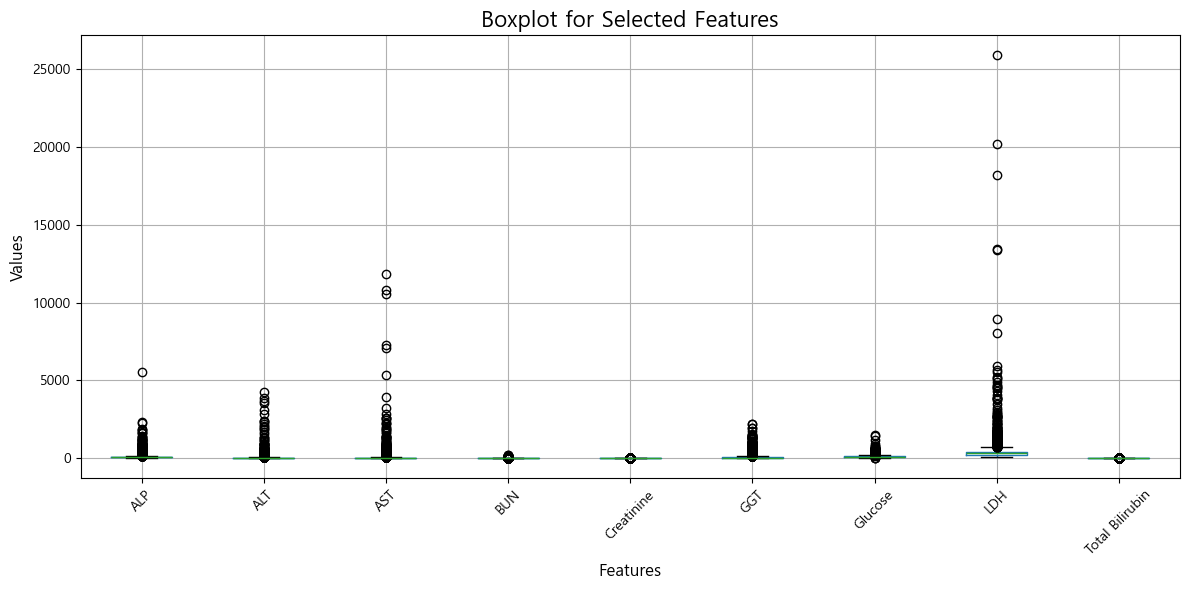

In [283]:
columns_to_plot = ['ALP', 'ALT', 'AST', 'BUN', 'Creatinine', 
                   'GGT', 'Glucose', 'LDH', 'Total Bilirubin']

plt.figure(figsize=(12, 6))
tx[columns_to_plot].boxplot()

plt.title('Boxplot for Selected Features', fontsize=16)
plt.ylabel('Values', fontsize=12)
plt.xlabel('Features', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [284]:
# 데이터 확인
tx[['ALP', 'ALT', 'AST', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin']].describe()

,ALP,ALT,AST,BUN,Creatinine,GGT,Glucose,LDH,Total Bilirubin
count,10232.000000,10232.000000,10232.000000,10232.000000,10232.000000,10232.000000,10232.000000,10232.000000,10232.000000
mean,98.261875,36.111747,48.457936,20.277609,1.398612,60.242758,125.031626,374.801388,0.943680
std,112.636801,122.463785,250.596107,16.611392,1.993746,116.785006,58.390057,510.757474,1.778671
min,15.000000,5.000000,6.000000,2.500000,0.100000,5.000000,8.000000,104.000000,0.030000
25%,60.000000,13.000000,19.000000,11.500000,0.700000,17.000000,95.000000,220.000000,0.450000
50%,75.000000,19.000000,25.000000,15.200000,0.900000,28.000000,108.000000,320.000000,0.640000
75%,101.000000,31.000000,35.000000,21.700000,1.100000,55.000000,135.000000,422.000000,0.930000
max,5507.000000,4229.000000,11804.000000,198.700000,24.100000,2205.000000,1480.000000,25875.000000,44.890000


- 이 데이터들에 대한 분포를 값으로 확인한 표
- 이 경우 제 3분위수(75%)에 비해 max값이 매우 큼을 확인할 수 있음
- 이상치 제거가 필요하거나 스케일링을 통해 분포를 바꿔주는 작업이 필요함
    - 이상치 제거 : 이상치를 제거해도 데이터 갯수가 충분할 경우 사용
- 현재 데이터는 10232개로 이상치를 제거하면 데이터가 부족해 질 수 있으므로 이상치 판단에 대한 변수 생성 후 분포 변환 적용
    - 이상치 경우 IQR(Interquartile Range)을 활용하여 제 3분위수 + 1.5*IQR를 초과하는 데이터를 1, 이하를 0으로 라벨링

In [285]:
# IQR 기반 이상치 판단 함수 정의
def calculate_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  # IQR 계산
    upper_bound = Q3 + 1.5 * IQR  # 상한
    
    return df[column].apply(lambda x: 1 if x > upper_bound else 0)

columns_to_check = ['ALP', 'ALT', 'AST', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin']

for column in columns_to_check:
    outlier_column_name = f"outlier_{column}"
    tx[outlier_column_name] = calculate_outliers(tx, column)

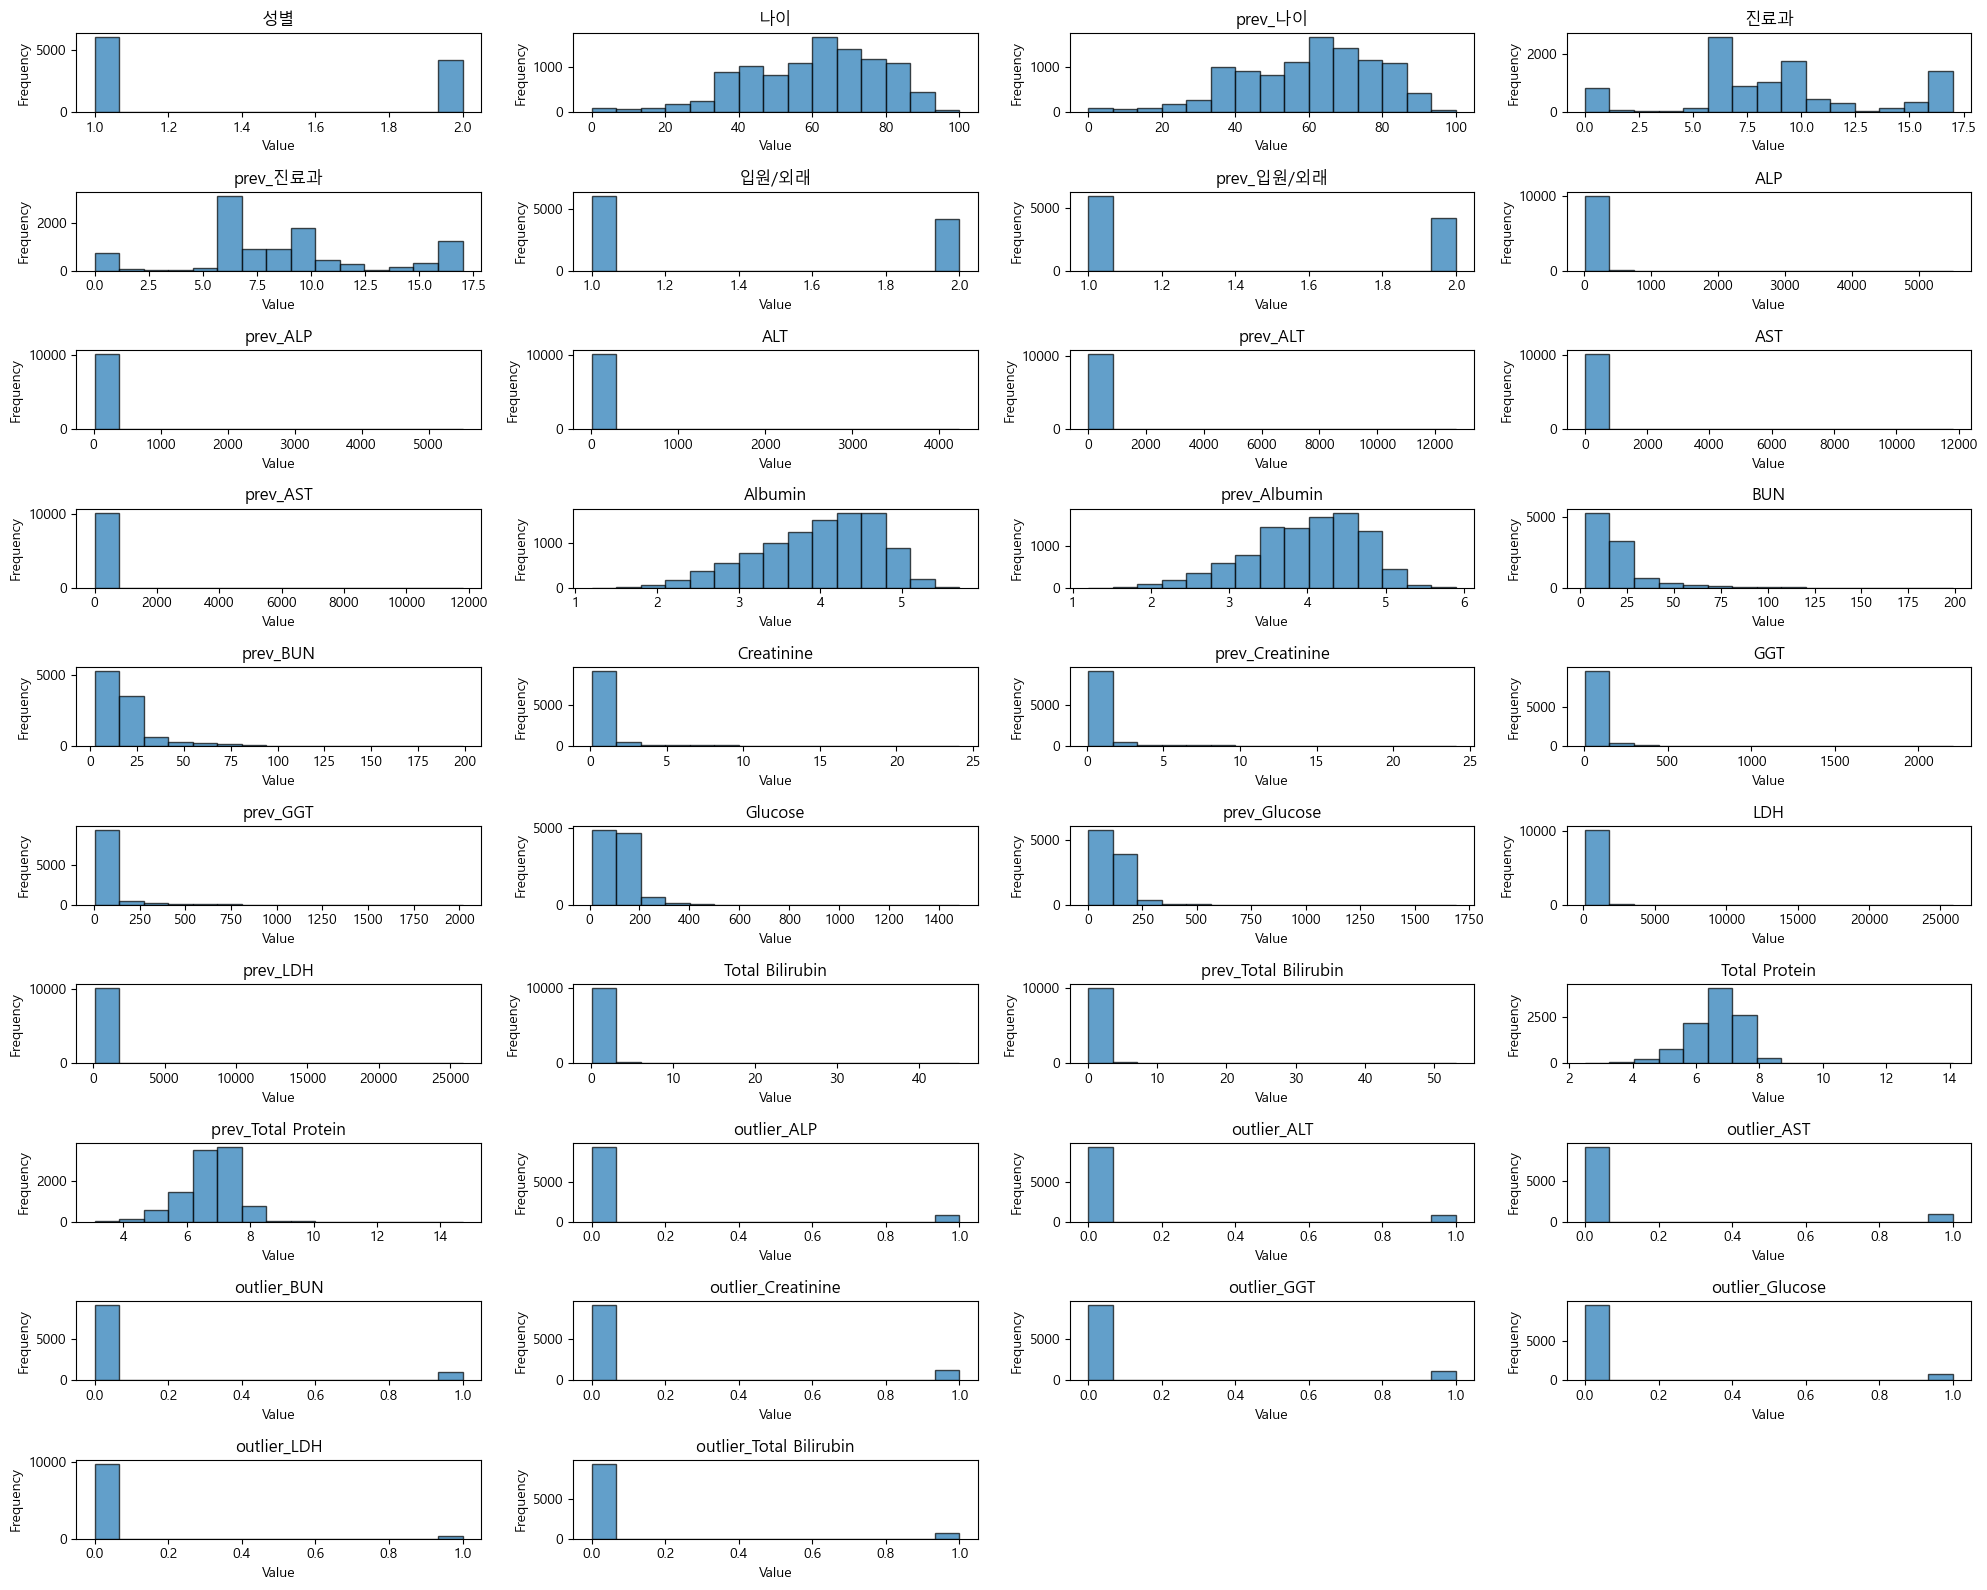

In [286]:
# 데이터 분포 시각화
num_cols = tx.shape[1]
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(20, 16))

for i, col in enumerate(tx.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(tx[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(num_cols, 40):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

- upper로 outlier에 대한 라벨링 추가, 대부분 0이지만 1인 값들도 확인이 가능할 정도로 존재함을 확인할 수 있음

### 데이터 변환

- ALP, ALT, AST, BUN, Creatinine, GGT, Glucose, LDH, Total Bilirubin를 비롯한 Albumin, Total Protein에 대해서 변환 작업을 적용
- 오른쪽으로 치우쳐져 있을 경우 로그 변환
- 왼쪽으로 치우쳐진 경우 Box-Cox 변환

In [287]:
from scipy.stats import boxcox

# Skewness 조정 함수 정의
def transform_skewness(column, skew_direction):
    if skew_direction == 'positive':
        # 오른쪽으로 치우친 분포 -> 로그 변환
        transformed = np.log1p(column)  # log(1 + x)로 계산 (음수 방지)
    elif skew_direction == 'negative':
        # 왼쪽으로 치우친 분포 -> Box-Cox 변환
        transformed, _ = boxcox(column - column.min() + 1)  # 최소값 보정
    else:
        raise ValueError("Invalid skew_direction. Use 'positive' or 'negative'.")
    return transformed

# 열별 skewness 방향 정의
skew_info = {
    'ALP': 'negative',
    'ALT': 'negative',
    'AST': 'negative',
    'Albumin': 'positive',
    'BUN': 'negative',
    'Creatinine': 'negative',
    'GGT': 'negative',
    'Glucose': 'negative',
    'LDH': 'negative',
    'Total Bilirubin': 'negative',
    'Total Protein': 'negative'
}

for col, skew_dir in skew_info.items():
    tx[f'{col}'] = transform_skewness(tx[col], skew_dir)

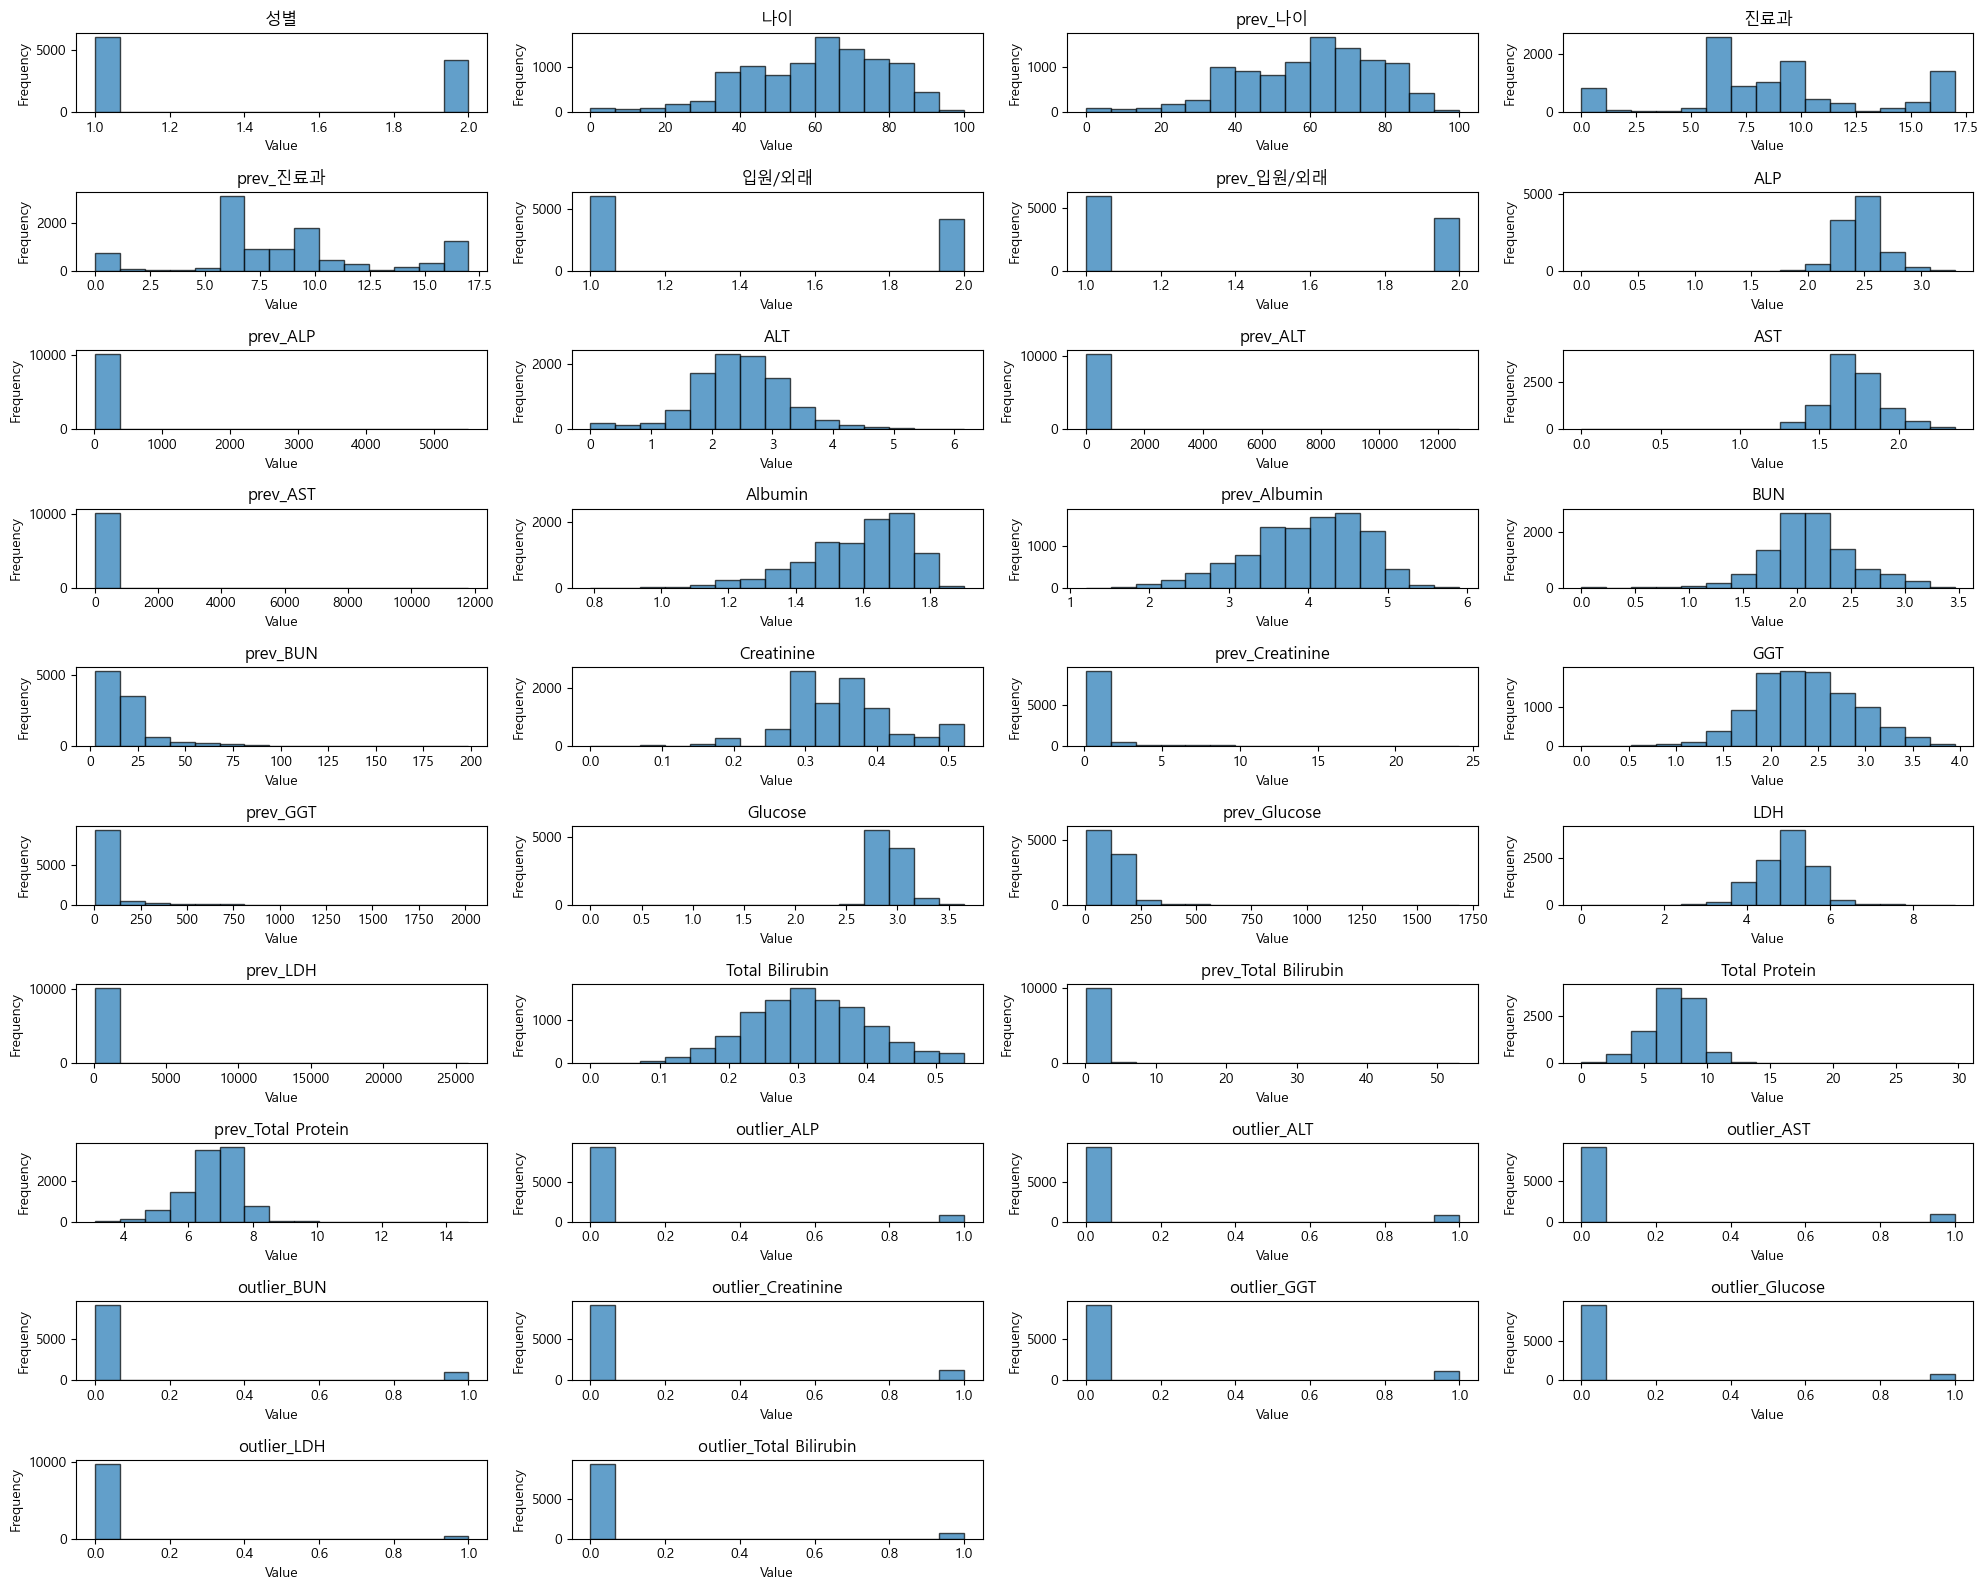

In [288]:
# 데이터 분포 시각화
num_cols = tx.shape[1]
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(20, 16))

for i, col in enumerate(tx.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(tx[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(num_cols, 40):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

- prev_X와 X 변수를 비교했을 시 분포가 잘 보이는 것을 확인할 수 있음
- 기존에도 분포가 확인 되었던 Albumin, Total Protein의 경우 큰 변화는 없음
- Glucose의 경우 변환을 적용하였음에도 불구하고 왼쪽에서 오른쪽으로 이동한 수준의 변화만 보임

In [289]:
# prev 변수도 마저 변환
for col, skew_dir in skew_info.items():
    tx[f'prev_{col}'] = transform_skewness(tx[f'prev_{col}'], skew_dir)

### Scaling

- Glucose 등 값의 분포가 크게 변하지 않은 경우가 존재
- 변수들의 x축을 보면 값의 범위가 다름
    - Total Protein은 0-30의 범위이지만 Creatinine은 0-0.5의 범위
- Scaling은 변수 간 값의 범위를 일정 범위로 조절해줄 수 있음

In [290]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaling_features = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein']

# 1. StandardScaler
standard_scaler = StandardScaler()
standard_scaled = standard_scaler.fit_transform(tx[scaling_features])
standard_scaled_df = pd.DataFrame(standard_scaled, columns=[f"{col}_standard" for col in scaling_features])

# 2. MinMaxScaler
minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(tx[scaling_features])
minmax_scaled_df = pd.DataFrame(minmax_scaled, columns=[f"{col}_minmax" for col in scaling_features])

# 3. RobustScaler
robust_scaler = RobustScaler()
robust_scaled = robust_scaler.fit_transform(tx[scaling_features])
robust_scaled_df = pd.DataFrame(robust_scaled, columns=[f"{col}_robust" for col in scaling_features])

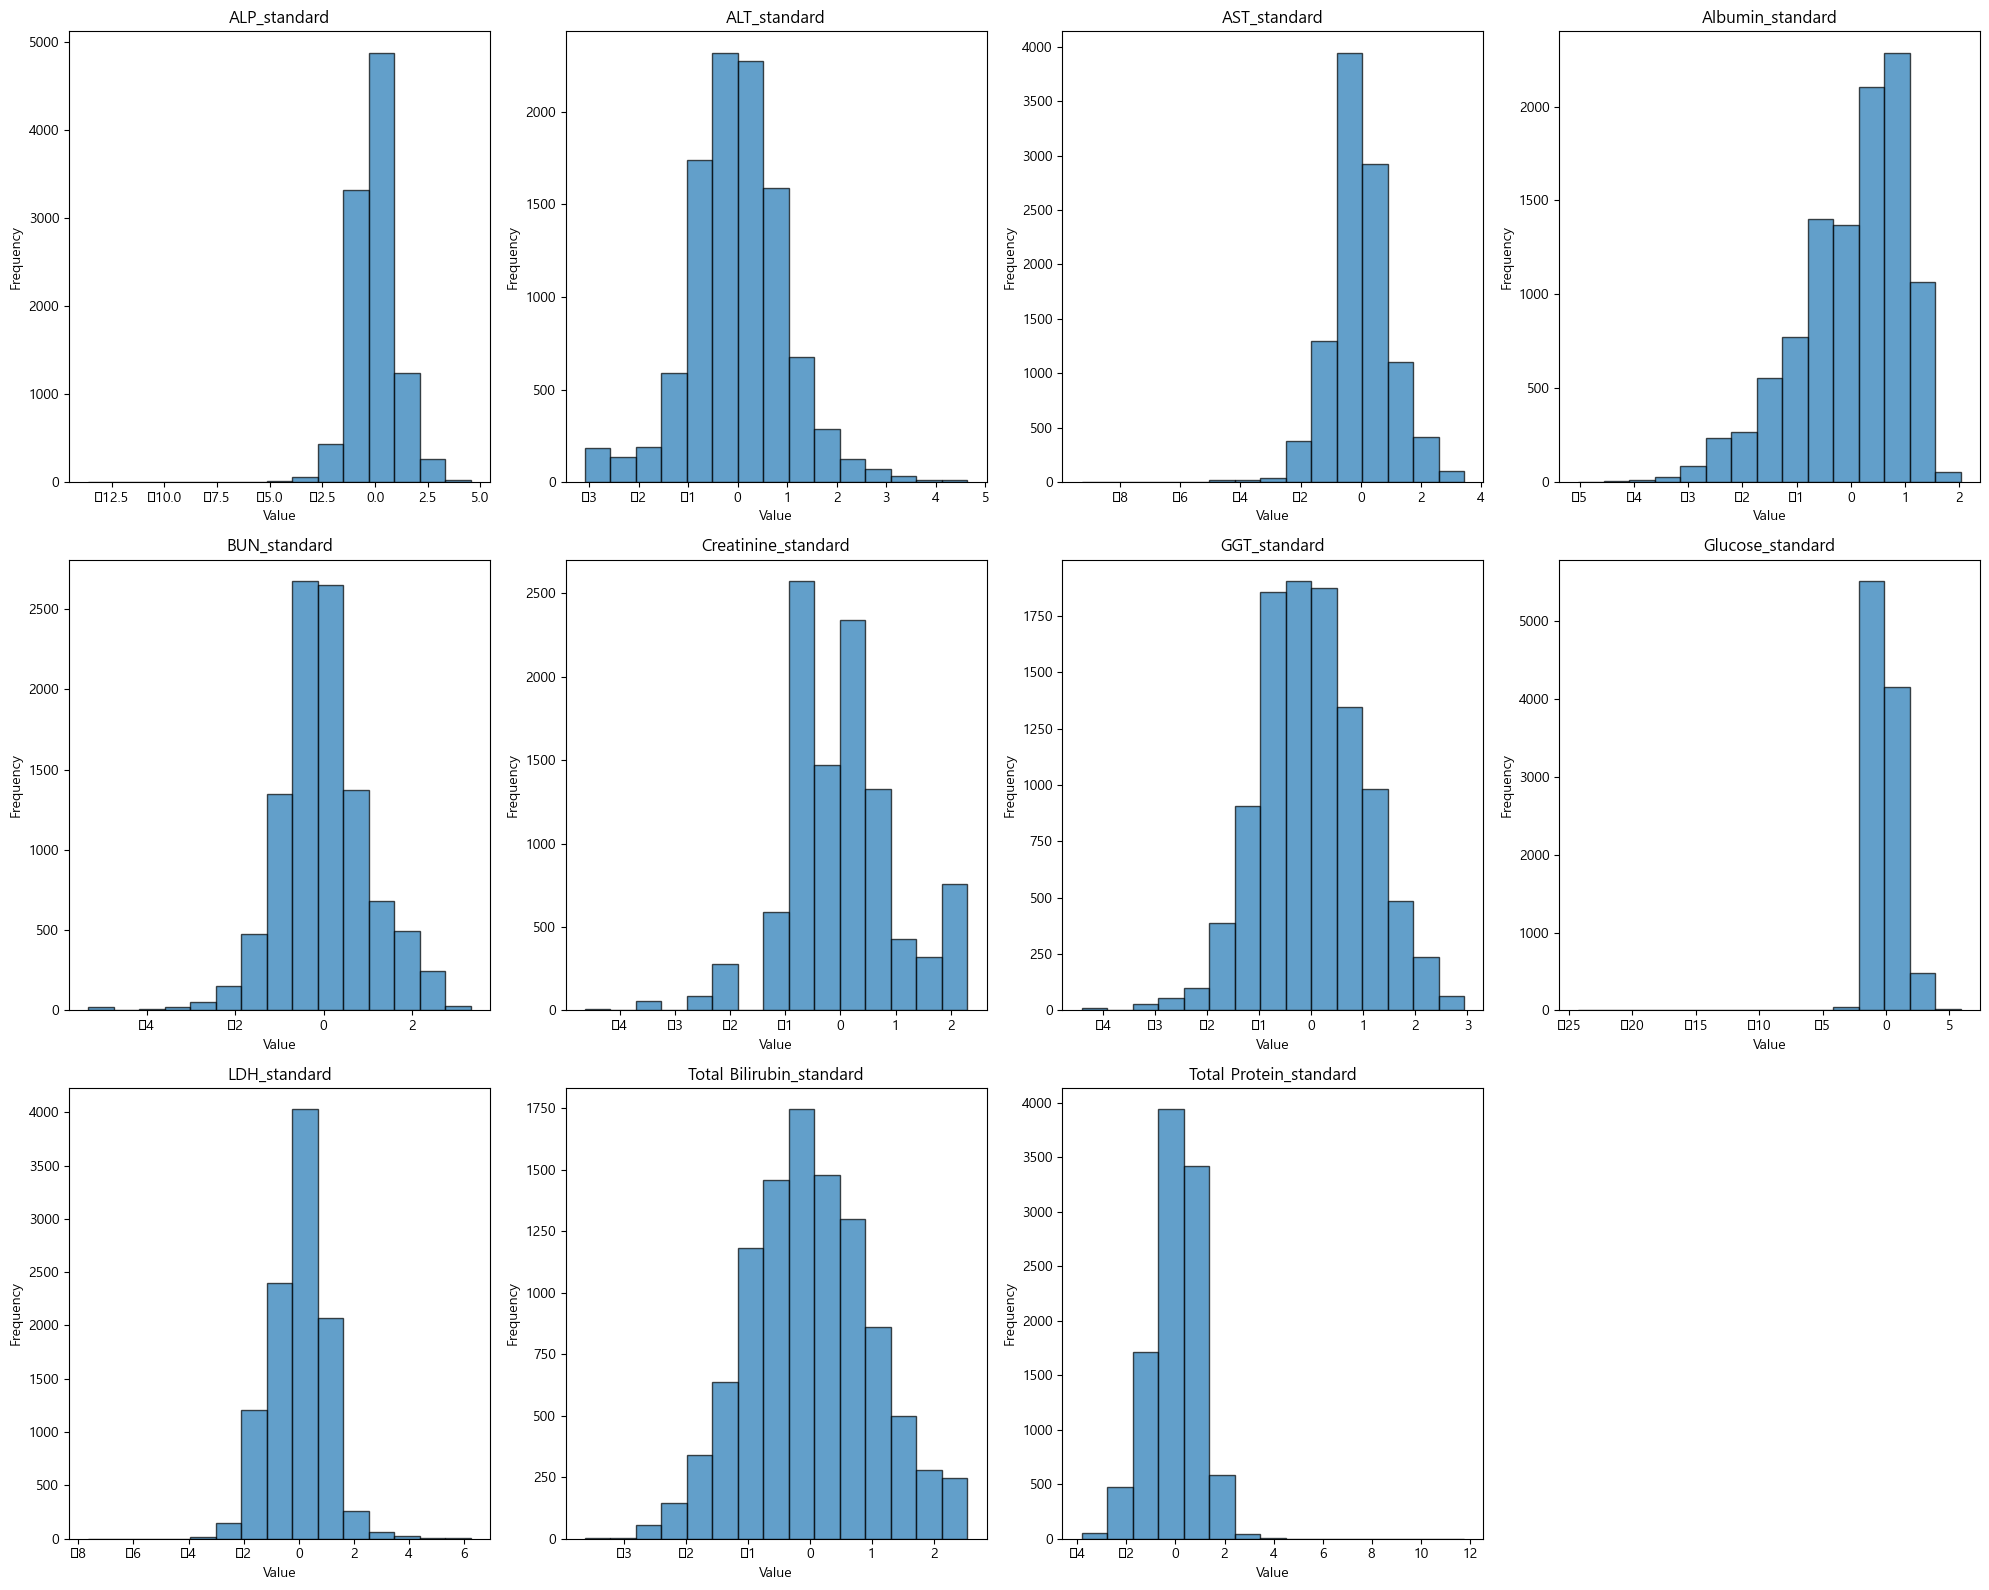

In [291]:
# StandardScaler 데이터 분포 시각화
num_cols = standard_scaled_df.shape[1]
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 16))

for i, col in enumerate(standard_scaled_df.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(standard_scaled_df[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(num_cols, 12):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

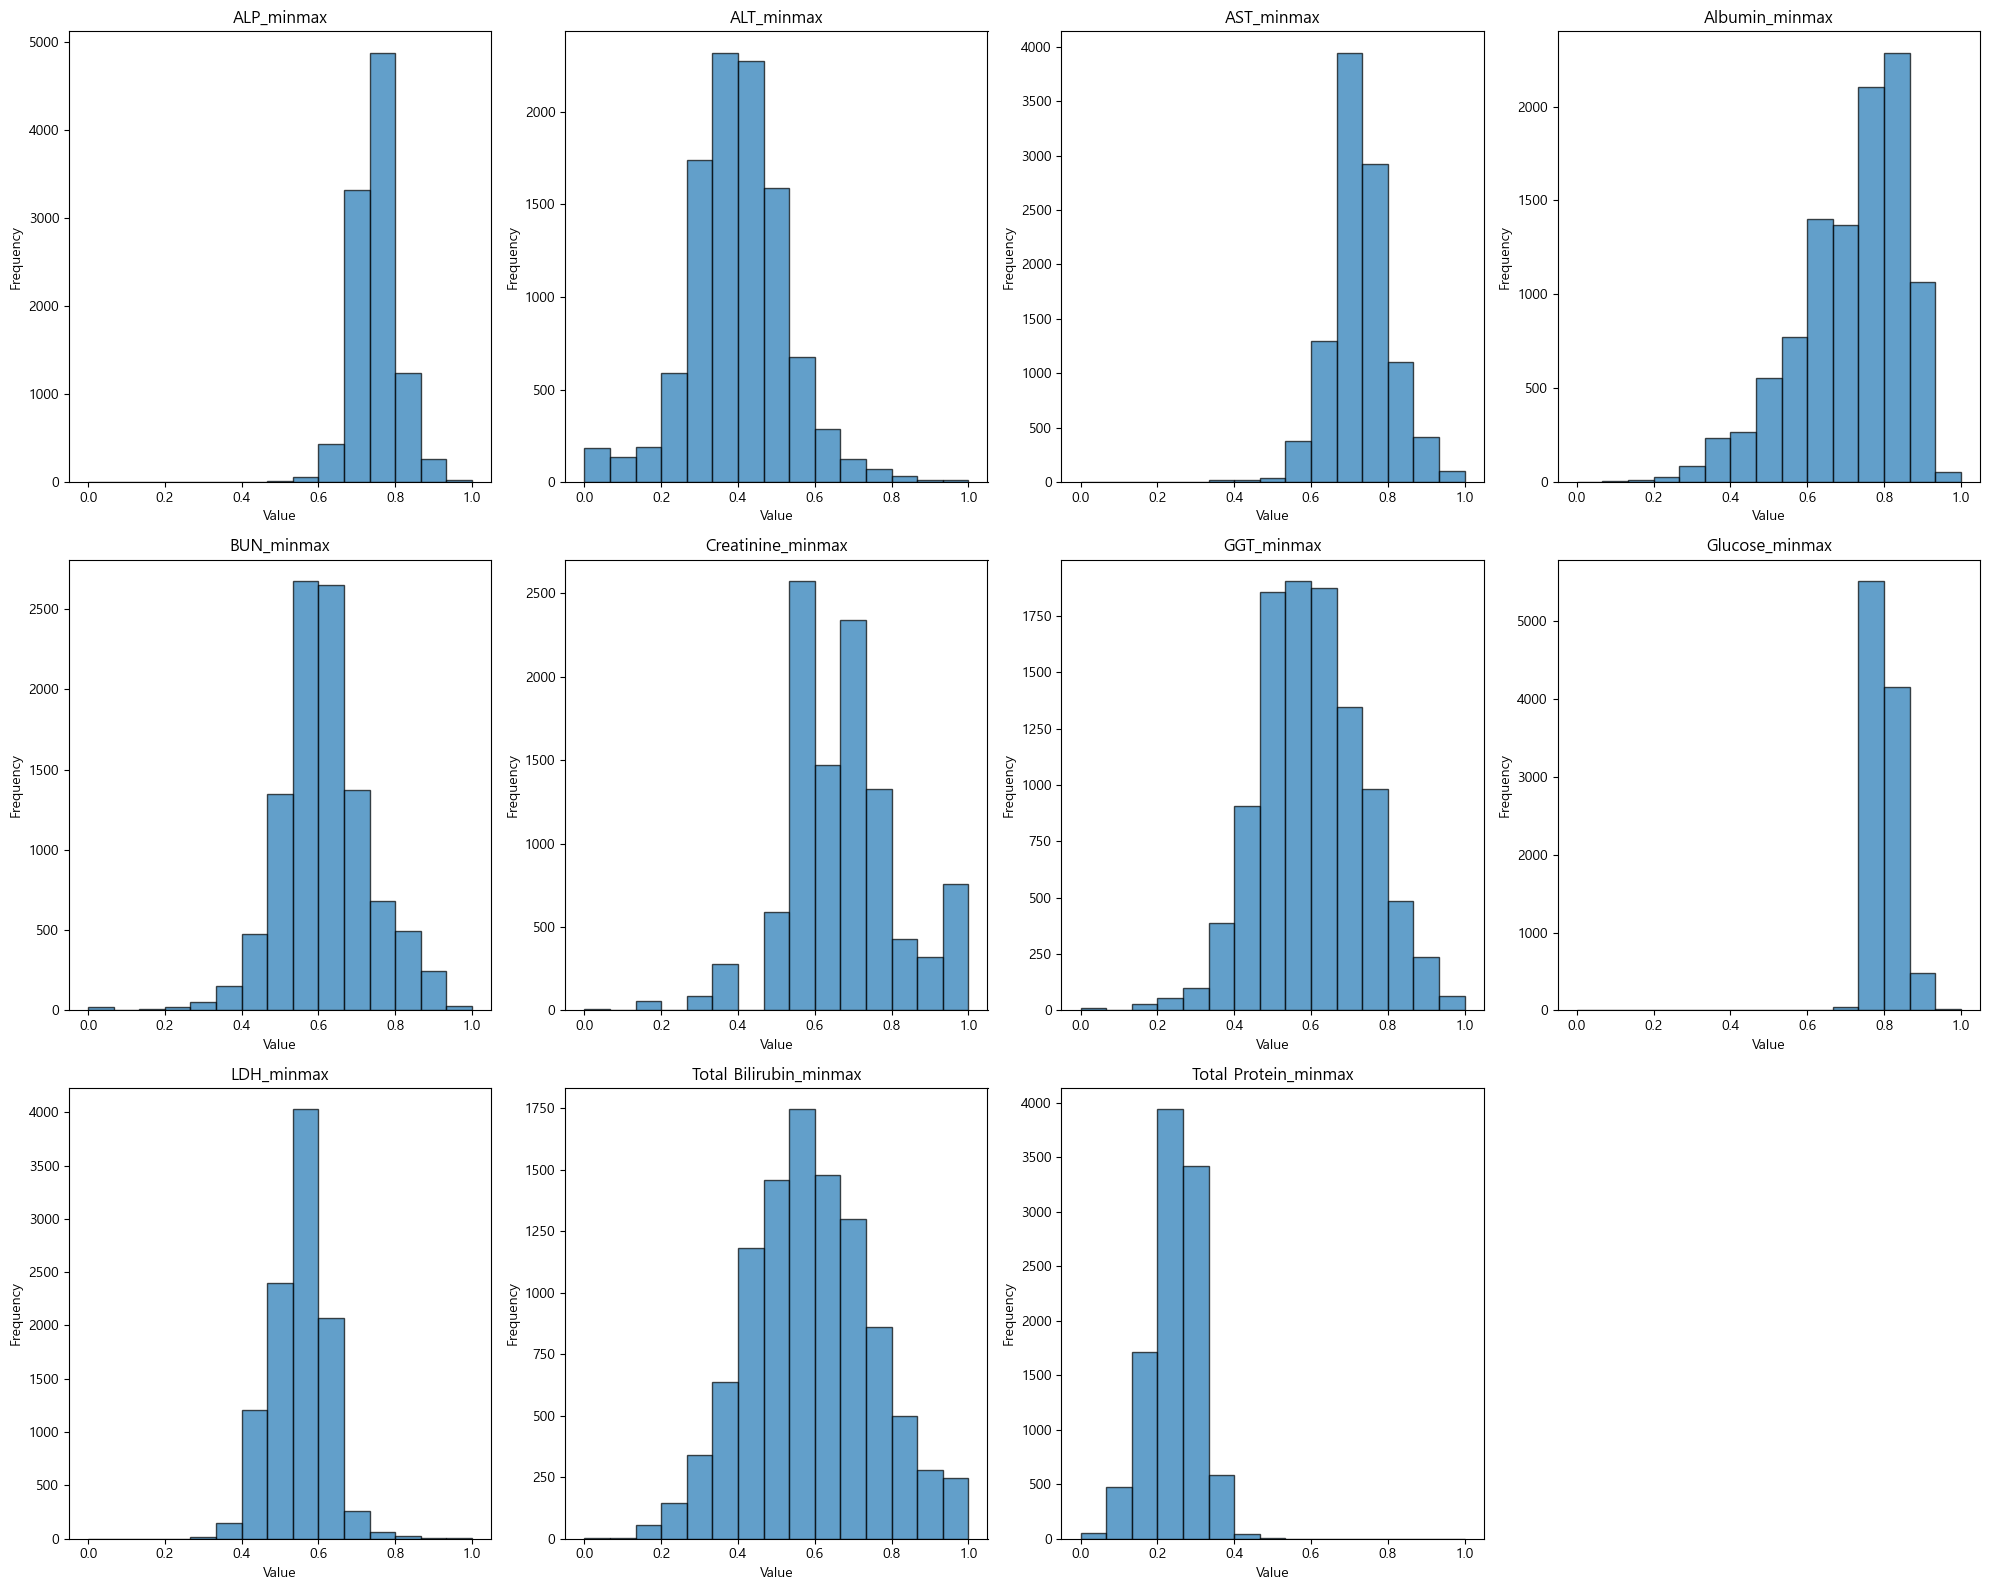

In [292]:
# MinMaxScaler 데이터 분포 시각화
num_cols = standard_scaled_df.shape[1]
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 16))

for i, col in enumerate(minmax_scaled_df.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(minmax_scaled_df[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(num_cols, 12):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

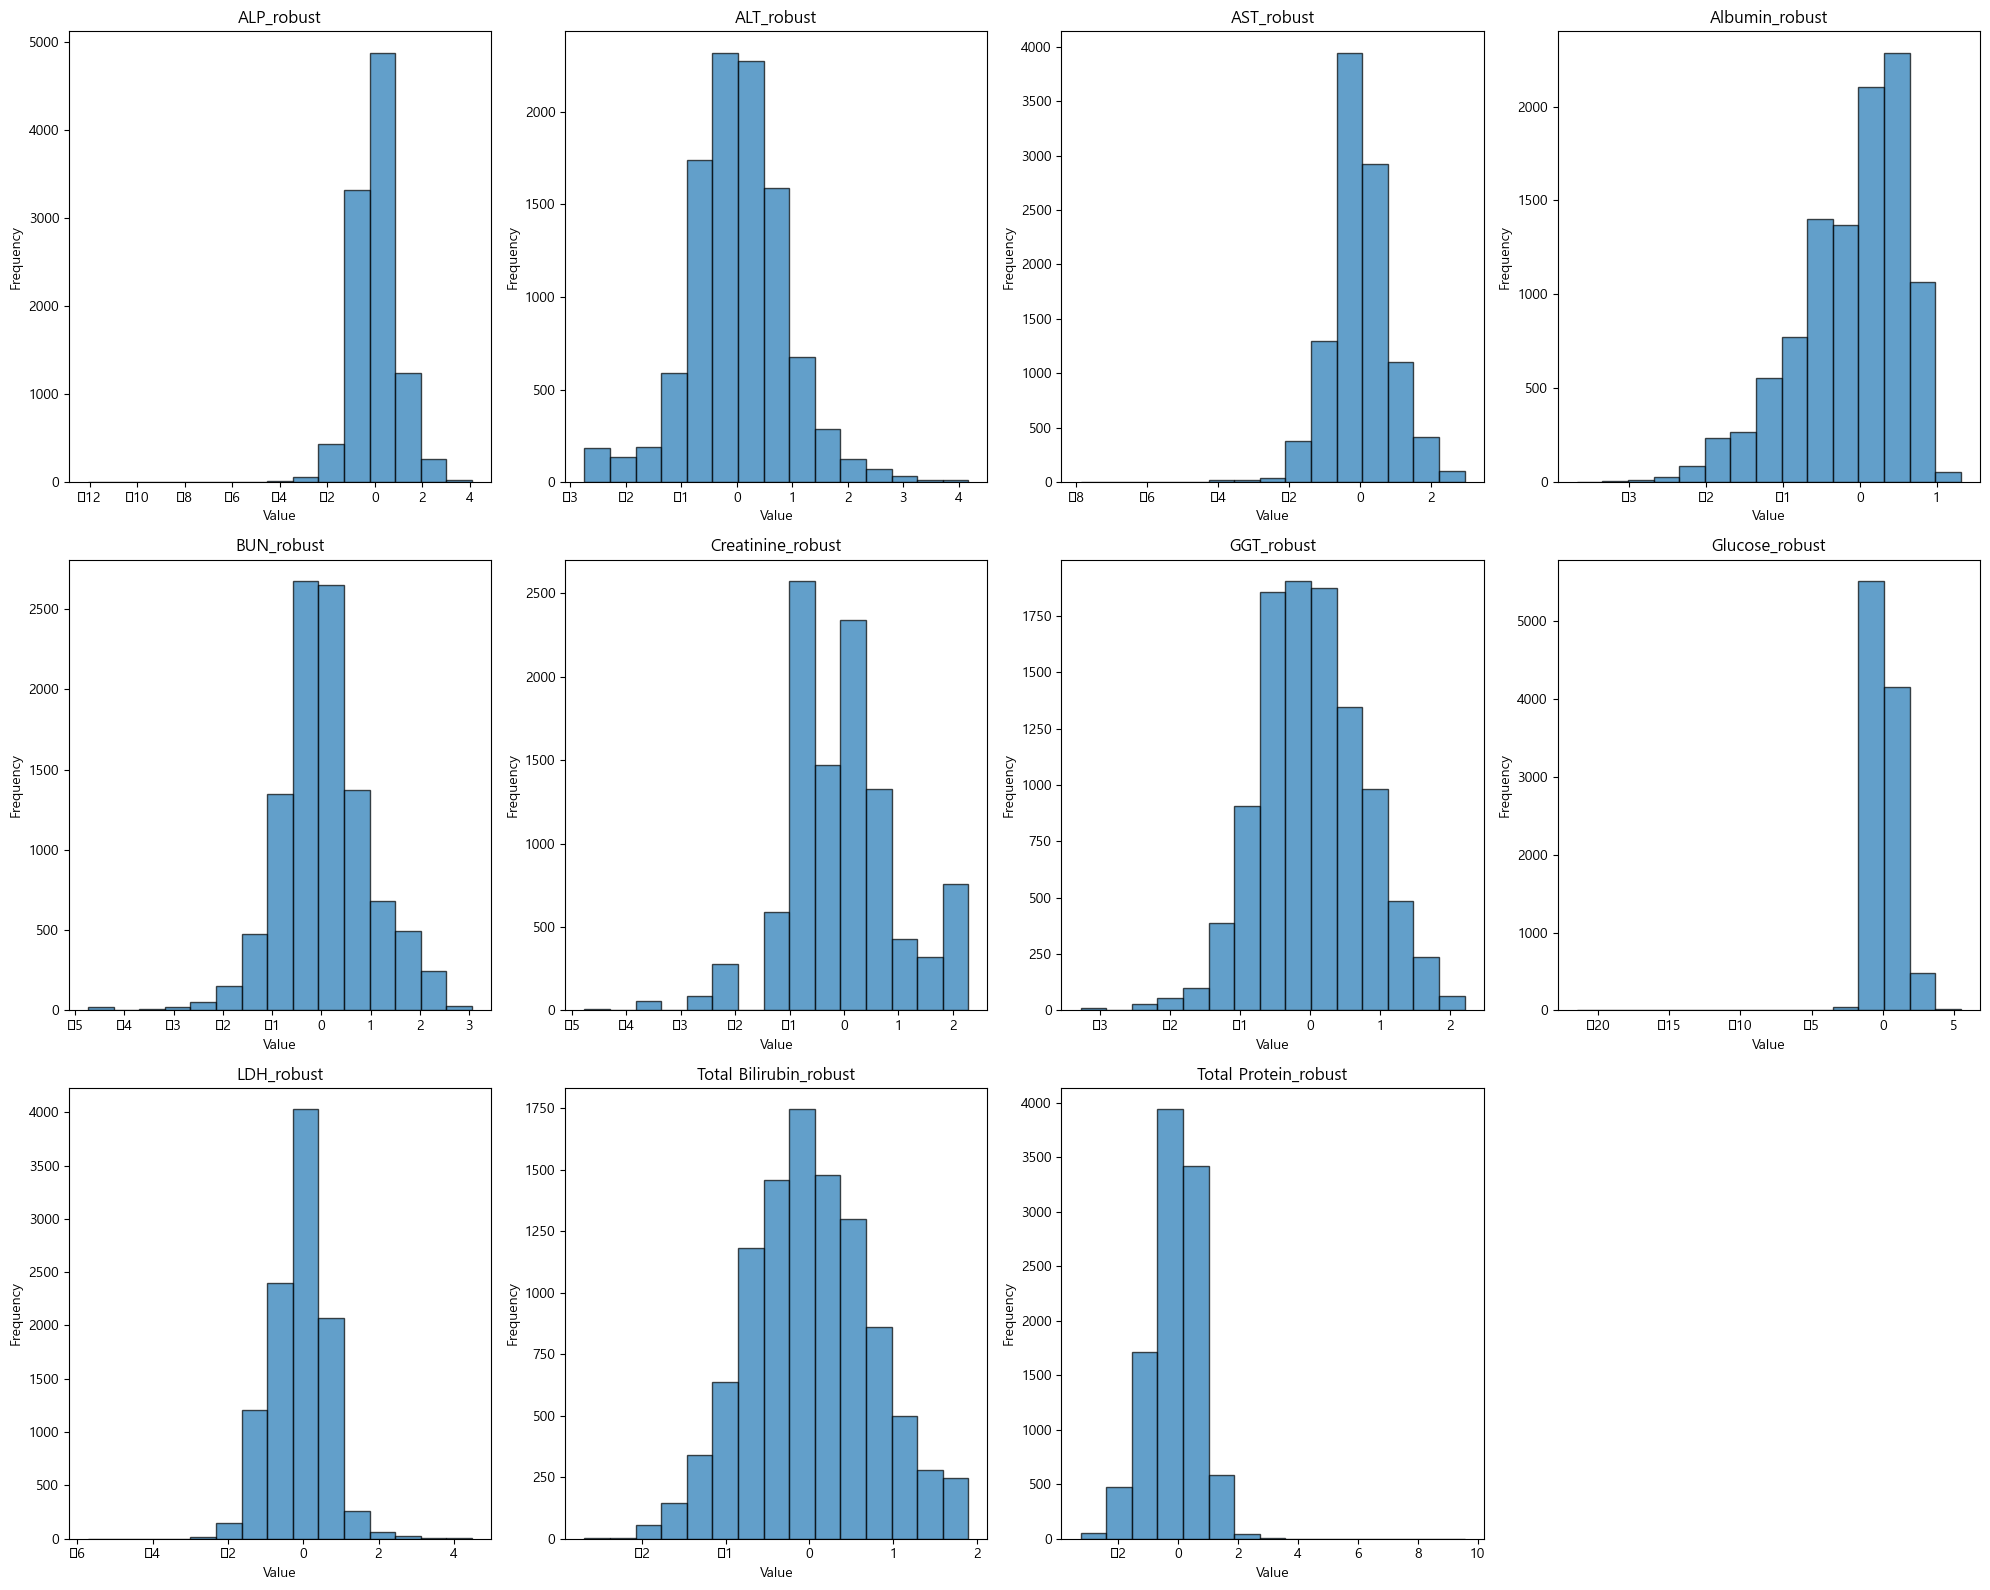

In [293]:
# RobustScaler 데이터 분포 시각화
num_cols = standard_scaled_df.shape[1]
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 16))

for i, col in enumerate(robust_scaled_df.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(robust_scaled_df[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(num_cols, 12):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

- 이미 값 변환을 거쳐 범위가 줄어들었으므로 MinMaxScaler를 사용하여 값의 범위를 0~1로 통일하여 진행

In [294]:
scaling_features = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein',
                   'prev_ALP', 'prev_ALT', 'prev_AST', 'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT', 'prev_Glucose',
                    'prev_LDH', 'prev_Total Bilirubin', 'prev_Total Protein']

minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(tx[scaling_features])
tx[scaling_features] = minmax_scaled

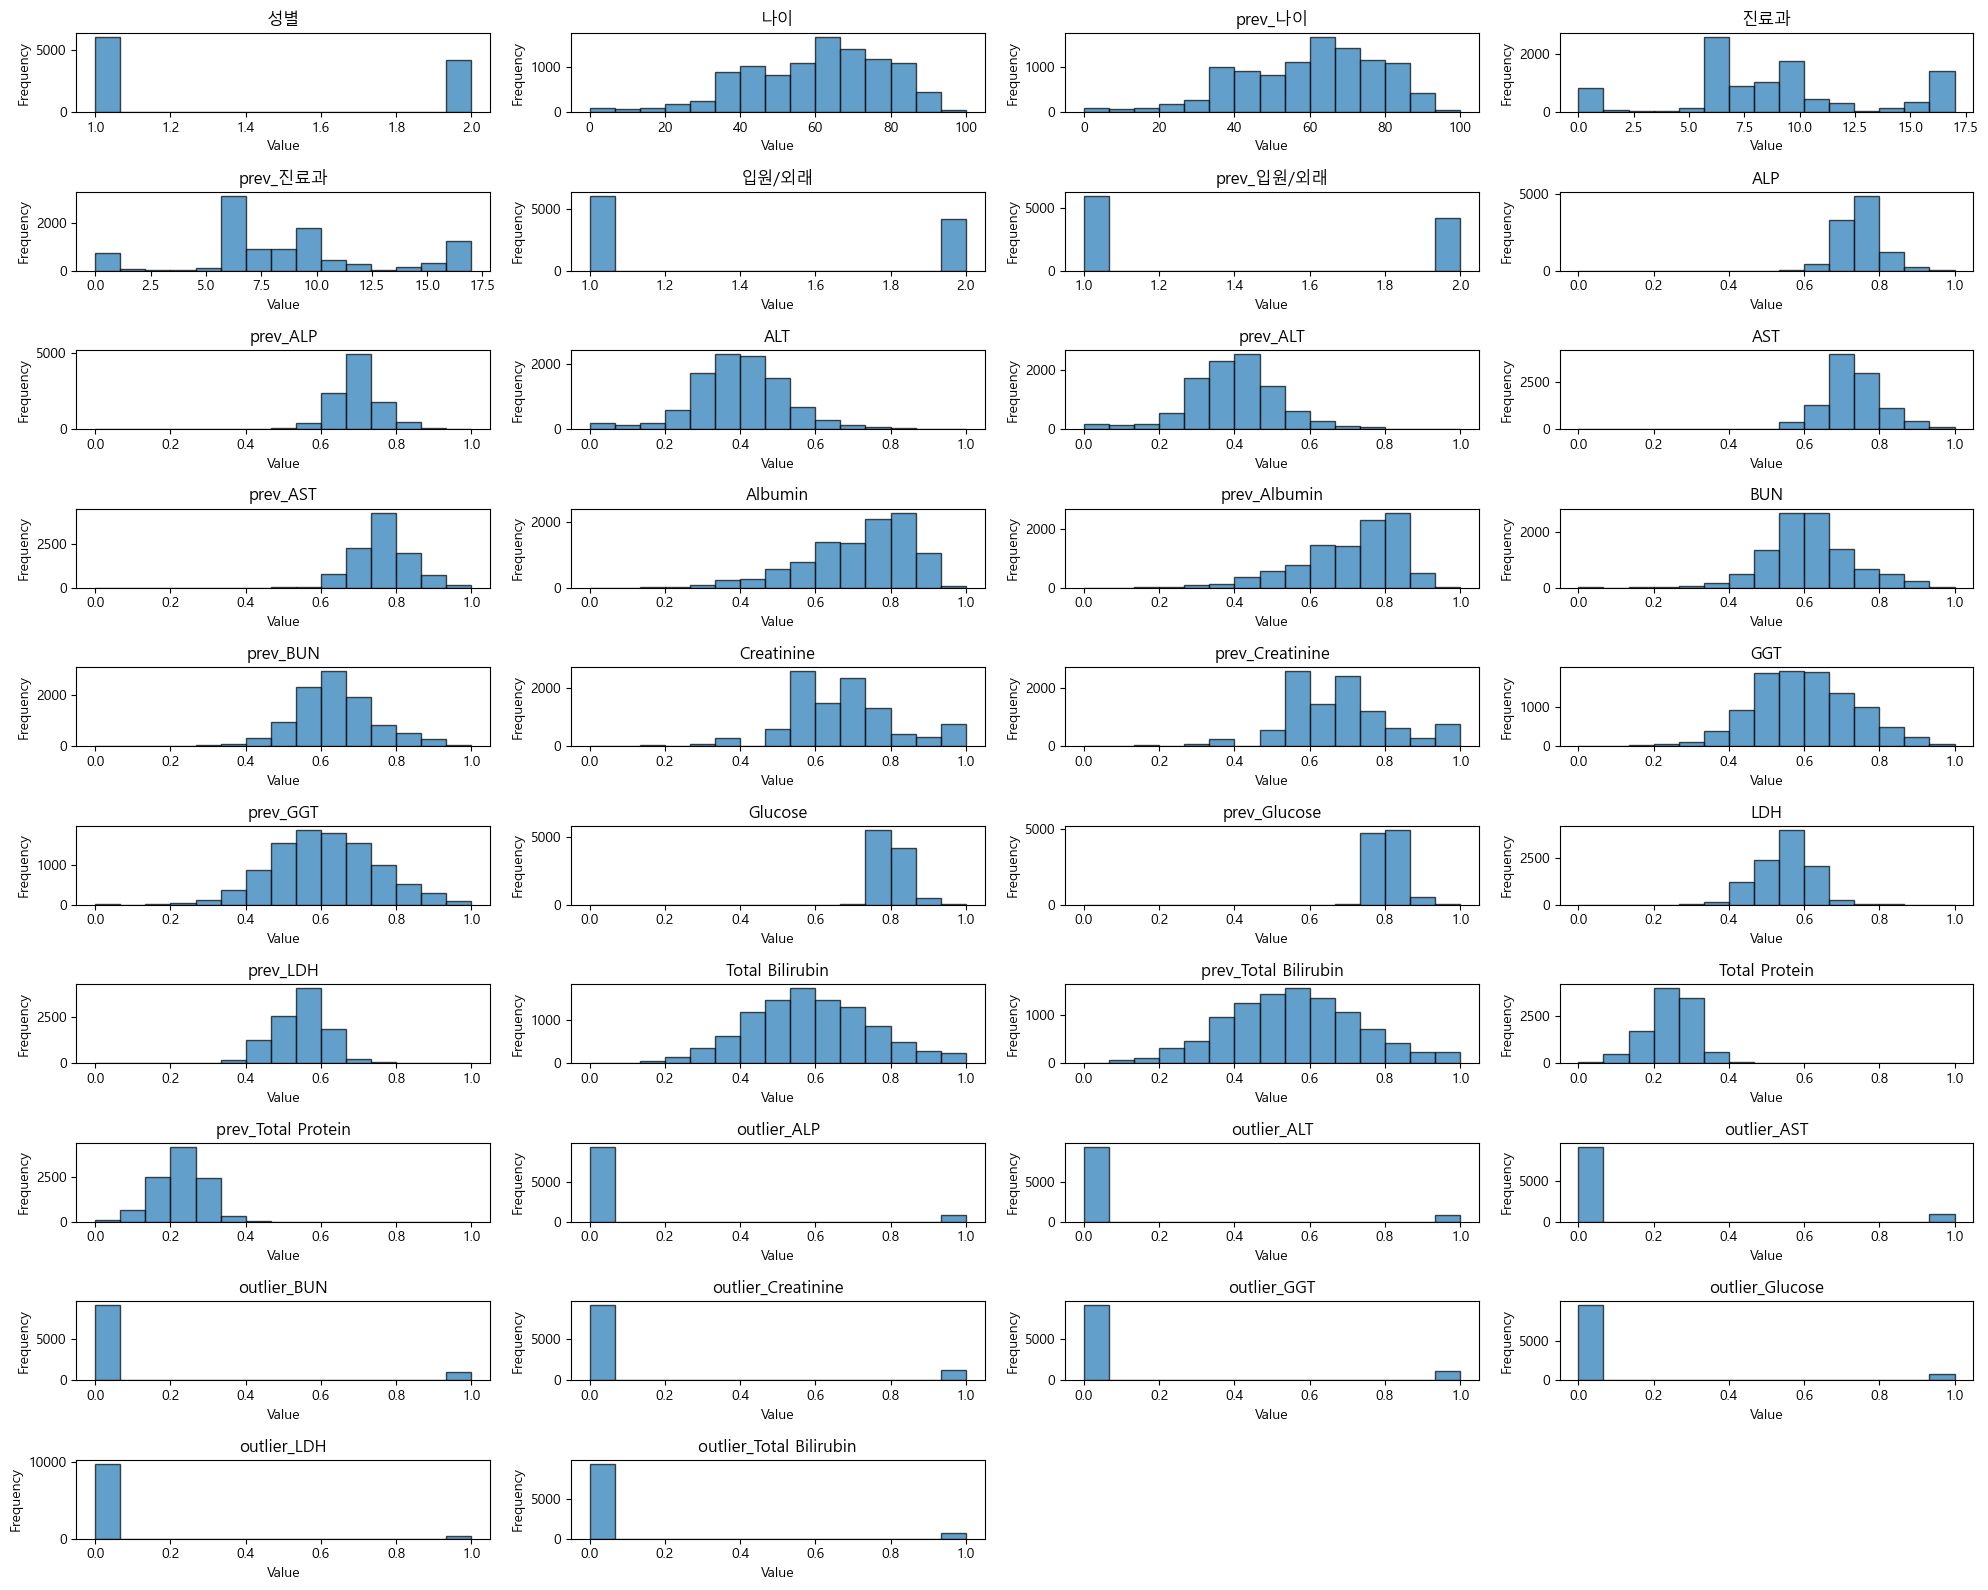

In [295]:
# 데이터 분포 시각화
num_cols = tx.shape[1]
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(20, 16))

for i, col in enumerate(tx.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(tx[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(num_cols, 40):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

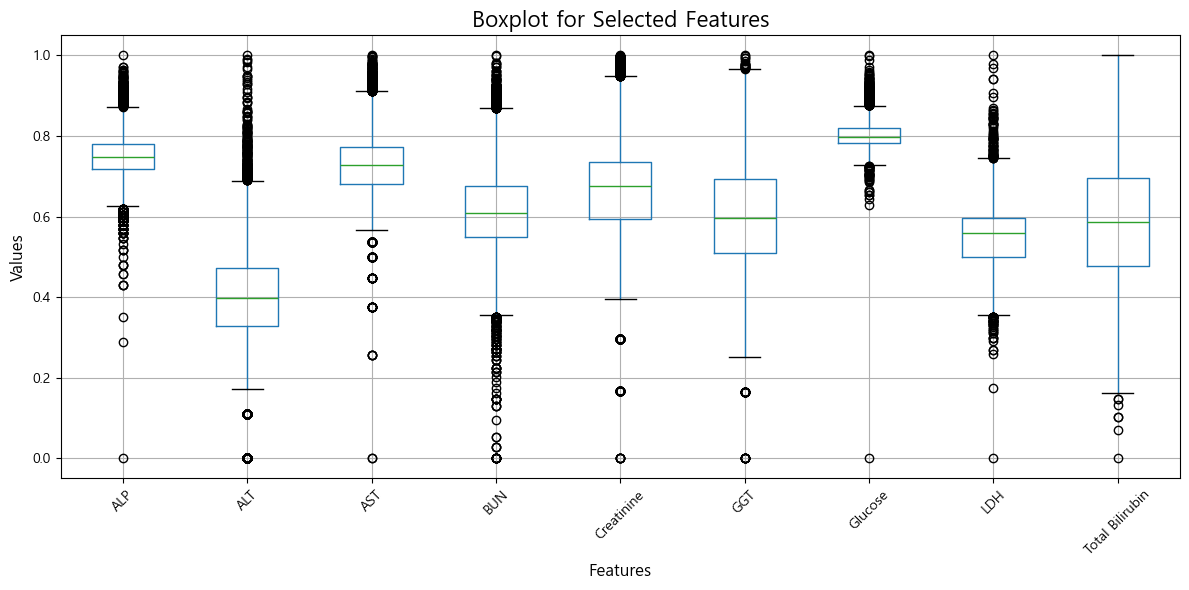

In [296]:
columns_to_plot = ['ALP', 'ALT', 'AST', 'BUN', 'Creatinine', 
                   'GGT', 'Glucose', 'LDH', 'Total Bilirubin']

plt.figure(figsize=(12, 6))
tx[columns_to_plot].boxplot()

plt.title('Boxplot for Selected Features', fontsize=16)
plt.ylabel('Values', fontsize=12)
plt.xlabel('Features', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 변수 생성

- 델타 변수와 변수 간 비율에 해당하는 변수를 생성하여 변수 추가

In [297]:
# 델타 변수 생성
def calculate_delta_percent_change(df, current_columns, prev_columns):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    for current_col, prev_col in zip(current_columns, prev_columns):
        if current_col not in df.columns or prev_col not in df.columns:
            raise KeyError(f"Column {current_col} or {prev_col} does not exist in the DataFrame.")
        df[f'{current_col}_delta_absolute'] = df[current_col] -  df[prev_col]
        df[f'{current_col}_delta_percent'] = np.round((df[current_col] - df[prev_col])/df[prev_col], 2) # 두자리수까지 반올림
    return df

# 변수간 비율에 해당하는 변수 생성
def calculate_ratio_feature(df, ratio_columns1, ratio_columns2):
    if len(ratio_columns1) != len(ratio_columns2):
        raise ValueError("The length of current_columns and prev_columns must be the same.")

    for ratio_col1, ratio_col2 in zip(ratio_columns1, ratio_columns2):
        if ratio_col1 not in df.columns or ratio_col2 not in df.columns:
            raise KeyError(f"Column {ratio_col1} or {ratio_col2} does not exist in the DataFrame.")
        df[f'{ratio_col1}/{ratio_col2}_ratio'] = round(df[ratio_col1] / df[ratio_col2], 2) # 두자리수까지 반올림
    return df   

In [298]:
tx=x[input_str]

for col in tx.columns:
    tx[col] = tx[col].apply(extract_number)

In [299]:
current_columns = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein']
prev_columns = [f'prev_{col}' for col in current_columns]

ratio_columns1 = ['AST', 'AST', 'ALP', 'ALT', 'GGT', 'GGT', 'BUN']
ratio_columns2 = ['ALT', 'ALP', 'ALT', 'LDH', 'ALT', 'ALP', 'Creatinine']

# calculate_delta_percent_change함수로 추가할 변수명 사전 생성
d_cols = [f'{col}_delta_absolute' for col in current_columns]
d_cols2 = [f'{col}_delta_percent' for col in current_columns]

tx=calculate_delta_percent_change(tx, current_columns, prev_columns)
tx=calculate_ratio_feature(tx, ratio_columns1, ratio_columns2)

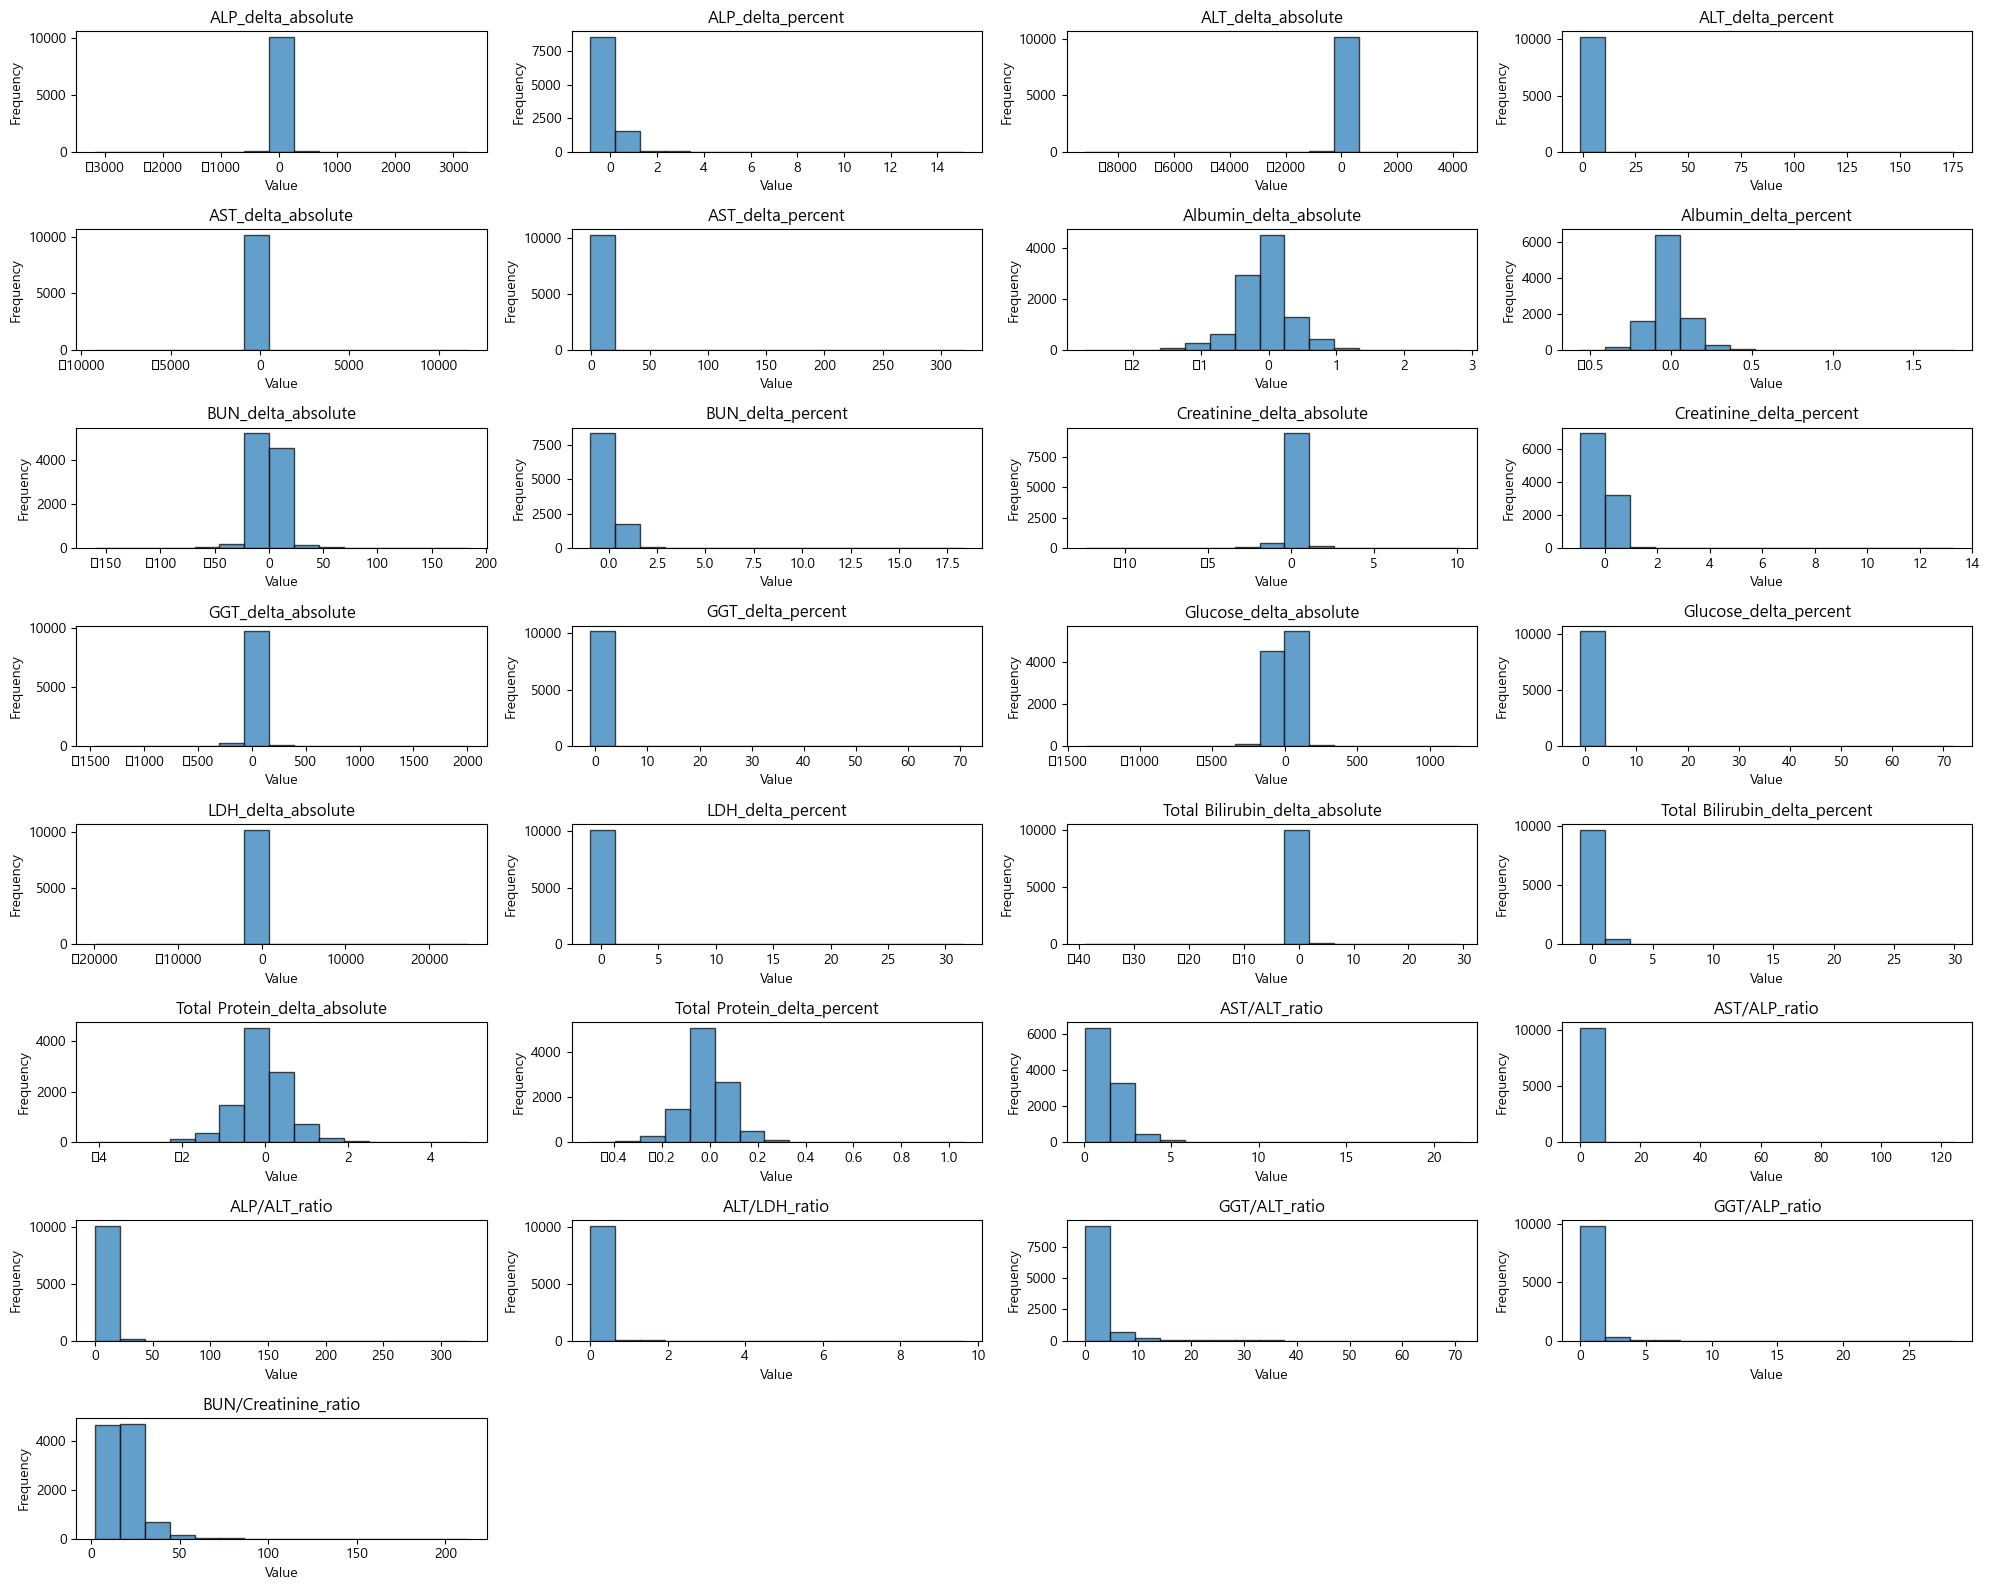

In [300]:
# 데이터 분포 시각화
num_cols = 29
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 16))

for i, col in enumerate(tx.columns[29:]):
    ax = axes[i // 4, i % 4]
    ax.hist(tx[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(num_cols, 32):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

- 생성한 변수들의 분포 또한 대부분 치우쳐져 있음을 확인할 수 있음
- 추후 모델 생성 시 변수 생성 -> 변환 -> 스케일링 순으로 값 변환을 수행하여 분포를 변경

# Data preprocessing

In [301]:
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GroupShuffleSplit, cross_val_score,
    RandomizedSearchCV, KFold
)

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def shuffle_selected_columns_together_df(df, columns, shuffle_ratio, random_state=None):
    """
    Shuffles entire rows of the selected columns in the input DataFrame based on the specified shuffle ratio.
    
    Args:
    df (pandas.DataFrame): The input data DataFrame to be shuffled.
    columns (list of str or int): List of column names or indices to shuffle together.
    shuffle_ratio (float): The fraction of the rows to shuffle (0 < shuffle_ratio <= 1).
    random_state (int, optional): A seed number to make the shuffle deterministic. Default is None.
    
    Returns:
    pandas.DataFrame: The shuffled DataFrame.
    numpy.array: An indicator array where shuffled rows are marked as 1 and others as 0.
    """
    arr = df.copy()
    rng = np.random.RandomState(random_state)
    num_rows_to_shuffle = int(arr.shape[0] * shuffle_ratio)
    shuffle_indices = rng.permutation(arr.shape[0])[:num_rows_to_shuffle]
    
    selected_data = arr.loc[shuffle_indices, columns]
    selected_data = selected_data.sample(frac=1, random_state=random_state)
    arr.loc[shuffle_indices, columns] = selected_data.values
    
    shuffle_indicator = np.zeros(arr.shape[0], dtype=int)
    shuffle_indicator[shuffle_indices] = 1
    
    return arr, shuffle_indicator

def oversampling(X_train: pd.DataFrame, y_train: np.ndarray, smote=False, minority_increase_ratio=1.0):
    """
    Perform oversampling to address class imbalance in training data using pandas DataFrame and numpy array.

    Args:
    X_train (pd.DataFrame): The training feature data.
    y_train (np.ndarray): The corresponding training target labels.
    smote (bool or int): If True, use SMOTE for oversampling. If -1, no oversampling is performed.
                         Any other value triggers random oversampling of the minority class.
    minority_increase_ratio (float): The desired ratio of the number of minority class samples to the
                                     number of majority class samples after oversampling.

    Returns:
    pd.DataFrame: The oversampled training feature data.
    np.ndarray: The corresponding oversampled training target labels.
    """
    if smote:
        # Apply SMOTE
        sm = SMOTE(random_state=42)
        X_train_upsampled, y_train_upsampled = sm.fit_resample(X_train, y_train)
        X_train_upsampled = pd.DataFrame(X_train_upsampled, columns=X_train.columns)
        
    elif smote == -1:
        # No oversampling
        X_train_upsampled = X_train
        y_train_upsampled = y_train
    
    else:
        # Random oversampling
        mask_1 = (y_train == 1)
        mask_0 = (y_train == 0)

        X_train_1 = X_train[mask_1]
        y_train_1 = y_train[mask_1]
        X_train_0 = X_train[mask_0]
        y_train_0 = y_train[mask_0]

        # Determining the number of samples to generate
        desired_samples = int(len(X_train_0) * minority_increase_ratio)
        current_samples = len(X_train_1)
        n_samples = desired_samples - current_samples

        if n_samples > 0:
            # Randomly select samples to duplicate in the minority class
            X_train_1_upsampled = resample(X_train_1, n_samples=n_samples, replace=True, random_state=42)
            y_train_1_upsampled = np.ones(n_samples, dtype=int)

            # Combine the original majority class samples with the upsampled minority class samples
            X_train_upsampled = pd.concat([X_train_0, X_train_1, X_train_1_upsampled], axis=0)
            y_train_upsampled = np.concatenate([y_train_0, y_train_1, y_train_1_upsampled])
        else:
            # If no need for upsampling, just concatenate the data
            X_train_upsampled = pd.concat([X_train_0, X_train_1], axis=0)
            y_train_upsampled = np.concatenate([y_train_0, y_train_1])

    return X_train_upsampled, y_train_upsampled

In [302]:
def extract_number(value):
    match = re.search(r'\d+(\.\d+)?', str(value))
    if match:
        return float(match.group())
    return None

# 이산화 변수 생성
def calculate_outliers(df, current_columns, scalers=None):

    if scalers is None:
        scalers = {}

        for current_col in current_columns:
            Q1 = df[current_col].quantile(0.25)
            Q3 = df[current_col].quantile(0.75)
            IQR = Q3 - Q1  # IQR 계산
            upper_bound = Q3 + 1.5 * IQR  # 상한
            df[f"outlier_{current_col}"] = df[current_col].apply(lambda x: 1 if x > upper_bound else 0)
            scalers[f'{current_col}'] = [Q1, Q3]
    else:
        for current_col in current_columns:
            Q1 = scalers[f'{current_col}'][0]
            Q3 = scalers[f'{current_col}'][1]
            IQR = Q3 - Q1  # IQR 계산
            upper_bound = Q3 + 1.5 * IQR  # 상한
            df[f"outlier_{current_col}"] = df[current_col].apply(lambda x: 1 if x > upper_bound else 0)
            
    return df, scalers

# 델타 변수 생성
def calculate_delta_percent_change(df, current_columns, prev_columns):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    for current_col, prev_col in zip(current_columns, prev_columns):
        if current_col not in df.columns or prev_col not in df.columns:
            raise KeyError(f"Column {current_col} or {prev_col} does not exist in the DataFrame.")
        df[f'{current_col}_delta_absolute'] = df[current_col] -  df[prev_col]
        df[f'{current_col}_delta_percent'] = np.round((df[current_col] - df[prev_col])/df[prev_col], 2) # 두자리수까지 반올림
    return df

# 변수간 비율에 해당하는 변수 생성
def calculate_ratio_feature(df, ratio_columns1, ratio_columns2):
    if len(ratio_columns1) != len(ratio_columns2):
        raise ValueError("The length of current_columns and prev_columns must be the same.")

    for ratio_col1, ratio_col2 in zip(ratio_columns1, ratio_columns2):
        if ratio_col1 not in df.columns or ratio_col2 not in df.columns:
            raise KeyError(f"Column {ratio_col1} or {ratio_col2} does not exist in the DataFrame.")
        df[f'{ratio_col1}/{ratio_col2}_ratio'] = round(df[ratio_col1] / df[ratio_col2], 2) # 두자리수까지 반올림
    return df   

In [303]:
def apply_transformation2(df, current_columns, prev_columns, skew_infos, scalers=None):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    if scalers is None:
        scalers = {}

    # Apply log transformation and add new columns to the DataFrame
    for current_col, prev_col in zip(current_columns, prev_columns):
        if current_col not in df.columns or prev_col not in df.columns:
            raise KeyError(f"Column {current_col} or {prev_col} does not exist in the DataFrame.")

        if skew_infos[current_col] == 'positive': 
            df[f'{current_col}'] = np.log(df[current_col])  # 로그 변환 시 0을 방지하기 위해 +1
            df[f'{prev_col}'] = np.log(df[prev_col])
        elif skew_infos[current_col] == 'negative': 
            df[f'{current_col}'] = boxcox(df[current_col] - df[current_col].min() + 1)[0] # 최소값 보정
            df[f'{prev_col}'] = boxcox(df[prev_col] - df[prev_col].min() + 1)[0]

        if f'{current_col}' not in scalers:
            scalers[f'{current_col}'] = RobustScaler().fit(df[f'{current_col}'].values.reshape(-1, 1)) # 돌아가면서 적용
            # scalers[f'{current_col}'] = MinMaxScaler().fit(df[f'{current_col}'].values.reshape(-1, 1))

        # if f'{prev_col}' not in scalers:
        scalers[f'{prev_col}'] =  scalers[f'{current_col}'] 
    df[f'{current_col}'] = scalers[f'{current_col}'].transform(df[f'{current_col}'].values.reshape(-1, 1)).flatten()
    df[f'{prev_col}'] = scalers[f'{prev_col}'].transform(df[f'{prev_col}'].values.reshape(-1, 1)).flatten()
 
    return df, scalers

def apply_logsc_transformation3(df, current_columns, scalers=None):
    if scalers is None:
        scalers = {}

    # Apply log transformation and add new columns to the DataFrame
    for current_col in current_columns:
        if f'{current_col}' not in scalers:
            scalers[f'{current_col}'] = RobustScaler().fit(df[f'{current_col}'].values.reshape(-1, 1))
        # if f'{prev_col}' not in scalers:
        df[f'{current_col}'] = scalers[f'{current_col}'].transform(df[f'{current_col}'].values.reshape(-1, 1)).flatten()
 
    return df, scalers

In [304]:
x=df_input[['검체번호','환자번호','검사일','성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']]

from datetime import datetime, timedelta
base_date = datetime.strptime('2024-11-01', '%Y-%m-%d')
start_datetime = base_date - timedelta(hours=12)
end_datetime = base_date + timedelta(hours=24+12)  
df_input['검사일_datetime'] = pd.to_datetime(df_input['검사일'])
x_target = x[(df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime)]
x = x[~((df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime))]

tx = x[input_str]

###----------------변수 생성----------------###

for col in tx.columns:
    tx[col] = tx[col].apply(extract_number)

current_columns = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein']
prev_columns = [f'prev_{col}' for col in current_columns]

ratio_columns1 = ['AST', 'AST', 'ALP', 'ALT', 'GGT', 'GGT', 'BUN']
ratio_columns2 = ['ALT', 'ALP', 'ALT', 'LDH', 'ALT', 'ALP', 'Creatinine']

skew_infos = {
    'ALP': 'negative',
    'ALT': 'negative',
    'AST': 'negative',
    'Albumin': 'positive',
    'BUN': 'negative',
    'Creatinine': 'negative',
    'GGT': 'negative',
    'Glucose': 'negative',
    'LDH': 'negative',
    'Total Bilirubin': 'negative',
    'Total Protein': 'negative'
}

# calculate_delta_percent_change함수로 추가할 변수명 사전 생성
d_cols = [f'{col}_delta_absolute' for col in current_columns]
d_cols2 = [f'{col}_delta_percent' for col in current_columns]
d_cols3 = [f'{col1}/{col2}_ratio' for col1, col2 in zip(ratio_columns1, ratio_columns2)]

# train, test 데이터 나누기
subject_ids = x['환자번호'].unique()
train_subjects, test_subjects = train_test_split(subject_ids,test_size=0.2, random_state=111)
x_train = tx[x['환자번호'].isin(train_subjects)]
x_test = tx[x['환자번호'].isin(test_subjects)]

# train데이터 내에서 train, validation 데이터 나누기
x_train, x_val=train_test_split(x_train,stratify=x_train['입원/외래'], test_size = 0.2, random_state=111)
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

# 나눈 데이터에 대해 변수 만들기(train)
x_train,y_train=shuffle_selected_columns_together_df(x_train, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_train=calculate_delta_percent_change(x_train, current_columns, prev_columns)
x_train=calculate_ratio_feature(x_train, ratio_columns1, ratio_columns2)

x_train, out_scaler= calculate_outliers(x_train, current_columns)

x_train,dscalers=apply_logsc_transformation3(x_train, d_cols)
x_train,dscalers2=apply_logsc_transformation3(x_train, d_cols2)
x_train,dscalers3=apply_logsc_transformation3(x_train, d_cols3)

x_train,scalers=apply_transformation2(x_train, current_columns, prev_columns, skew_infos)
x_train, y_train=oversampling(x_train, y_train, smote=False, minority_increase_ratio=1.0)

# 나눈 데이터에 대해 변수 만들기(validation)
x_val,y_val=shuffle_selected_columns_together_df(x_val, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_val=calculate_delta_percent_change(x_val, current_columns, prev_columns)
x_val=calculate_ratio_feature(x_val, ratio_columns1, ratio_columns2)
x_val,_= calculate_outliers(x_val, current_columns, out_scaler)

x_val,_=apply_logsc_transformation3(x_val, d_cols, scalers = dscalers)
x_val,_=apply_logsc_transformation3(x_val, d_cols2, scalers = dscalers2)
x_val,_=apply_logsc_transformation3(x_val, d_cols2, scalers = dscalers3)

x_val,_=apply_transformation2(x_val, current_columns, prev_columns, skew_infos, scalers=scalers)

# 나눈 데이터에 대해 변수 만들기(test)
x_test,y_test=shuffle_selected_columns_together_df(x_test, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_test=calculate_delta_percent_change(x_test, current_columns, prev_columns)
x_test=calculate_ratio_feature(x_test, ratio_columns1, ratio_columns2)
x_test,_= calculate_outliers(x_test, current_columns, out_scaler)

x_test,_=apply_logsc_transformation3(x_test, d_cols, scalers = dscalers)
x_test,_=apply_logsc_transformation3(x_test, d_cols2, scalers = dscalers2)
x_val,_=apply_logsc_transformation3(x_val, d_cols2, scalers = dscalers3)

x_test,_=apply_transformation2(x_test, current_columns, prev_columns, skew_infos, scalers=scalers)

In [305]:
x_train.shape, x_test.shape, x_val.shape

((10420, 69), (2092, 69), (1628, 69))

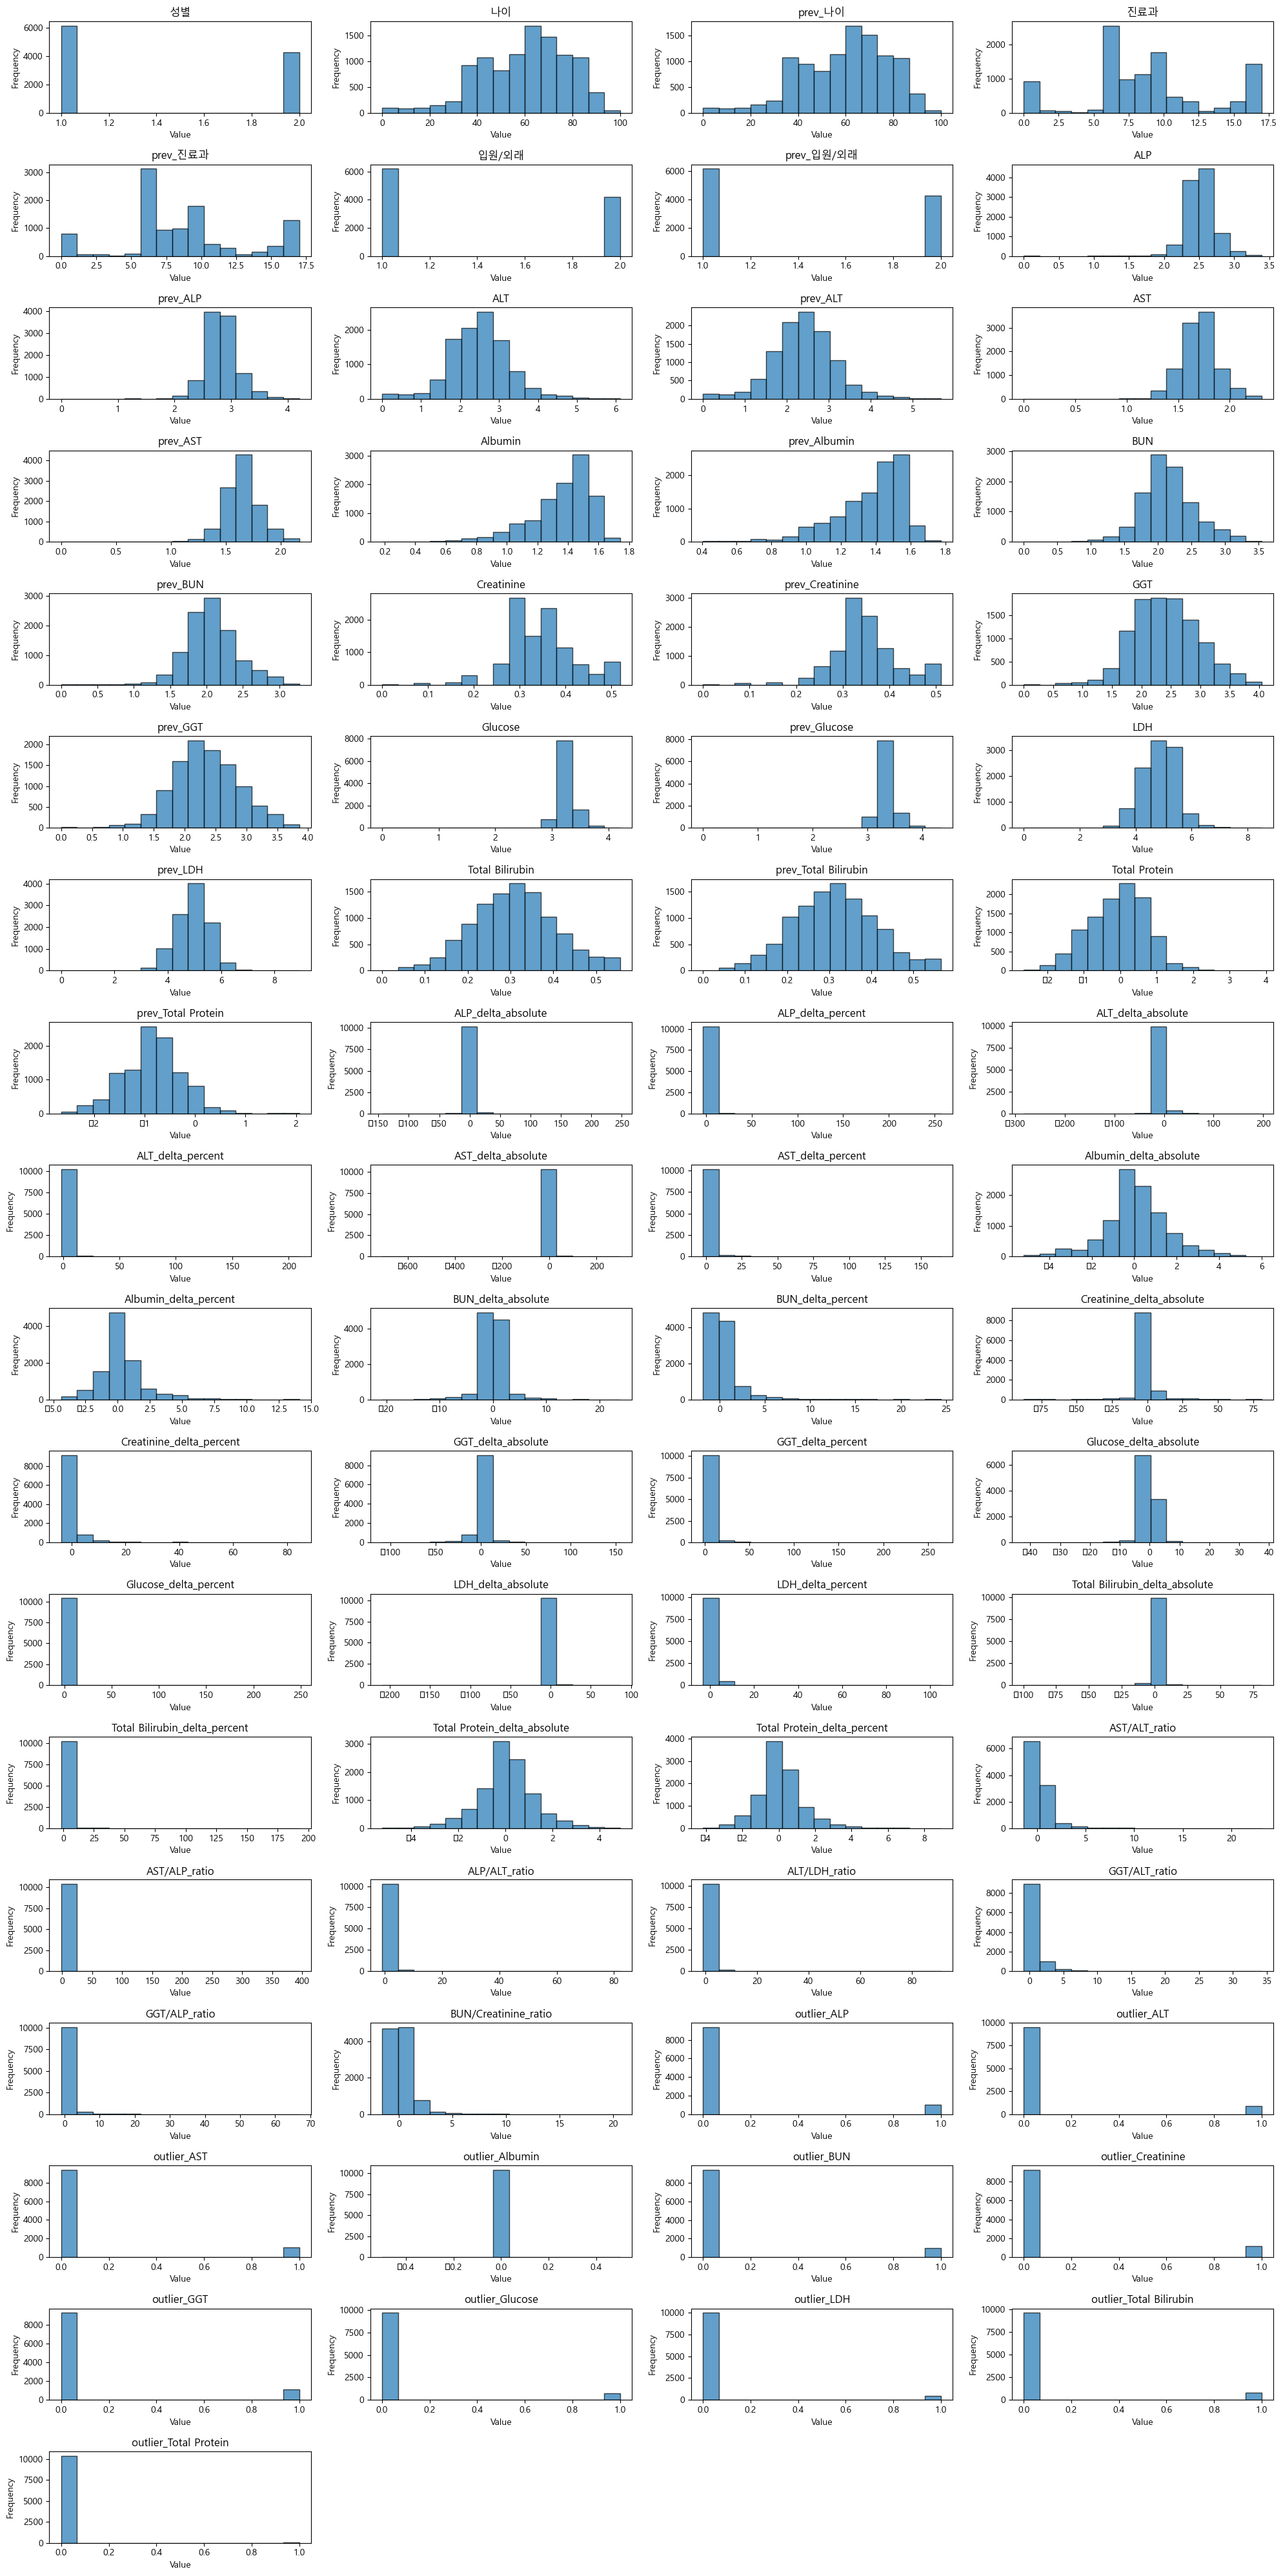

In [306]:
# 데이터 분포 시각화
fig, axes = plt.subplots(nrows=18, ncols=4, figsize=(20, 40))

for i, col in enumerate(x_train.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(x_train[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(69, 72):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

# Model Development
## simple model (XGB, DNN - no hp tuning)
- 원검사결과 데이터 만으로도 분류가 가능하냐?
- 어떤 인코딩 방법이 가장 유리한가?
- 스케일러 적용은 필요한가?
- 새롭게 제안된 feature들 중 어떤게 좋은가?
- 검사결과가 아닌 다른 정보를 가진 변수들은 영향력이 있는가?

# HP tuning metric (Optuna)
## Optimal model development
- 방법적인 구성과 러닝 프로세스
- 심플모델과 성능차이 보여주기

### 하이퍼파라미터 튜닝(Hyperparameter Tuning)

**하이퍼파라미터 튜닝**은 머신러닝 모델의 **성능을 최적화**하기 위해 모델이 학습하는 과정에서 설정하는 **파라미터들**을 조정하는 과정입니다. 하이퍼파라미터는 모델이 학습할 때 **사용자가 직접 설정해야 하는 값들**로, 적절히 조정하지 않으면 모델 성능이 낮아질 수 있습니다.

### 하이퍼파라미터 예시
| **모델**   | **주요 하이퍼파라미터**                                                                                   | **특징**                                                                                 |
|------------|-----------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| **XGBoost**| `learning_rate`, `max_depth`, `n_estimators`, `subsample`, `colsample_bytree`, `lambda`, `alpha`, `gamma` | 결정 트리 기반. 과적합 방지를 위한 정규화와 샘플링 비율이 중요.                          |
| **DNN**    | `number_of_hidden_layers`, `neurons_per_layer`, `learning_rate`, `dropout_rate`, `activation_function`, `L1/L2 regularization` | 은닉층과 뉴런 수 조정이 중요하며, 정규화를 통해 일반화 성능 향상 가능.                   |
| **CNN**    | `filter_size`, `number_of_filters`, `stride`, `padding`, `pooling_type`, `pool_size`, `number_of_conv_layers` | 이미지, 시계열 데이터 특화. 합성곱층과 풀링층 구조 설계가 성능에 직접적인 영향을 미침. |


### 하이퍼파라미터 튜닝 방법
![gridrandomsearch](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/gridrandomsearch-1.png?raw=true)
1. **그리드 서치(Grid Search)**:
   - 그리드 서치는 **모든 하이퍼파라미터의 가능한 값들**을 **조합**하여 가장 좋은 성능을 내는 파라미터를 찾는 방법입니다.
   - 예를 들어, `learning_rate` 값을 0.1, 0.01, 0.001로 시도하고, `max_depth` 값을 3, 5, 7로 시도하여 각 조합을 평가하는 방식입니다.
   - 이 방법은 모든 조합을 테스트트하기 때문에, 파라미터가 많을 경우 계산 시간이 매우 오래 걸려 비효율적입니다.

2. **랜덤 서치(Random Search)**:
   - 그리드 서치와 달리, **하이퍼파라미터를 랜덤으로 선택**하여 최적의 값을 찾는 방법입니다. 모든 조합을 시도하지 않기 때문에 속도가 더 빠르지만, **최적의 조합을 놓칠 수** 있습니다.
   
3. **베이지안 최적화(Bayesian Optimization)**:
   - 이전 실험에서 얻은 결과를 바탕으로 다음 실험에 사용할 하이퍼파라미터 값을 결정하는 방식으로, 점진적으로 최적의 하이퍼파라미터를 찾습니다. 탐색 공간의 확률 모델을 생성하여 기대값이 최대화되는 지점을 샘플링하는 원리입니다.
   

#### 베이지안 최적화

베이지안 최적화의 핵심은 **Surrogate Model**과 **Acquisition Function**을 사용하는 것입니다.

1. Surrogate Model

Surrogate Model은 목표 함수( $f(x)$ )의 실제 계산을 대신해 확률적인 추정을 제공하는 모델입니다. 이는 실제 목적 함수 $f(x)$ 를 평가하는 데 필요한 비용을 줄이기 위해 사용됩니다.

![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian1-1.png?raw=true)![alt text](./https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian6-1.png?raw=true)

입력값 $(x1, f(x1)), (x2, f(x2)), ... , (xt, f(xt))$ 라는 이미 수집된 데이터를 바탕으로, 실제 목표 함수 $f(x)$ 에 대한 확률적인 추정을 합니다.
즉, 실제로 계산할 수 없는 함수의 형태를 예측하는 역할을 합니다.

예시: 하이퍼파라미터 집합과 그에 대응하는 일반화 성능을 모델링한 결과로 생각할 수 있습니다. 이 모델을 통해 하이퍼파라미터의 변화에 따른 성능 변화를 예측할 수 있습니다.

2. Acquisition Function

![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian2-1.png?raw=true)

Acquisition Function은 Surrogate Model의 예측을 바탕으로 다음 탐색할 입력값을 추천하는 함수입니다. 이를 통해 다음 실험을 설계하여 최적값에 가까운 하이퍼파라미터를 찾습니다.

![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian3-1.png?raw=true)

Surrogate Model이 예측한 목표 함수의 추정을 바탕으로, 최적값일 가능성이 높은 값과 불확실성이 큰 값을 구분해 추천합니다.

- 최적값일 가능성이 높은 값: Surrogate Model에서 함수값이 높은 곳.

- 불확실성이 큰 값: Surrogate Model에서 표준편차가 큰 곳.

![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian4-1.png?raw=true)

예시: 다음에 탐색할 하이퍼파라미터 집합을 결정하는 데 사용됩니다. Acquisition Function은 실험을 반복하며 모델의 성능을 개선할 가능성이 높은 하이퍼파라미터를 선택합니다.
    
![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian5-1.png?raw=true)

=> **검은 점선**은 실제 목적 함수, **검은 실선**은 추정한 목적함수(Surrogate Model)를 의미합니다. 파란 영역은 추정된 $σ(x)$, 하단 녹색 실선은 Acquistition Function을 의미합니다.

**Bayesian Optimization의 작동 원리**

1. 초기 하이퍼파라미터 집합과 성능 수집:
    - 초기 하이퍼파라미터 집합에 대해 목표 함수의 성능을 평가하고, 이를 Surrogate Model에 입력하여 모델링합니다.
2. Acquisition Function을 통해 새로운 후보 찾기:
    - Surrogate Model을 통해 예측된 정보를 바탕으로 Acquisition Function을 사용하여 다음 탐색할 하이퍼파라미터를 추천합니다.
3. 다음 실험 수행:
    - 추천된 하이퍼파라미터 집합을 사용하여 실제로 모델을 학습하고 성능을 측정합니다. 이 결과는 새로운 데이터로 추가됩니다.
4. 모델 업데이트:
    - 새로 수집된 하이퍼파라미터 집합과 성능 정보를 Surrogate Model에 업데이트하여, 더 정교한 예측을 할 수 있도록 합니다.
5. 반복:
    - 이 과정을 반복하면서 점점 더 최적의 하이퍼파라미터 집합을 찾아냅니다.



### Optuna란?

**Optuna**는 **하이퍼파라미터 튜닝을 자동화**하는 라이브러리로, **효율적이고 빠른 방법**으로 최적의 하이퍼파라미터를 찾을 수 있게 도와줍니다. Optuna는 베이지안 최적화를 기반으로 하여 **최소화/최대화하려는 목표 함수**를 효율적으로 탐색합니다. 주로 머신러닝 모델을 학습할 때 하이퍼파라미터를 최적화하는 데 사용됩니다.

##### 최적화 과정은 크게 두 가지 주요 메커니즘으로 이루어집니다.

1. 트리 기반의 구조화된 파라미터 최적화 (TPE, Tree-structured Parzen Estimator)

   - TPE는 베이지안 최적화의 일종으로, 이전의 평가 결과를 기반으로 하이퍼 파라미터의 새로운 셋을 제안하며, 랜덤 혹은 그리드 서치보다 효율적으로 탐색합니다.
2. 프루닝 메커니즘

   - 계산 자원의 낭비를 줄이기 위해 비효율적인 트라이얼을 조기에 중단시키는 기술입니다.

### Optuna의 주요 특징:

- **자동화된 하이퍼파라미터 탐색**: 사용자가 설정한 범위 내에서 하이퍼파라미터를 자동으로 탐색하여 **효율적으로 최적의 파라미터를 찾습니다**.

- **다양한 최적화 알고리즘**: Optuna는 **베이지안 최적화**를 사용하여 더 효율적으로 최적의 파라미터를 찾을 수 있습니다.

- **실험 추적 기능**: Optuna는 각 실험을 추적하고 기록하여, 어떤 파라미터 조합이 가장 좋은 성능을 보였는지 쉽게 비교할 수 있습니다.

### Optuna 사용 방법:

1. **목표 함수 정의**:
   - Optuna는 **목표 함수(objective function)** 를 최적화합니다. 이 함수는 하이퍼파라미터를 입력받아, 모델의 성능을 평가한 후 그 결과를 반환합니다.
   
2. **검색 공간 설정**:
   - 튜닝할 하이퍼파라미터와 그 값들의 범위를 설정합니다.

3. **Optuna 최적화 실행**:
   - Optuna가 여러 번의 실험을 실행하면서 각 하이퍼파라미터 조합에 대한 성능을 평가하고, 최적의 값을 찾아냅니다.

### 코드 예제 (Tuning Pipeline)

1. objective Function안에 모델 학습과정을 Wraping하고 Metric을 반환합니다.
2. trial object를 이용해 HyperParmater를 Suggest합니다.(Sampling)
3. study object를 만들고 Optimization을 실행합니다.


```python
    import optuna

    def objective(trial):
        x = trial.suggest_float('x', -10, 10)
        return (x - 2) ** 2

    study = optuna.create_study()
    study.optimize(objective, n_trials=100)
    study.best_params  # E.g. {'x': 2.002108042}
```

<br>
-10~ 10 사이의 Float를 파라미터($x$) 범위로 정의하고, $(x-2)**2$ 이 최소가 될 수 있도록 최적화하는 함수의 예시입니다.

파라미터의 범위는 objective 함수 안에서 입력된 trial method를 이용해 지정할 수 있습니다. 파라미터의 특성에 맞게 suggest method를 고르면 됩니다.

- 대표적인 suggest method
    - suggest_categorical(name, choices) 
    - suggest_float(name, low, high, *, step=None, log=False) 
    - suggest_int(name, low, high, step=1, log=False)

#### 필요한 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import pickle 
import warnings
# Standard library imports
import os
import math
import re
import random
import warnings
from datetime import datetime

# Data manipulation and numeric libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.ndimage as ndimage
from scipy.interpolate import interp1d

# Machine learning and optimization libraries
import joblib
from joblib import dump, load
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, confusion_matrix, precision_score,
    recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, 
    make_scorer, average_precision_score, precision_recall_fscore_support, 
    roc_curve, ConfusionMatrixDisplay
)
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
# from imblearn.over_sampling import SMOTE

# XGBoost library
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# File and plotting libraries
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.io import savemat
from tqdm import tqdm

warnings.filterwarnings('ignore')

## 실행 코드

In [ ]:
def hp_xgb(trial):
    param = {
        'objective': 'binary:logistic',  # 이진 분류 (0 또는 1로 분류)
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),  # 부스팅 방법 선택 ('gbtree' 또는 'dart')
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # L2 정규화 계수 (모델의 과적합을 방지)
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),  # L1 정규화 계수 (모델의 과적합을 방지)
        'learning_rate': trial.suggest_categorical('lr', [0.001, 0.0005, 0.0001]),  # 학습률 (모델을 학습할 때 얼마나 빨리 업데이트할지 결정)
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),  # 데이터 샘플링 비율 (모델이 학습에 사용할 데이터의 비율)
        'max_depth': trial.suggest_int('max_depth', 2, 100),  # 트리의 최대 깊이 (트리 모델의 복잡도를 결정)
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 40),  # 리프 노드에 최소한 있어야 할 샘플의 수
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),  # 트리의 개수
        'tree_method': 'gpu_hist',  # GPU를 이용한 트리 학습 방법
        'predictor': 'gpu_predictor',  # GPU에서 예측을 빠르게 하기 위한 설정
        'gpu_id': -1,  # 사용할 GPU를 지정 (여기서는 -1로 설정하여 GPU를 사용하지 않음)
    }

    model = xgb.XGBClassifier(**param) # 위에서 설정한 하이퍼파라미터를 바탕으로 XGBoost 모델을 생성
    return model

def hp_cnn(trial, input_dim): # input_dim: 모델 입력 데이터의 차원
    # 입력 텐서 정의
    input_tensor = tf.keras.layers.Input(shape=(input_dim, 1)) # 입력 데이터를 처리하기 위한 텐서 정의. 입력 데이터는 1차원 데이터(input_dim, 1) 형식
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)  # 합성곱 레이어의 개수를 1~3 사이에서 탐색
    x = input_tensor # 입력 텐서를 x에 저장해 모델의 시작 지점으로 설정
    for i in range(num_conv_layers): # 지정된 개수(num_conv_layers)만큼 반복해 합성곱 레이어를 추가
        conv_filters = trial.suggest_int('conv_filters_' + str(i), 32, 128, step=32) # 각 합성곱 레이어의 필터 수를 32에서 128까지 32 단위로 탐색
        kernel_size = trial.suggest_int('kernel_size_' + str(i), 1, 3) # 합성곱 필터(커널)의 크기를 1~3 사이에서 탐색
        conv_activation = trial.suggest_categorical('conv_activation_' + str(i), ['relu', 'elu', 'gelu']) # 합성곱 레이어의 활성화 함수를 'relu', 'elu', 'gelu' 중 선택
        x = tf.keras.layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation=conv_activation)(x) # 1D 합성곱 레이어 추가. 샘플링된 필터 수, 커널 크기, 활성화 함수 사용
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x) # MaxPooling으로 크기를 줄여 데이터의 공간적 정보를 압축
    
    x = tf.keras.layers.Flatten()(x) # CNN 레이어 출력 결과를 1차원 벡터로 펼침

    # 동적으로 완전 연결 레이어를 쌓는 부분
    num_dense_layers = trial.suggest_int('num_dense_layers', 2, 7)  # Dense 레이어의 개수를 2~7 사이에서 탐색
    activ_fcn = trial.suggest_categorical('dense_activation', ['relu', 'elu', 'gelu']) # Dense 레이어에서 사용할 활성화 함수를 'relu', 'elu', 'gelu' 중 선택
    for j in range(num_dense_layers):
        units = trial.suggest_int('units_' + str(j), 32, 512, step=32) # 각 Dense 레이어의 뉴런 수를 32~512 사이에서 32 단위로 탐색
        x = tf.keras.layers.Dense(units=units, activation=activ_fcn)(x) # Dense 레이어 추가. 샘플링된 뉴런 수와 활성화 함수 사용
        
        dropout = trial.suggest_categorical('dropout_' + str(j), [True, False]) # 드롭아웃 사용 여부를 True/False로 결정
        if dropout:
            dropout_rate = trial.suggest_float('dropout_rate_' + str(j), 0.1, 0.5, step=0.025) # 드롭아웃 비율을 0.1~0.5 사이에서 0.025 단위로 탐색
            x = tf.keras.layers.Dropout(dropout_rate)(x) # 샘플링된 드롭아웃 비율을 적용

    x = tf.keras.layers.Dense(1, activation='sigmoid')(x) # 출력층. 이진 분류를 위한 시그모이드 활성화 함수 사용
    model = tf.keras.Model(inputs=input_tensor, outputs=x) # 입력과 출력을 연결해 모델 정의
    
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True) # 학습률(learning rate)을 로그 스케일로 1e-5 ~ 1e-2 사이에서 탐색
    model.compile(loss='binary_crossentropy', # 손실 함수: 이진 교차 엔트로피 (binary_crossentropy)
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=[tf.keras.metrics.AUC(name='PR', curve='PR'),
                           tf.keras.metrics.BinaryAccuracy(name='bacc', threshold=0.5),
                           tf.keras.metrics.AUC(curve='ROC')])
    return model


def hp_dnn(trial, input_dim):
    num_layers = trial.suggest_int('num_layers', 2, 10)  # DNN의 은닉층 개수를 2~10 사이에서 탐색
    activ_fcn = trial.suggest_categorical('dense_activation', ['relu', 'elu', 'gelu']) # 은닉층에서 사용할 활성화 함수를 'relu', 'elu', 'gelu' 중 선택
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam','Nadam']) # 최적화 알고리즘을 'Adam' 또는 'Nadam' 중에서 선택
    lr = trial.suggest_categorical('lr', [0.001, 0.005, 0.0005]) # 학습률(learning rate)을 세 가지 고정값 중에서 선택
    input_tensor = tf.keras.layers.Input(shape=(input_dim,)) # 입력 텐서 정의. 입력 데이터는 1D 벡터로 처리됨
    x = input_tensor 
    for i in range(num_layers):
        units = trial.suggest_int(name='units_' + str(i), low=16, high=512, step=16)  # 각 은닉층의 뉴런 수를 16에서 512까지 16 단위로 탐색
        # 은닉층(Dense Layer)을 추가. 샘플링된 뉴런 수, 활성화 함수, 가중치 초기화 방식 사용
        # 가중치 초기화 방식: 'he_normal', 'glorot_uniform', 'lecun_normal' 중 선택
        x = tf.keras.layers.Dense(units=units, activation=activ_fcn,
                                  kernel_initializer=trial.suggest_categorical('kernel_initializer_' + str(i), ['he_normal', 'glorot_uniform', 'lecun_normal']))(x)
        batch_norm = trial.suggest_categorical('batch_' + str(i), [True, False]) # 배치 정규화(Batch Normalization) 적용 여부를 True/False로 결정
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x) # 배치 정규화를 추가해 학습 안정성을 높임
        dropout = trial.suggest_categorical('dropout_' + str(i), [True, False]) # 드롭아웃 적용 여부를 True/False로 결정
        if dropout:
            dropout_rate = trial.suggest_float('dropout_rate_' + str(i), 0.1, 0.5, step=0.1)  # 드롭아웃 비율을 0.1~0.5 사이에서 0.1 단위로 탐색
            x = tf.keras.layers.Dropout(dropout_rate)(x) # 드롭아웃 레이어 추가
        l2_reg = trial.suggest_float('l2_reg_' + str(i), 1e-6, 1e-1, log=True) # L2 정규화 강도를 로그 스케일로 1e-6에서 1e-1 사이에서 탐색
        x = tf.keras.layers.Dense(units=units, activation=activ_fcn, 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x) # 은닉층(Dense Layer)에 L2 정규화를 적용
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # 출력층. 이진 분류를 위한 시그모이드 활성화 함수 사용
    model = tf.keras.Model(inputs=input_tensor, outputs=x) # 입력 텐서와 출력 텐서를 연결해 모델 정의
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'Nadam':
        optimizer = Nadam(learning_rate=lr)
    # else:  # RMSprop
    #     optimizer = RMSprop(learning_rate=lr)
    model.compile(loss='binary_crossentropy', # 손실 함수: 이진 교차 엔트로피(binary_crossentropy)
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='PR', curve='PR'),
                           tf.keras.metrics.BinaryAccuracy(name='bacc', threshold=0.5),
                           tf.keras.metrics.AUC(curve='ROC')])
    return model

def hp_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 1, 100, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 16, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': 'balanced',
        # 'tree_method': 'gpu_hist',
    }    
    model = RandomForestClassifier(**param)
    return model

def hp_lr(trial):
    param = {
#         'C': trial.suggest_loguniform('C',0.001, 100),  
        'penalty': trial.suggest_categorical('penalty', ['none','l2']),
#         'solver': trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']),
        'max_iter': trial.suggest_categorical('max_iter',[100,1000,2500,5000]),
        'class_weight': 'balanced',
    }

# XGBoost

#### 앙상블(Ensemble) 기법
- 여러 개의 **약한 개별 모델을 결합**하여 **하나의 강력한 모델**을 구성하는 기법입니다
- Bagging, Boosting이 이에 해당합니다
    - Bagging : 샘플을 여러 번 뽑아 모델을 학습시켜 결과를 집계(Aggregating), 대표적으로 **Random Forest**가 있습니다
    - Boosting : 이전 모델의 오답에 대해 높은 가중치를 부여하여 다음 모델을 학습, 대표적으로 **XGBoost**가 있습니다
<br/> <br/>
![RF_vs_XGB](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/RF_vs_XGB.png?raw=true)

- Random Forest는 모델 학습 시 랜덤하게 변수를 선택해 노드를 지정하고 분기해 나아갑니다
    - Bagging 과정 간 모델은 의사 결정 나무(Decision Tree)로 구성되어 있습니다
    - 각각의 나무들은 변수를 랜덤하게 선택하였기 때문에 나무 간 상관성을 줄여 예측력을 향상시킬 수 있습니다
    - 각 나무들의 결과를 종합하여 많이 나온 경우(voting)이나 평균(averaging)을 한 결과를 사용합니다
<br/> <br/>
- XGBoost는 이전 모델의 결과와 정답의 차이(Gradient)를 보고 이를 최소화 하는 방향으로 다음 모델의 학습을 진행합니다
- 빨간색 점이 정답이고 현재 분류 기준이 파란 선일 때 다음 모델은 두 값의 차이(잔차)를 계산하여 이를 최소화 할 수 있는 방향으로 분류 기준을 갱신합니다
<br/> <br/>
![gradient_boosting](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/gradient_boosting.png?raw=true)

In [319]:


def hp_xgb(trial):
    param = {
        'objective': 'binary:logistic',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_categorical('lr',[0.001, 0.0005, 0.0001]), #1e-4
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 40),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'gpu_id': -1,
        'eval_metric' : trial.suggest_categorical('eval_metric', ['error', 'aucpr']),
        'early_stopping_rounds' : 100,
        'verbose' : 0,
    }
    model = xgb.XGBClassifier(**param)
    return model


def predict_score(model, x, y, print_results=True, deep_model=False, batch_size= 256):
    """
    Predicts the score for the given model and data.
    
    Args:
    - model: Trained model.
    - x: Input data.
    - y: True labels.
    - print_results: Whether to print the results.
    - deep_model: Indicates the type of model (True for deep learning models, False for others, -1 for special case).
    
    Returns:
    - probs: Predicted probabilities.
    - metrics: List of [tp, tn, fp, fn].
    - scores: List of [auc, auprc, acc, sens, sp, ppv, npv].
    """
    
    # Predict probabilities based on the model type
    if deep_model == True:
        probs = model.predict(x, verbose=0, batch_size = batch_size)[:, 0]
    elif deep_model == -1:
        reconstruction_error = np.square(x[:, 0] - model.predict_proba(x)[:, 1])
        probs = 1 - stats.norm.cdf(reconstruction_error)
    else:
        probs = model.predict_proba(x)[:, 1]
    
    # Convert probabilities to binary predictions
    preds = (probs > 0.5).astype('int32')
    
    # Compute confusion matrix values
    tp = np.sum((preds == 1) & (y == 1))
    tn = np.sum((preds == 0) & (y == 0))
    fp = np.sum((preds == 1) & (y == 0))
    fn = np.sum((preds == 0) & (y == 1))
    
    # Compute metrics
    auc = 1 if np.unique(y).size == 1 else roc_auc_score(y, probs)
    auprc = auprc_scoring(y, probs)
    npv = tn / (tn + fn)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    sp = tn / (tn + fp) if (tn + fp) > 0 else 0
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    acc = (sp + sens) / 2

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
        
    # Print results if required
    if print_results:
        print(f'AUC: {auc:.4f}, AUPRC: {auprc:.4f}, Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}, Specificity: {sp:.4f}, NPV: {npv:.4f}, PPV: {ppv:.4f}, F1: {f1:.4f}')
    
    return probs, [tp, tn, fp, fn], [auc, auprc, acc, sens, sp, npv, ppv,f1]

def duplicate_single_occurrences(x_train, y_train, c_train):
    value_counts = c_train.value_counts()
    single_value_classes = value_counts[value_counts == 1].index
    indices_to_duplicate = c_train[c_train.isin(single_value_classes)].index
    x_train_duplicates = x_train.loc[indices_to_duplicate]
    y_train_duplicates = y_train.loc[indices_to_duplicate]
    c_train_duplicates = c_train.loc[indices_to_duplicate]

    x_train_updated = pd.concat([x_train, x_train_duplicates]).reset_index(drop=True)
    y_train_updated = pd.concat([y_train, y_train_duplicates]).reset_index(drop=True)
    c_train_updated = pd.concat([c_train, c_train_duplicates]).reset_index(drop=True)
    
    return x_train_updated, y_train_updated, c_train_updated

def auprc(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, _ = precision_recall_curve(labels, preds)
    score = auc(recall, precision)
    return 'auprc', score

def auprc_scoring(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    return auc(recall, precision)

def eval_balanced_accuracy(preds, labels):
    return 'bal_acc', balanced_accuracy_score(labels, preds)

def bappv(preds, labels):
    return (4*precision_score(labels,preds)+balanced_accuracy_score(labels,preds))/5
def f1(preds, labels):
    return f1_score(labels, preds)

def bappv_scoring(preds, labels):
    return 'bappv', (4*precision_score(labels,preds)+balanced_accuracy_score(labels,preds))/5

### 코드 설명

1. Class weights 및 Early Stopping 설정

- `compute_class_weight`: 클래스 불균형을 처리하기 위해 각 클래스에 대한 가중치를 계산합니다.

- `class_weight='balanced'`: 각 클래스의 샘플 비율에 반비례하는 가중치를 설정해주어, 학습 시 **클래스 불균형을 고려**할 수 있게 합니다.

- `early_stopping_cb`: **Early Stopping** 콜백을 설정하여, 모델 학습 도중 더 이상 성능 향상이 없으면 학습을 조기에 멈추게 합니다.
`patience=100`은 100번의 epoch 동안 개선되지 않으면 학습을 멈추고, `restore_best_weights=True`는 학습을 멈출 때 가장 좋은 성능을 보였던 모델의 가중치를 복원합니다.


2. Objective 함수 정의

- `objective(trial)`: 이 함수는 Optuna가 하이퍼파라미터 튜닝을 위해 호출하는 함수입니다. 이 함수는 각 실험에서 모델을 학습시키고, 성능을 평가하여 최적의 하이퍼파라미터 값을 찾습니다.
    - `hp_xgb(trial)` 함수는 **XGBoost** 모델을 생성하며, trial 객체는 Optuna가 추천한 하이퍼파라미터 값을 전달받습니다.
    - `model.fit()`을 사용해 훈련 데이터(x_train, y_train)를 사용하여 모델을 학습합니다. eval_set은 모델을 검증할 데이터셋(x_val, y_val)을 지정하며, Early Stopping을 사용하여 성능 향상이 없으면 학습을 조기에 멈추도록 합니다.
    - `preds = model.predict(x_val)`는 검증 데이터셋에 대한 예측 결과를 얻고, f1(y_val, preds)를 통해 F1-score를 계산하여 모델의 성능을 평가합니다.


3. 최적의 파라미터로 모델 학습

- `best_trial = study.best_trial`: Optuna는 여러 하이퍼파라미터 조합을 실험한 후, 가장 좋은 성능을 낸 최적의 하이퍼파라미터 설정을 study.best_trial로 반환합니다.
- `best_model = hp_xgb(best_trial)`: 최적의 하이퍼파라미터 값을 기반으로 XGBoost 모델을 생성합니다.
- `best_model.fit()`: 훈련 데이터(x_train, y_train)로 최적화된 모델을 학습시키고, 검증 데이터(x_val, y_val)를 사용하여 학습을 진행합니다.


4. 최적 모델 평가 및 예측

- probs: 예측 확률
- cm: 혼동 행렬 (Confusion Matrix)
- scores: 성능 지표 (예: F1-score, 정확도 등)
- print_results=True로 설정하여 예측 결과를 콘솔에 출력합니다.

In [321]:
# HP tuning ----------------------
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_val)
class_weights = dict(zip(np.array([0, 1]), weights))   
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

# HP tuning ----------------------
def objective(trial):
    model = []
    model = hp_xgb(trial)
    model.fit(x_train, y_train,
          eval_set = [(x_train,y_train), (x_val,y_val)])
    preds = model.predict(x_val)
    # print('AUROC : ', roc_auc_score(y_val, preds[:,1]))
    return f1(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 3, show_progress_bar=True)

# model training ----------------------
best_trial=study.best_trial
best_model=hp_xgb(best_trial)
best_model.fit(x_train, y_train,
                 eval_set=[(x_train, y_train), (x_val, y_val)])    
probs, cm, scores = predict_score(best_model, x_test, y_test, print_results=True)

[I 2024-12-02 17:05:27,090] A new study created in memory with name: no-name-e84c85cb-23f8-45fa-9329-ad207652c1a0
  0%|          | 0/3 [00:00<?, ?it/s]

[0]	validation_0-error:0.15067	validation_1-error:0.16646
[1]	validation_0-error:0.12073	validation_1-error:0.15049
[2]	validation_0-error:0.11286	validation_1-error:0.13391
[3]	validation_0-error:0.11401	validation_1-error:0.13636
[4]	validation_0-error:0.11315	validation_1-error:0.13452
[5]	validation_0-error:0.11459	validation_1-error:0.13759
[6]	validation_0-error:0.11027	validation_1-error:0.13575
[7]	validation_0-error:0.11017	validation_1-error:0.13882
[8]	validation_0-error:0.10672	validation_1-error:0.13145
[9]	validation_0-error:0.10374	validation_1-error:0.12715
[10]	validation_0-error:0.10441	validation_1-error:0.12162
[11]	validation_0-error:0.10384	validation_1-error:0.12408
[12]	validation_0-error:0.10413	validation_1-error:0.12592
[13]	validation_0-error:0.10643	validation_1-error:0.12654
[14]	validation_0-error:0.10240	validation_1-error:0.12224
[15]	validation_0-error:0.10125	validation_1-error:0.12408
[16]	validation_0-error:0.10058	validation_1-error:0.12224
[17]	va

Best trial: 0. Best value: 0.748705:  33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

[I 2024-12-02 17:05:28,048] Trial 0 finished with value: 0.7487046632124352 and parameters: {'booster': 'gbtree', 'lambda': 0.1421407399246977, 'alpha': 0.012106669154361791, 'lr': 0.0001, 'subsample': 0.20277424409497513, 'max_depth': 78, 'min_child_weight': 6, 'n_estimators': 170, 'eval_metric': 'error'}. Best is trial 0 with value: 0.7487046632124352.
[0]	validation_0-aucpr:0.93897	validation_1-aucpr:0.74567
[1]	validation_0-aucpr:0.95138	validation_1-aucpr:0.76334
[2]	validation_0-aucpr:0.95659	validation_1-aucpr:0.77076
[3]	validation_0-aucpr:0.95825	validation_1-aucpr:0.78078
[4]	validation_0-aucpr:0.96041	validation_1-aucpr:0.78439
[5]	validation_0-aucpr:0.96238	validation_1-aucpr:0.78265
[6]	validation_0-aucpr:0.96266	validation_1-aucpr:0.78890
[7]	validation_0-aucpr:0.96317	validation_1-aucpr:0.79111
[8]	validation_0-aucpr:0.96340	validation_1-aucpr:0.79399
[9]	validation_0-aucpr:0.96343	validation_1-aucpr:0.79054
[10]	validation_0-aucpr:0.96398	validation_1-aucpr:0.79168
[11]

Best trial: 0. Best value: 0.748705:  67%|██████▋   | 2/3 [01:08<00:39, 39.85s/it]

[I 2024-12-02 17:06:35,124] Trial 1 finished with value: 0.7303225806451613 and parameters: {'booster': 'dart', 'lambda': 0.00031929349361687226, 'alpha': 5.7920269281028874e-06, 'lr': 0.0001, 'subsample': 0.5944515805627011, 'max_depth': 27, 'min_child_weight': 16, 'n_estimators': 910, 'eval_metric': 'aucpr'}. Best is trial 0 with value: 0.7487046632124352.
[0]	validation_0-aucpr:0.91364	validation_1-aucpr:0.73254
[1]	validation_0-aucpr:0.92792	validation_1-aucpr:0.74130
[2]	validation_0-aucpr:0.94499	validation_1-aucpr:0.77677
[3]	validation_0-aucpr:0.94844	validation_1-aucpr:0.78038
[4]	validation_0-aucpr:0.94891	validation_1-aucpr:0.77433
[5]	validation_0-aucpr:0.94856	validation_1-aucpr:0.77788
[6]	validation_0-aucpr:0.94847	validation_1-aucpr:0.77699
[7]	validation_0-aucpr:0.94797	validation_1-aucpr:0.77992
[8]	validation_0-aucpr:0.94853	validation_1-aucpr:0.78240
[9]	validation_0-aucpr:0.94799	validation_1-aucpr:0.78079
[10]	validation_0-aucpr:0.95030	validation_1-aucpr:0.78256


Best trial: 0. Best value: 0.748705: 100%|██████████| 3/3 [01:08<00:00, 22.89s/it]

[I 2024-12-02 17:06:35,776] Trial 2 finished with value: 0.6950354609929078 and parameters: {'booster': 'gbtree', 'lambda': 3.380592321132084e-07, 'alpha': 0.20240034007208474, 'lr': 0.0001, 'subsample': 0.5930180921828108, 'max_depth': 44, 'min_child_weight': 29, 'n_estimators': 770, 'eval_metric': 'aucpr'}. Best is trial 0 with value: 0.7487046632124352.
[0]	validation_0-error:0.15067	validation_1-error:0.16646
[1]	validation_0-error:0.12073	validation_1-error:0.15049
[2]	validation_0-error:0.11286	validation_1-error:0.13391
[3]	validation_0-error:0.11401	validation_1-error:0.13636
[4]	validation_0-error:0.11315	validation_1-error:0.13452
[5]	validation_0-error:0.11459	validation_1-error:0.13759
[6]	validation_0-error:0.11027	validation_1-error:0.13575
[7]	validation_0-error:0.11017	validation_1-error:0.13882
[8]	validation_0-error:0.10672	validation_1-error:0.13145
[9]	validation_0-error:0.10374	validation_1-error:0.12715
[10]	validation_0-error:0.10441	validation_1-error:0.12162
[1

[29]	validation_0-error:0.10010	validation_1-error:0.12408
[30]	validation_0-error:0.10019	validation_1-error:0.12346
[31]	validation_0-error:0.10125	validation_1-error:0.12408
[32]	validation_0-error:0.10192	validation_1-error:0.12469
[33]	validation_0-error:0.10259	validation_1-error:0.12531
[34]	validation_0-error:0.10192	validation_1-error:0.12531
[35]	validation_0-error:0.10298	validation_1-error:0.12592
[36]	validation_0-error:0.10250	validation_1-error:0.12592
[37]	validation_0-error:0.10240	validation_1-error:0.12592
[38]	validation_0-error:0.10144	validation_1-error:0.12346
[39]	validation_0-error:0.10134	validation_1-error:0.12408
[40]	validation_0-error:0.10221	validation_1-error:0.12592
[41]	validation_0-error:0.10240	validation_1-error:0.12715
[42]	validation_0-error:0.10278	validation_1-error:0.12654
[43]	validation_0-error:0.10240	validation_1-error:0.12776
[44]	validation_0-error:0.10134	validation_1-error:0.12654
[45]	validation_0-error:0.10211	validation_1-error:0.125

In [ ]:
x=df_input[['검체번호','환자번호','검사일','성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']]

from datetime import datetime, timedelta
base_date = datetime.strptime('2024-11-01', '%Y-%m-%d')
start_datetime = base_date - timedelta(hours=12)
end_datetime = base_date + timedelta(hours=24+12)  
df_input['검사일_datetime'] = pd.to_datetime(df_input['검사일'])
x_target = x[(df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime)]
x = x[~((df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime))]

tx = x[input_str]

###----------------변수 생성----------------###

for col in tx.columns:
    tx[col] = tx[col].apply(extract_number)

current_columns = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein']
prev_columns = [f'prev_{col}' for col in current_columns]

ratio_columns1 = ['AST', 'AST', 'ALP', 'ALT', 'GGT', 'GGT', 'BUN']
ratio_columns2 = ['ALT', 'ALP', 'ALT', 'LDH', 'ALT', 'ALP', 'Creatinine']

skew_infos = {
    'ALP': 'negative',
    'ALT': 'negative',
    'AST': 'negative',
    'Albumin': 'positive',
    'BUN': 'negative',
    'Creatinine': 'negative',
    'GGT': 'negative',
    'Glucose': 'negative',
    'LDH': 'negative',
    'Total Bilirubin': 'negative',
    'Total Protein': 'negative'
}

# calculate_delta_percent_change함수로 추가할 변수명 사전 생성
d_cols = [f'{col}_delta_absolute' for col in current_columns]
d_cols2 = [f'{col}_delta_percent' for col in current_columns]
d_cols3 = [f'{col1}/{col2}_ratio' for col1, col2 in zip(ratio_columns1, ratio_columns2)]

# train, test 데이터 나누기
subject_ids = x['환자번호'].unique()
train_subjects, test_subjects = train_test_split(subject_ids,test_size=0.2, random_state=111)
x_train = tx[x['환자번호'].isin(train_subjects)]
x_test = tx[x['환자번호'].isin(test_subjects)]

# train데이터 내에서 train, validation 데이터 나누기
x_train, x_val=train_test_split(x_train,stratify=x_train['입원/외래'], test_size = 0.2, random_state=111)
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

# 나눈 데이터에 대해 변수 만들기(train)
x_train,y_train=shuffle_selected_columns_together_df(x_train, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_train=calculate_delta_percent_change(x_train, current_columns, prev_columns)
x_train=calculate_ratio_feature(x_train, ratio_columns1, ratio_columns2)

x_train, out_scaler= calculate_outliers(x_train, current_columns)

x_train,dscalers=apply_logsc_transformation3(x_train, d_cols)
x_train,dscalers2=apply_logsc_transformation3(x_train, d_cols2)
x_train,dscalers3=apply_logsc_transformation3(x_train, d_cols3)

x_train,scalers=apply_transformation2(x_train, current_columns, prev_columns, skew_infos)
x_train, y_train=oversampling(x_train, y_train, smote=False, minority_increase_ratio=1.0)

In [329]:
tx_target = x_target[input_str]

def extract_number(value):
    match = re.search(r'\d+(\.\d+)?', str(value))
    if match:
        return float(match.group())
    return None

for col in tx_target.columns:
    tx_target[col] = tx_target[col].apply(extract_number)

tx_target=calculate_delta_percent_change(tx_target, current_columns, prev_columns)
tx_target=calculate_ratio_feature(tx_target, ratio_columns1, ratio_columns2)

tx_target,_= calculate_outliers(tx_target, current_columns)

tx_target,_=apply_logsc_transformation3(tx_target, d_cols)
tx_target,_=apply_logsc_transformation3(tx_target, d_cols2)
tx_target,_=apply_logsc_transformation3(tx_target, d_cols3)

probs = best_model.predict_proba(tx_target)[:, 1]
preds = (probs > 0.5).astype('int32')

results=pd.DataFrame()
results['SampleID'] = x_target['검체번호'].reset_index(drop=True)
results['Mixed'] = np.where(preds == 1, 'O', 'X')
results_expanded = pd.merge(final_df[['검체번호']], results[['SampleID', 'Mixed']], left_on='검체번호', right_on='SampleID', how='left')
results_expanded['Mixed'] = np.where(results_expanded['Mixed'].isna(), 'X', results_expanded['Mixed'])
results_expanded = results_expanded.drop(columns=['SampleID'])
results_expanded.columns = ['SampleID','Mixed']
display(results_expanded)
print(np.sum(results_expanded['Mixed']=='O'))
csv_file_path = 'results_XGB_fin.csv'
results_expanded.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

,SampleID,Mixed
0,0LMV73ZUX,X
1,EVE6NNR3L,X
2,G2MCGEFYW,X
3,506HFY625,X
4,JGE6BYYQH,X
...,...,...
21965,G94WFQNCF,X
21966,95IWGRJ2Q,X
21967,YTVT6RVNM,X
21968,1V4P1YYDN,X


1054


In [324]:
probs

array([0.49714878, 0.49919415, 0.50077164, ..., 0.4988918 , 0.49718314,
       0.49715778], dtype=float32)

In [326]:
# x_target = x[(df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime)]
# x = x[~((df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime))]
# 즉 전체 데이터에 대해 predict 진행
tx = x[input_str]

for col in tx.columns:
    tx[col] = tx[col].apply(extract_number)

tx=calculate_delta_percent_change(tx, current_columns, prev_columns)
tx=calculate_ratio_feature(tx, ratio_columns1, ratio_columns2)

tx,_= calculate_outliers(tx, current_columns)

tx,_=apply_logsc_transformation3(tx, d_cols)
tx,_=apply_logsc_transformation3(tx, d_cols2)
tx,_=apply_logsc_transformation3(tx, d_cols3)

probs = best_model.predict_proba(tx)[:, 1]
preds = (probs > 0.5).astype('int32')

results2=pd.DataFrame()
results2['SampleID'] = x['검체번호'].reset_index(drop=True)
results2['Mixed'] = np.where(preds == 1, 'O', 'X')
print(np.sum(results2['Mixed']=='O'))

2046


In [327]:
results_combined = pd.concat([results, results2], axis=0)
results_expanded = pd.merge(final_df[['검체번호']], results_combined[['SampleID', 'Mixed']], left_on='검체번호', right_on='SampleID', how='left')
results_expanded['Mixed'] = np.where(results_expanded['Mixed'].isna(), 'X', results_expanded['Mixed'])
results_expanded = results_expanded.drop(columns=['SampleID'])
results_expanded.columns = ['SampleID','Mixed']
display(results_expanded)
print(np.sum(results_expanded['Mixed']=='O'))
csv_file_path = 'results_xgb_240905_forsubmit2.csv'
results_expanded.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

,SampleID,Mixed
0,0LMV73ZUX,X
1,EVE6NNR3L,O
2,G2MCGEFYW,X
3,506HFY625,X
4,JGE6BYYQH,X
...,...,...
21965,G94WFQNCF,X
21966,95IWGRJ2Q,X
21967,YTVT6RVNM,X
21968,1V4P1YYDN,X


3100


In [ ]:
# results=pd.DataFrame()
# results['SampleID'] = x_target['검체번호'].reset_index(drop=True)
# results['Mixed'] = np.where(preds == 1, 'O', 'X')
# results_expanded = pd.merge(final_df[['검체번호']], results[['SampleID', 'Mixed']], left_on='검체번호', right_on='SampleID', how='left')
# results_expanded['Mixed'] = np.where(results_expanded['Mixed'].isna(), 'X', results_expanded['Mixed'])
# results_expanded = results_expanded.drop(columns=['SampleID'])
# results_expanded.columns = ['SampleID','Mixed']
# display(results_expanded)
# print(np.sum(results_expanded['Mixed']=='O'))
# csv_file_path = 'results_xgb_240905_forsubmit.csv'
# results_expanded.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

In [354]:
def evaluate_predictions(df_result):
    """
    Compare AI-generated predictions (df_result) with true labels (df_E_set)
    and print various evaluation metrics.
    
    Parameters:
        df_result (pd.DataFrame): AI-generated predictions with columns ['검체번호', 'Label'].
    """
    # for Evaluation 
    df_E_set=pd.read_csv('test_label.csv')
    display(df_E_set)
    
    merged_df = pd.merge(df_E_set, df_result, on='검체번호', suffixes=('_true', '_pred'))
    
    # 정답(Label_true)과 예측(Label_pred) 추출
    y_true = merged_df['Label_true']
    y_pred = merged_df['Label_pred']
    
    # 혼동 행렬 계산
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    # 평가 지표 계산
    f1 = f1_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
    
    # 결과 출력
    print(f"F1-score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"PPV (Precision): {ppv:.4f}")
    if f1 >= 0.8:
        print("🎉 비극적인 사고를 예방했습니다! 병원은 안전합니다.")
    elif f1 <= 0.5:
        print("💔 병원이 망했습니다. 더 나은 모델이 필요합니다.")
    else:
        print("⚠️ 모델 성능이 보통 수준입니다. 추가 개선이 필요합니다.")

In [396]:
df_D_set=pd.read_csv('test_set.csv')
df_E_set=pd.read_csv('test_label.csv')

# 1. 데이터 피벗팅 (pivot_table)
df_pivot = df_D_set.pivot_table(
    index=['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래'],  # 고정할 인덱스 열
    columns='검사항목',  # 피벗팅할 열
    values='결과',  # 피벗된 열의 값으로 사용할 데이터
    aggfunc='first'  # 중복된 값이 있을 경우 첫 번째 값 사용
).reset_index()  # 결과를 데이터프레임으로 반환

# 2. '환자번호'와 '검사일' 기준으로 데이터 정렬
df_pivot.sort_values(['환자번호', '검사일'], inplace=True)

# 3. '환자번호' 기준으로 그룹화
grouped = df_pivot.groupby('환자번호')

# 4. 그룹 내에서 이전 행 데이터를 가져옴
previous_results = grouped.shift(1)  # 각 그룹의 이전 행을 가져옴
previous_results.columns = ['prev_' + str(col) for col in previous_results.columns]  # 열 이름에 'prev_' 접두사 추가

# 5. 현재 결과(df_pivot)와 이전 결과(previous_results)를 합침
final_df = pd.concat([df_pivot, previous_results], axis=1).reset_index(drop=True)  # 두 데이터프레임을 열 방향으로 합침

# 6. 결측치 제거 (이전 결과가 없는 첫 행 등)
df_input = final_df.dropna()  # NaN이 포함된 행 제거

In [397]:
df_input.loc[:,'성별']=df_input['성별'].astype(str).map({'M':1,'F':2})
df_input.loc[:,'prev_성별']=df_input['prev_성별'].astype(str).map({'M':1,'F':2})
df_input.loc[:,'입원/외래']=df_input['입원/외래'].astype(str).map({'입원':1,'외래':2})
df_input.loc[:,'prev_입원/외래']=df_input['prev_입원/외래'].astype(str).map({'입원':1,'외래':2})

encoder = LabelEncoder()
df_input.loc[:,'진료과'] = df_input['진료과'].astype(str)
df_input.loc[:,'prev_진료과'] = df_input['prev_진료과'].astype(str)
all_departments = pd.concat([df_input['진료과'], df_input['prev_진료과']]).dropna().unique()
encoder.fit(all_departments)
df_input.loc[:,'진료과'] = encoder.transform(df_input['진료과'])
df_input.loc[:,'prev_진료과'] = encoder.transform(df_input['prev_진료과'])

In [398]:
tx=df_input[input_str]

for col in tx.columns:
    tx[col] = tx[col].apply(extract_number)

tx=calculate_delta_percent_change(tx, current_columns, prev_columns)
tx=calculate_ratio_feature(tx, ratio_columns1, ratio_columns2)

tx,_= calculate_outliers(tx, current_columns)

tx,_=apply_logsc_transformation3(tx, d_cols)
tx,_=apply_logsc_transformation3(tx, d_cols2)
tx,_=apply_logsc_transformation3(tx, d_cols3)

probs = best_model.predict_proba(tx)[:, 1]
preds = (probs > 0.5).astype('int32')

In [408]:
results=pd.DataFrame()
results['SampleID'] = df_input['검체번호'].reset_index(drop=True)
results['Mixed'] = preds
results_expanded = pd.merge(df_E_set[['검체번호']], results[['SampleID', 'Mixed']], left_on='검체번호', right_on='SampleID', how='left')
results_expanded['Mixed'] = np.where(results_expanded['Mixed'].isna(), 0, results_expanded['Mixed'])
results_expanded = results_expanded.drop(columns=['SampleID'])
results_expanded.columns = ['검체번호', 'Label']
display(results_expanded)
print(np.sum(results_expanded['Label']==1))
# csv_file_path = 'results_XGB_fin.csv'
# results_expanded.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

,검체번호,Label
0,01JITNXLT,0.0
1,01LFHSY5W,0.0
2,01QVN513W,0.0
3,046PVR136,0.0
4,04BORTAX9,0.0
...,...,...
691,ZUK3GULYJ,0.0
692,ZUP33JVZP,0.0
693,ZVFPTXPPA,0.0
694,ZWU952BSU,0.0


31


In [409]:
results_expanded.columns = ['검체번호', 'Label']
evaluate_predictions(results_expanded)

,검체번호,Label
0,01JITNXLT,0
1,01LFHSY5W,0
2,01QVN513W,0
3,046PVR136,0
4,04BORTAX9,0
...,...,...
691,ZUK3GULYJ,0
692,ZUP33JVZP,0
693,ZVFPTXPPA,0
694,ZWU952BSU,0


F1-score: 0.0976
Balanced Accuracy: 0.5789
Sensitivity (Recall): 0.2000
Specificity: 0.9577
PPV (Precision): 0.0645
💔 병원이 망했습니다. 더 나은 모델이 필요합니다.


# DNN

#### Deep Neural Network
- 입력층(input layer)과 출력층(output layer) 사이에 여러 개의 은닉층(hidden layer)들로 이루어진 인공 신경망입니다
<br/> <br/>
![Dnn_image](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Dnn_image.png?raw=true)
- 각 층은 이전 층을 입력으로 받아 가중치를 곱한 후 편향을 더하여 (활성화 함수가 있다면)활성화 함수에 입력합니다
- 활성화 함수는 입력값을 비선형 변환하여 다음 층으로 전달합니다
    - ReLU, Sigmoid, Tanh 등이 주로 사용됩니다
- 역전파 알고리즘(BackPropagation algorithm)을 통해 가중치를 업데이트합니다

In [ ]:
x=df_input[['검체번호','환자번호','검사일','성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']]

from datetime import datetime, timedelta
base_date = datetime.strptime('2024-11-01', '%Y-%m-%d')
start_datetime = base_date - timedelta(hours=12)
end_datetime = base_date + timedelta(hours=24+12)  
df_input['검사일_datetime'] = pd.to_datetime(df_input['검사일'])
x_target = x[(df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime)]
x = x[~((df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime))]

tx = x[input_str]

def extract_number(value):
    match = re.search(r'\d+(\.\d+)?', str(value))
    if match:
        return float(match.group())
    return None

for col in tx.columns:
    tx[col] = tx[col].apply(extract_number)

def apply_logsc_transformation2(df, current_columns, prev_columns, scalers=None):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    if scalers is None:
        scalers = {}

    # Apply log transformation and add new columns to the DataFrame
    for current_col, prev_col in zip(current_columns, prev_columns):
        if current_col not in df.columns or prev_col not in df.columns:
            raise KeyError(f"Column {current_col} or {prev_col} does not exist in the DataFrame.")
        
        df[f'{current_col}'] = np.log(df[current_col])  # 로그 변환 시 0을 방지하기 위해 +1
        df[f'{prev_col}'] = np.log(df[prev_col])

        if f'{current_col}' not in scalers:
            scalers[f'{current_col}'] = RobustScaler().fit(df[f'{current_col}'].values.reshape(-1, 1))
        # if f'{prev_col}' not in scalers:
        scalers[f'{prev_col}'] =  scalers[f'{current_col}'] 
        df[f'{current_col}'] = scalers[f'{current_col}'].transform(df[f'{current_col}'].values.reshape(-1, 1)).flatten()
        df[f'{prev_col}'] = scalers[f'{prev_col}'].transform(df[f'{prev_col}'].values.reshape(-1, 1)).flatten()
 
    return df, scalers

current_columns = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein']
prev_columns = [f'prev_{col}' for col in current_columns]

def calculate_delta_percent_change(df, current_columns, prev_columns):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    for current_col, prev_col in zip(current_columns, prev_columns):
        if current_col not in df.columns or prev_col not in df.columns:
            raise KeyError(f"Column {current_col} or {prev_col} does not exist in the DataFrame.")
        df[f'{current_col}_delta_rms'] = np.sqrt((df[current_col] -  (df[prev_col]/df[prev_col]))**2)
        df[f'{current_col}_delta_percent_change'] = (df[current_col] - df[prev_col])/df[prev_col]
        df[f'{current_col}_delta_log'] = np.sqrt((df[current_col] - df[prev_col]) ** 2)
   
    return df
def apply_logsc_transformation3(df, current_columns, scalers=None):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    if scalers is None:
        scalers = {}

    # Apply log transformation and add new columns to the DataFrame
    for current_col in current_columns:
        if f'{current_col}' not in scalers:
            scalers[f'{current_col}'] = RobustScaler().fit(df[f'{current_col}'].values.reshape(-1, 1))
        # if f'{prev_col}' not in scalers:
        df[f'{current_col}'] = scalers[f'{current_col}'].transform(df[f'{current_col}'].values.reshape(-1, 1)).flatten()
 
    return df, scalers

d_cols = [f'{col}_delta_rms' for col in current_columns]
d_cols2 = [f'{col}_delta_percent_change' for col in current_columns]
d_cols3 = [f'{col}_delta_log' for col in current_columns]

subject_ids = x['환자번호'].unique()
train_subjects, test_subjects = train_test_split(subject_ids,test_size=0.2, random_state=111)
x_train = tx[x['환자번호'].isin(train_subjects)]
x_test = tx[x['환자번호'].isin(test_subjects)]

# tx,sc=apply_logsc_transformation2(tx, current_columns, prev_columns)
# x_train, x_test=train_test_split(tx,stratify=tx['입원/외래'], test_size = 0.2, random_state=111)
x_train, x_val=train_test_split(x_train,stratify=x_train['입원/외래'], test_size = 0.2, random_state=111)
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

x_train,y_train=shuffle_selected_columns_together_df(x_train, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_train=calculate_delta_percent_change(x_train, current_columns, prev_columns)
x_train,dscalers=apply_logsc_transformation3(x_train, d_cols)
x_train,dscalers2=apply_logsc_transformation3(x_train, d_cols2)
x_train,dscalers3=apply_logsc_transformation3(x_train, d_cols3)
x_train,scalers=apply_logsc_transformation2(x_train, current_columns, prev_columns)
# x_train, y_train=oversampling(x_train, y_train, smote=False, minority_increase_ratio=0.2)

x_val,y_val=shuffle_selected_columns_together_df(x_val, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_val=calculate_delta_percent_change(x_val, current_columns, prev_columns)
x_val,_=apply_logsc_transformation3(x_val, d_cols, scalers = dscalers)
x_val,_=apply_logsc_transformation3(x_val, d_cols2, scalers = dscalers2)
x_val,_=apply_logsc_transformation3(x_val, d_cols3, scalers = dscalers3)
x_val,_=apply_logsc_transformation2(x_val, current_columns, prev_columns,scalers=scalers)


x_test,y_test=shuffle_selected_columns_together_df(x_test, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_test=calculate_delta_percent_change(x_test, current_columns, prev_columns)
x_test,_=apply_logsc_transformation3(x_test, d_cols, scalers = dscalers)
x_test,_=apply_logsc_transformation3(x_test, d_cols2, scalers = dscalers2)
x_test,_=apply_logsc_transformation3(x_test, d_cols3, scalers = dscalers3)
x_test,_=apply_logsc_transformation2(x_test, current_columns, prev_columns,scalers=scalers)


### DNN Optuna 실행 코드


In [ ]:
# HP tuning ----------------------
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_val)
class_weights = dict(zip(np.array([0, 1]), weights))   
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

epoch = 100
def objective(trial):
    # strategy = tf.distribute.MirroredStrategy()
    # with strategy.scope():
    tf.keras.backend.clear_session() 
    model = hp_dnn(trial, x_train.shape[1])
    model.fit(x_train, y_train, epochs=epoch, validation_data=(x_val, y_val),
                        callbacks=[early_stopping_cb], 
                        class_weight=class_weights, 
                        verbose=0, batch_size=256)
    preds = (model.predict(x_val)>0.5).astype(int)
    return f1(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 10, show_progress_bar=True)

# model training ----------------------
best_trial=study.best_trial
best_model=hp_dnn(best_trial, x_train.shape[1])
best_model.fit(x_train, y_train, epochs=epoch, validation_data=(x_val, y_val),
                        callbacks=[early_stopping_cb], 
                        class_weight=class_weights, 
                        verbose=0, batch_size=256)
probs, cm, scores = predict_score(best_model, x_test, y_test, print_results=True, deep_model=True)



[I 2024-09-06 17:52:51,646] A new study created in memory with name: no-name-5e241dd2-5604-4dda-9269-370a0ac55ac1
  0%|          | 0/10 [00:00<?, ?it/s]

53/53 [==============================] - 0s 2ms/step


Best trial: 0. Best value: 0.809591:  10%|█         | 1/10 [00:42<06:21, 42.43s/it]

[I 2024-09-06 17:53:34,074] Trial 0 finished with value: 0.8095909732016925 and parameters: {'num_layers': 4, 'dense_activation': 'elu', 'optimizer': 'Adam', 'lr': 0.005, 'units_0': 64, 'kernel_initializer_0': 'lecun_normal', 'batch_0': True, 'dropout_0': False, 'l2_reg_0': 3.98892478788225e-05, 'units_1': 160, 'kernel_initializer_1': 'he_normal', 'batch_1': True, 'dropout_1': True, 'dropout_rate_1': 0.4, 'l2_reg_1': 6.50515164609929e-05, 'units_2': 80, 'kernel_initializer_2': 'lecun_normal', 'batch_2': False, 'dropout_2': True, 'dropout_rate_2': 0.1, 'l2_reg_2': 0.002090724902287319, 'units_3': 336, 'kernel_initializer_3': 'lecun_normal', 'batch_3': True, 'dropout_3': False, 'l2_reg_3': 0.002816252725956978}. Best is trial 0 with value: 0.8095909732016925.
53/53 [==============================] - 0s 4ms/step


Best trial: 0. Best value: 0.809591:  20%|██        | 2/10 [01:44<07:13, 54.13s/it]

[I 2024-09-06 17:54:36,404] Trial 1 finished with value: 0.630952380952381 and parameters: {'num_layers': 7, 'dense_activation': 'gelu', 'optimizer': 'Adam', 'lr': 0.005, 'units_0': 512, 'kernel_initializer_0': 'glorot_uniform', 'batch_0': True, 'dropout_0': True, 'dropout_rate_0': 0.30000000000000004, 'l2_reg_0': 0.03438179274913191, 'units_1': 32, 'kernel_initializer_1': 'glorot_uniform', 'batch_1': False, 'dropout_1': False, 'l2_reg_1': 0.02079785986192757, 'units_2': 448, 'kernel_initializer_2': 'lecun_normal', 'batch_2': True, 'dropout_2': True, 'dropout_rate_2': 0.1, 'l2_reg_2': 0.002720516417506394, 'units_3': 336, 'kernel_initializer_3': 'he_normal', 'batch_3': False, 'dropout_3': False, 'l2_reg_3': 2.6920540853267076e-05, 'units_4': 96, 'kernel_initializer_4': 'glorot_uniform', 'batch_4': True, 'dropout_4': True, 'dropout_rate_4': 0.2, 'l2_reg_4': 0.0001633696749728678, 'units_5': 112, 'kernel_initializer_5': 'lecun_normal', 'batch_5': True, 'dropout_5': False, 'l2_reg_5': 0.0

Best trial: 0. Best value: 0.809591:  30%|███       | 3/10 [03:39<09:34, 82.03s/it]

[I 2024-09-06 17:56:31,637] Trial 2 finished with value: 0.6863468634686347 and parameters: {'num_layers': 6, 'dense_activation': 'gelu', 'optimizer': 'Nadam', 'lr': 0.001, 'units_0': 320, 'kernel_initializer_0': 'lecun_normal', 'batch_0': False, 'dropout_0': False, 'l2_reg_0': 0.00018366425754268493, 'units_1': 256, 'kernel_initializer_1': 'glorot_uniform', 'batch_1': True, 'dropout_1': False, 'l2_reg_1': 0.002124838309705601, 'units_2': 96, 'kernel_initializer_2': 'lecun_normal', 'batch_2': True, 'dropout_2': True, 'dropout_rate_2': 0.5, 'l2_reg_2': 5.31317559763733e-05, 'units_3': 16, 'kernel_initializer_3': 'lecun_normal', 'batch_3': False, 'dropout_3': False, 'l2_reg_3': 0.0012737669015169453, 'units_4': 144, 'kernel_initializer_4': 'he_normal', 'batch_4': True, 'dropout_4': True, 'dropout_rate_4': 0.2, 'l2_reg_4': 0.0281782857934017, 'units_5': 512, 'kernel_initializer_5': 'he_normal', 'batch_5': False, 'dropout_5': False, 'l2_reg_5': 0.00020808707206330725}. Best is trial 0 with

Best trial: 0. Best value: 0.809591:  40%|████      | 4/10 [04:16<06:24, 64.11s/it]

[I 2024-09-06 17:57:08,268] Trial 3 finished with value: 0.7470817120622568 and parameters: {'num_layers': 5, 'dense_activation': 'relu', 'optimizer': 'Adam', 'lr': 0.005, 'units_0': 48, 'kernel_initializer_0': 'glorot_uniform', 'batch_0': False, 'dropout_0': False, 'l2_reg_0': 0.048071260851994826, 'units_1': 272, 'kernel_initializer_1': 'he_normal', 'batch_1': True, 'dropout_1': False, 'l2_reg_1': 0.003916994725114206, 'units_2': 368, 'kernel_initializer_2': 'he_normal', 'batch_2': False, 'dropout_2': False, 'l2_reg_2': 0.025189957079213197, 'units_3': 496, 'kernel_initializer_3': 'glorot_uniform', 'batch_3': False, 'dropout_3': True, 'dropout_rate_3': 0.5, 'l2_reg_3': 0.0003705518231982544, 'units_4': 400, 'kernel_initializer_4': 'he_normal', 'batch_4': True, 'dropout_4': True, 'dropout_rate_4': 0.2, 'l2_reg_4': 0.00017931065932075667}. Best is trial 0 with value: 0.8095909732016925.
53/53 [==============================] - 0s 3ms/step


Best trial: 0. Best value: 0.809591:  50%|█████     | 5/10 [06:00<06:32, 78.42s/it]

[I 2024-09-06 17:58:52,049] Trial 4 finished with value: 0.8078668683812404 and parameters: {'num_layers': 8, 'dense_activation': 'relu', 'optimizer': 'Nadam', 'lr': 0.005, 'units_0': 480, 'kernel_initializer_0': 'glorot_uniform', 'batch_0': False, 'dropout_0': False, 'l2_reg_0': 8.330367873966037e-06, 'units_1': 352, 'kernel_initializer_1': 'glorot_uniform', 'batch_1': False, 'dropout_1': False, 'l2_reg_1': 7.89802954376023e-06, 'units_2': 288, 'kernel_initializer_2': 'glorot_uniform', 'batch_2': True, 'dropout_2': False, 'l2_reg_2': 0.00010533004890391951, 'units_3': 32, 'kernel_initializer_3': 'he_normal', 'batch_3': False, 'dropout_3': False, 'l2_reg_3': 0.04343496936361331, 'units_4': 400, 'kernel_initializer_4': 'he_normal', 'batch_4': True, 'dropout_4': False, 'l2_reg_4': 0.0015280326903480109, 'units_5': 512, 'kernel_initializer_5': 'he_normal', 'batch_5': False, 'dropout_5': False, 'l2_reg_5': 4.6004052627302244e-05, 'units_6': 448, 'kernel_initializer_6': 'glorot_uniform', 'b

Best trial: 0. Best value: 0.809591:  60%|██████    | 6/10 [07:15<05:09, 77.45s/it]

[I 2024-09-06 18:00:07,625] Trial 5 finished with value: 0.8028571428571428 and parameters: {'num_layers': 3, 'dense_activation': 'gelu', 'optimizer': 'Nadam', 'lr': 0.0005, 'units_0': 384, 'kernel_initializer_0': 'lecun_normal', 'batch_0': True, 'dropout_0': False, 'l2_reg_0': 0.0002457747699431011, 'units_1': 32, 'kernel_initializer_1': 'he_normal', 'batch_1': True, 'dropout_1': False, 'l2_reg_1': 0.00025543850255610077, 'units_2': 224, 'kernel_initializer_2': 'glorot_uniform', 'batch_2': True, 'dropout_2': False, 'l2_reg_2': 0.043765436525492696}. Best is trial 0 with value: 0.8095909732016925.
53/53 [==============================] - 0s 3ms/step


Best trial: 0. Best value: 0.809591:  70%|███████   | 7/10 [08:14<03:33, 71.27s/it]

[I 2024-09-06 18:01:06,170] Trial 6 finished with value: 0.8032345013477088 and parameters: {'num_layers': 7, 'dense_activation': 'gelu', 'optimizer': 'Adam', 'lr': 0.0005, 'units_0': 112, 'kernel_initializer_0': 'lecun_normal', 'batch_0': False, 'dropout_0': True, 'dropout_rate_0': 0.5, 'l2_reg_0': 0.004718045220085727, 'units_1': 48, 'kernel_initializer_1': 'lecun_normal', 'batch_1': False, 'dropout_1': True, 'dropout_rate_1': 0.1, 'l2_reg_1': 9.067059461213407e-06, 'units_2': 192, 'kernel_initializer_2': 'lecun_normal', 'batch_2': False, 'dropout_2': True, 'dropout_rate_2': 0.30000000000000004, 'l2_reg_2': 0.0032189787463360706, 'units_3': 352, 'kernel_initializer_3': 'lecun_normal', 'batch_3': True, 'dropout_3': True, 'dropout_rate_3': 0.30000000000000004, 'l2_reg_3': 1.1645039572678247e-05, 'units_4': 208, 'kernel_initializer_4': 'lecun_normal', 'batch_4': True, 'dropout_4': False, 'l2_reg_4': 0.000271334197546136, 'units_5': 416, 'kernel_initializer_5': 'he_normal', 'batch_5': Fa

Best trial: 0. Best value: 0.809591:  80%|████████  | 8/10 [09:04<02:09, 64.58s/it]

[I 2024-09-06 18:01:56,431] Trial 7 finished with value: 0.7698412698412698 and parameters: {'num_layers': 8, 'dense_activation': 'elu', 'optimizer': 'Adam', 'lr': 0.005, 'units_0': 464, 'kernel_initializer_0': 'he_normal', 'batch_0': True, 'dropout_0': False, 'l2_reg_0': 1.9158030505280558e-05, 'units_1': 208, 'kernel_initializer_1': 'he_normal', 'batch_1': False, 'dropout_1': True, 'dropout_rate_1': 0.30000000000000004, 'l2_reg_1': 0.013278412729633742, 'units_2': 304, 'kernel_initializer_2': 'he_normal', 'batch_2': False, 'dropout_2': True, 'dropout_rate_2': 0.2, 'l2_reg_2': 4.8896358243906746e-06, 'units_3': 240, 'kernel_initializer_3': 'he_normal', 'batch_3': False, 'dropout_3': False, 'l2_reg_3': 0.00046522929281144604, 'units_4': 416, 'kernel_initializer_4': 'lecun_normal', 'batch_4': False, 'dropout_4': False, 'l2_reg_4': 5.83707971008307e-06, 'units_5': 208, 'kernel_initializer_5': 'glorot_uniform', 'batch_5': True, 'dropout_5': False, 'l2_reg_5': 2.790886873309236e-05, 'units

Best trial: 0. Best value: 0.809591:  90%|█████████ | 9/10 [09:54<01:00, 60.05s/it]

[I 2024-09-06 18:02:46,516] Trial 8 finished with value: 0.7365911799761621 and parameters: {'num_layers': 9, 'dense_activation': 'relu', 'optimizer': 'Adam', 'lr': 0.005, 'units_0': 64, 'kernel_initializer_0': 'glorot_uniform', 'batch_0': True, 'dropout_0': True, 'dropout_rate_0': 0.1, 'l2_reg_0': 2.197075646243441e-05, 'units_1': 480, 'kernel_initializer_1': 'lecun_normal', 'batch_1': False, 'dropout_1': True, 'dropout_rate_1': 0.2, 'l2_reg_1': 0.00028318128708208724, 'units_2': 384, 'kernel_initializer_2': 'glorot_uniform', 'batch_2': False, 'dropout_2': True, 'dropout_rate_2': 0.5, 'l2_reg_2': 0.00018889735156221162, 'units_3': 272, 'kernel_initializer_3': 'lecun_normal', 'batch_3': False, 'dropout_3': False, 'l2_reg_3': 0.00036644133988655056, 'units_4': 288, 'kernel_initializer_4': 'lecun_normal', 'batch_4': False, 'dropout_4': False, 'l2_reg_4': 5.2483011145747735e-05, 'units_5': 352, 'kernel_initializer_5': 'he_normal', 'batch_5': False, 'dropout_5': True, 'dropout_rate_5': 0.5

Best trial: 9. Best value: 0.812834: 100%|██████████| 10/10 [10:26<00:00, 62.62s/it]

[I 2024-09-06 18:03:17,838] Trial 9 finished with value: 0.8128342245989306 and parameters: {'num_layers': 3, 'dense_activation': 'elu', 'optimizer': 'Adam', 'lr': 0.001, 'units_0': 64, 'kernel_initializer_0': 'glorot_uniform', 'batch_0': False, 'dropout_0': True, 'dropout_rate_0': 0.5, 'l2_reg_0': 0.04020079535392011, 'units_1': 240, 'kernel_initializer_1': 'he_normal', 'batch_1': False, 'dropout_1': True, 'dropout_rate_1': 0.5, 'l2_reg_1': 0.0010083882072703416, 'units_2': 400, 'kernel_initializer_2': 'glorot_uniform', 'batch_2': True, 'dropout_2': True, 'dropout_rate_2': 0.30000000000000004, 'l2_reg_2': 0.0005271704420254156}. Best is trial 9 with value: 0.8128342245989306.


AUC: 0.9660, AUPRC: 0.9041, Accuracy: 0.9039, Sensitivity: 0.8904, Specificity: 0.9173, NPV: 0.9710, PPV: 0.7290, F1: 0.8016


In [ ]:

tx_target = x_target[input_str]


def extract_number(value):
    match = re.search(r'\d+(\.\d+)?', str(value))
    if match:
        return float(match.group())
    return None


for col in tx_target.columns:
    tx_target[col] = tx_target[col].apply(extract_number)

tx_target=calculate_delta_percent_change(tx_target, current_columns, prev_columns)
tx_target,_=apply_logsc_transformation3(tx_target, d_cols, scalers = dscalers)
tx_target,_=apply_logsc_transformation3(tx_target, d_cols2, scalers = dscalers2)
tx_target,_=apply_logsc_transformation3(tx_target, d_cols3, scalers = dscalers3)
tx_target,_=apply_logsc_transformation2(tx_target, current_columns, prev_columns,scalers=scalers)
probs = best_model.predict(tx_target, verbose=0, batch_size = 256)[:, 0]
preds = (probs > 0.5).astype('int32')

results=pd.DataFrame()
results['SampleID'] = x_target['검체번호'].reset_index(drop=True)
results['Mixed'] = np.where(preds == 1, 'O', 'X')
results_expanded = pd.merge(final_df[['검체번호']], results[['SampleID', 'Mixed']], left_on='검체번호', right_on='SampleID', how='left')
results_expanded['Mixed'] = np.where(results_expanded['Mixed'].isna(), 'X', results_expanded['Mixed'])
results_expanded = results_expanded.drop(columns=['SampleID'])
results_expanded.columns = ['SampleID','Mixed']
display(results_expanded)
print(np.sum(results_expanded['Mixed']=='O'))
csv_file_path = 'results_dnn_240905_forsubmit1230.csv'
results_expanded.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

,SampleID,Mixed
0,0LMV73ZUX,X
1,EVE6NNR3L,X
2,G2MCGEFYW,X
3,506HFY625,X
4,JGE6BYYQH,X
...,...,...
22661,G94WFQNCF,X
22662,95IWGRJ2Q,X
22663,YTVT6RVNM,X
22664,1V4P1YYDN,X


1064


# CNN

In [ ]:
import re

x=df_input[['검체번호','환자번호','검사일','성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']]

from datetime import datetime, timedelta
base_date = datetime.strptime('2024-11-01', '%Y-%m-%d')
start_datetime = base_date - timedelta(hours=12)
end_datetime = base_date + timedelta(hours=24+12)  
df_input['검사일_datetime'] = pd.to_datetime(df_input['검사일'])
x_target = x[(df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime)]
x = x[~((df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime))]

tx = x[input_str]

def extract_number(value):
    match = re.search(r'\d+(\.\d+)?', str(value))
    if match:
        return float(match.group())
    return None

for col in tx.columns:
    tx[col] = tx[col].apply(extract_number)

def apply_logsc_transformation2(df, current_columns, prev_columns, scalers=None):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    if scalers is None:
        scalers = {}

    # Apply log transformation and add new columns to the DataFrame
    for current_col, prev_col in zip(current_columns, prev_columns):
        if current_col not in df.columns or prev_col not in df.columns:
            raise KeyError(f"Column {current_col} or {prev_col} does not exist in the DataFrame.")
        
        df[f'{current_col}'] = np.log(df[current_col])  # 로그 변환 시 0을 방지하기 위해 +1
        df[f'{prev_col}'] = np.log(df[prev_col])

        if f'{current_col}' not in scalers:
            scalers[f'{current_col}'] = RobustScaler().fit(df[f'{current_col}'].values.reshape(-1, 1))
        # if f'{prev_col}' not in scalers:
        scalers[f'{prev_col}'] =  scalers[f'{current_col}'] 
        df[f'{current_col}'] = scalers[f'{current_col}'].transform(df[f'{current_col}'].values.reshape(-1, 1)).flatten()
        df[f'{prev_col}'] = scalers[f'{prev_col}'].transform(df[f'{prev_col}'].values.reshape(-1, 1)).flatten()
 
    return df, scalers

current_columns = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein']
prev_columns = [f'prev_{col}' for col in current_columns]

def calculate_delta_percent_change(df, current_columns, prev_columns):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    for current_col, prev_col in zip(current_columns, prev_columns):
        if current_col not in df.columns or prev_col not in df.columns:
            raise KeyError(f"Column {current_col} or {prev_col} does not exist in the DataFrame.")
        df[f'{current_col}_delta_rms'] = np.sqrt((df[current_col] -  (df[prev_col]/df[prev_col]))**2)
        df[f'{current_col}_delta_percent_change'] = (df[current_col] - df[prev_col])/df[prev_col]
        df[f'{current_col}_delta_log'] = np.sqrt((df[current_col] - df[prev_col]) ** 2)
   
    return df
def apply_logsc_transformation3(df, current_columns, scalers=None):
    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")
    
    if scalers is None:
        scalers = {}

    # Apply log transformation and add new columns to the DataFrame
    for current_col in current_columns:
        if f'{current_col}' not in scalers:
            scalers[f'{current_col}'] = RobustScaler().fit(df[f'{current_col}'].values.reshape(-1, 1))
        # if f'{prev_col}' not in scalers:
        df[f'{current_col}'] = scalers[f'{current_col}'].transform(df[f'{current_col}'].values.reshape(-1, 1)).flatten()
 
    return df, scalers

d_cols = [f'{col}_delta_rms' for col in current_columns]
d_cols2 = [f'{col}_delta_percent_change' for col in current_columns]
d_cols3 = [f'{col}_delta_log' for col in current_columns]

subject_ids = x['환자번호'].unique()
train_subjects, test_subjects = train_test_split(subject_ids,test_size=0.2, random_state=111)
x_train = tx[x['환자번호'].isin(train_subjects)]
x_test = tx[x['환자번호'].isin(test_subjects)]

# tx,sc=apply_logsc_transformation2(tx, current_columns, prev_columns)
# x_train, x_test=train_test_split(tx,stratify=tx['입원/외래'], test_size = 0.2, random_state=111)
x_train, x_val=train_test_split(x_train,stratify=x_train['입원/외래'], test_size = 0.2, random_state=111)
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

x_train,y_train=shuffle_selected_columns_together_df(x_train, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_train=calculate_delta_percent_change(x_train, current_columns, prev_columns)
x_train,dscalers=apply_logsc_transformation3(x_train, d_cols)
x_train,dscalers2=apply_logsc_transformation3(x_train, d_cols2)
x_train,dscalers3=apply_logsc_transformation3(x_train, d_cols3)
x_train,scalers=apply_logsc_transformation2(x_train, current_columns, prev_columns)
# x_train, y_train=oversampling(x_train, y_train, smote=False, minority_increase_ratio=0.2)

x_val,y_val=shuffle_selected_columns_together_df(x_val, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_val=calculate_delta_percent_change(x_val, current_columns, prev_columns)
x_val,_=apply_logsc_transformation3(x_val, d_cols, scalers = dscalers)
x_val,_=apply_logsc_transformation3(x_val, d_cols2, scalers = dscalers2)
x_val,_=apply_logsc_transformation3(x_val, d_cols3, scalers = dscalers3)
x_val,_=apply_logsc_transformation2(x_val, current_columns, prev_columns,scalers=scalers)


x_test,y_test=shuffle_selected_columns_together_df(x_test, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)
x_test=calculate_delta_percent_change(x_test, current_columns, prev_columns)
x_test,_=apply_logsc_transformation3(x_test, d_cols, scalers = dscalers)
x_test,_=apply_logsc_transformation3(x_test, d_cols2, scalers = dscalers2)
x_test,_=apply_logsc_transformation3(x_test, d_cols3, scalers = dscalers3)
x_test,_=apply_logsc_transformation2(x_test, current_columns, prev_columns,scalers=scalers)


### CNN Optuna 실행 코드

In [ ]:
# HP tuning ----------------------
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_val)
class_weights = dict(zip(np.array([0, 1]), weights))   
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

epoch = 1000
def objective(trial):
    # strategy = tf.distribute.MirroredStrategy()
    # with strategy.scope():
    tf.keras.backend.clear_session() 
    model = hp_cnn(trial, x_train.shape[1])
    model.fit(x_train, y_train, epochs=epoch, validation_data=(x_val, y_val),
                        callbacks=[early_stopping_cb], 
                        class_weight=class_weights, 
                        verbose=0, batch_size=256)
    preds = (model.predict(x_val)>0.5).astype(int)
    return f1(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100, show_progress_bar=True)

tf.keras.backend.clear_session() 
# model training ----------------------
best_trial=study.best_trial
best_model=hp_cnn(best_trial, x_train.shape[1])
best_model.fit(x_train, y_train, epochs=epoch, validation_data=(x_val, y_val),
                        callbacks=[early_stopping_cb], 
                        class_weight=class_weights, 
                        verbose=0, batch_size=256)
probs, cm, scores = predict_score(best_model, x_test, y_test, print_results=True, deep_model=True)



[I 2024-09-06 18:03:50,352] A new study created in memory with name: no-name-314b05ad-373d-4e65-a45b-d77ccc70672a
  0%|          | 0/100 [00:00<?, ?it/s]

53/53 [==============================] - 0s 2ms/step


Best trial: 0. Best value: 0.824343:   1%|          | 1/100 [00:32<53:58, 32.71s/it]

[I 2024-09-06 18:04:23,060] Trial 0 finished with value: 0.8243430152143846 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 3, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 1, 'conv_activation_1': 'gelu', 'num_dense_layers': 6, 'dense_activation': 'elu', 'units_0': 224, 'dropout_0': True, 'dropout_rate_0': 0.1, 'units_1': 384, 'dropout_1': True, 'dropout_rate_1': 0.125, 'units_2': 96, 'dropout_2': False, 'units_3': 352, 'dropout_3': True, 'dropout_rate_3': 0.475, 'units_4': 512, 'dropout_4': False, 'units_5': 480, 'dropout_5': False, 'lr': 0.005486861789728129}. Best is trial 0 with value: 0.8243430152143846.
53/53 [==============================] - 0s 1ms/step


Best trial: 0. Best value: 0.824343:   2%|▏         | 2/100 [01:36<1:22:59, 50.81s/it]

[I 2024-09-06 18:05:26,536] Trial 1 finished with value: 0.8218793828892006 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 3, 'conv_activation_0': 'gelu', 'conv_filters_1': 32, 'kernel_size_1': 1, 'conv_activation_1': 'elu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 160, 'dropout_0': True, 'dropout_rate_0': 0.225, 'units_1': 96, 'dropout_1': True, 'dropout_rate_1': 0.275, 'units_2': 32, 'dropout_2': True, 'dropout_rate_2': 0.2, 'units_3': 416, 'dropout_3': True, 'dropout_rate_3': 0.2, 'units_4': 352, 'dropout_4': True, 'dropout_rate_4': 0.375, 'units_5': 192, 'dropout_5': False, 'lr': 6.722623077429007e-05}. Best is trial 0 with value: 0.8243430152143846.
53/53 [==============================] - 0s 1ms/step


Best trial: 0. Best value: 0.824343:   3%|▎         | 3/100 [02:05<1:06:15, 40.99s/it]

[I 2024-09-06 18:05:55,844] Trial 2 finished with value: 0.809728183118741 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 1, 'conv_activation_0': 'gelu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'gelu', 'num_dense_layers': 4, 'dense_activation': 'elu', 'units_0': 448, 'dropout_0': False, 'units_1': 160, 'dropout_1': True, 'dropout_rate_1': 0.125, 'units_2': 352, 'dropout_2': True, 'dropout_rate_2': 0.5, 'units_3': 384, 'dropout_3': False, 'lr': 0.002564830963613722}. Best is trial 0 with value: 0.8243430152143846.
53/53 [==============================] - 0s 1ms/step


Best trial: 0. Best value: 0.824343:   4%|▍         | 4/100 [03:03<1:16:35, 47.87s/it]

[I 2024-09-06 18:06:54,274] Trial 3 finished with value: 0.8236914600550965 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.2, 'units_1': 352, 'dropout_1': False, 'units_2': 32, 'dropout_2': False, 'units_3': 288, 'dropout_3': True, 'dropout_rate_3': 0.35, 'units_4': 32, 'dropout_4': True, 'dropout_rate_4': 0.17500000000000002, 'lr': 2.7782176983704e-05}. Best is trial 0 with value: 0.8243430152143846.
53/53 [==============================] - 0s 2ms/step


Best trial: 4. Best value: 0.835735:   5%|▌         | 5/100 [03:42<1:10:23, 44.46s/it]

[I 2024-09-06 18:07:32,686] Trial 4 finished with value: 0.8357348703170029 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 32, 'kernel_size_1': 3, 'conv_activation_1': 'gelu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 448, 'dropout_0': False, 'units_1': 224, 'dropout_1': True, 'dropout_rate_1': 0.17500000000000002, 'units_2': 96, 'dropout_2': False, 'units_3': 512, 'dropout_3': False, 'lr': 0.00011193392254942464}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:   6%|▌         | 6/100 [04:16<1:04:18, 41.05s/it]

[I 2024-09-06 18:08:07,103] Trial 5 finished with value: 0.8250000000000001 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 32, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 64, 'dropout_0': True, 'dropout_rate_0': 0.2, 'units_1': 160, 'dropout_1': True, 'dropout_rate_1': 0.475, 'units_2': 128, 'dropout_2': False, 'units_3': 160, 'dropout_3': True, 'dropout_rate_3': 0.125, 'units_4': 96, 'dropout_4': True, 'dropout_rate_4': 0.15000000000000002, 'lr': 0.0041946260191851464}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:   7%|▋         | 7/100 [04:48<58:47, 37.92s/it]  

[I 2024-09-06 18:08:38,600] Trial 6 finished with value: 0.826629680998613 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 32, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'num_dense_layers': 4, 'dense_activation': 'gelu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.4, 'units_1': 448, 'dropout_1': False, 'units_2': 192, 'dropout_2': False, 'units_3': 512, 'dropout_3': True, 'dropout_rate_3': 0.25, 'lr': 0.0035480338913953676}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:   8%|▊         | 8/100 [05:55<1:12:37, 47.37s/it]

[I 2024-09-06 18:09:46,181] Trial 7 finished with value: 0.8166666666666667 and parameters: {'num_conv_layers': 3, 'conv_filters_0': 128, 'kernel_size_0': 1, 'conv_activation_0': 'elu', 'conv_filters_1': 128, 'kernel_size_1': 1, 'conv_activation_1': 'gelu', 'conv_filters_2': 32, 'kernel_size_2': 2, 'conv_activation_2': 'gelu', 'num_dense_layers': 2, 'dense_activation': 'elu', 'units_0': 448, 'dropout_0': True, 'dropout_rate_0': 0.42500000000000004, 'units_1': 480, 'dropout_1': False, 'lr': 4.7645895307963755e-05}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:   9%|▉         | 9/100 [07:10<1:24:53, 55.97s/it]

[I 2024-09-06 18:11:01,075] Trial 8 finished with value: 0.8016643550624134 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 96, 'kernel_size_0': 1, 'conv_activation_0': 'gelu', 'num_dense_layers': 5, 'dense_activation': 'elu', 'units_0': 512, 'dropout_0': True, 'dropout_rate_0': 0.325, 'units_1': 288, 'dropout_1': True, 'dropout_rate_1': 0.225, 'units_2': 96, 'dropout_2': True, 'dropout_rate_2': 0.5, 'units_3': 320, 'dropout_3': True, 'dropout_rate_3': 0.15000000000000002, 'units_4': 128, 'dropout_4': True, 'dropout_rate_4': 0.17500000000000002, 'lr': 2.9301356291205902e-05}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:  10%|█         | 10/100 [07:39<1:11:27, 47.64s/it]

[I 2024-09-06 18:11:30,046] Trial 9 finished with value: 0.8128491620111731 and parameters: {'num_conv_layers': 3, 'conv_filters_0': 128, 'kernel_size_0': 1, 'conv_activation_0': 'relu', 'conv_filters_1': 64, 'kernel_size_1': 3, 'conv_activation_1': 'relu', 'conv_filters_2': 96, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'num_dense_layers': 2, 'dense_activation': 'elu', 'units_0': 480, 'dropout_0': False, 'units_1': 64, 'dropout_1': True, 'dropout_rate_1': 0.42500000000000004, 'lr': 0.0019856292723327692}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 2ms/step


Best trial: 4. Best value: 0.835735:  11%|█         | 11/100 [08:15<1:05:08, 43.92s/it]

[I 2024-09-06 18:12:05,542] Trial 10 finished with value: 0.8245363766048504 and parameters: {'num_conv_layers': 3, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 32, 'kernel_size_1': 3, 'conv_activation_1': 'relu', 'conv_filters_2': 128, 'kernel_size_2': 1, 'conv_activation_2': 'elu', 'num_dense_layers': 3, 'dense_activation': 'gelu', 'units_0': 320, 'dropout_0': False, 'units_1': 224, 'dropout_1': False, 'units_2': 448, 'dropout_2': False, 'lr': 0.00025972051965603995}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:  12%|█▏        | 12/100 [08:44<58:01, 39.56s/it]  

[I 2024-09-06 18:12:35,138] Trial 11 finished with value: 0.8315946348733234 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 32, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'num_dense_layers': 4, 'dense_activation': 'gelu', 'units_0': 352, 'dropout_0': False, 'units_1': 512, 'dropout_1': False, 'units_2': 256, 'dropout_2': False, 'units_3': 512, 'dropout_3': False, 'lr': 0.0006237544179766941}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:  13%|█▎        | 13/100 [09:14<53:01, 36.57s/it]

[I 2024-09-06 18:13:04,809] Trial 12 finished with value: 0.8125937031484257 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 96, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'num_dense_layers': 3, 'dense_activation': 'gelu', 'units_0': 320, 'dropout_0': False, 'units_1': 288, 'dropout_1': False, 'units_2': 256, 'dropout_2': False, 'lr': 0.0004763826793441294}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 2ms/step


Best trial: 4. Best value: 0.835735:  14%|█▍        | 14/100 [09:55<54:28, 38.00s/it]

[I 2024-09-06 18:13:46,129] Trial 13 finished with value: 0.8223201174743024 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 32, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'num_dense_layers': 7, 'dense_activation': 'gelu', 'units_0': 320, 'dropout_0': False, 'units_1': 512, 'dropout_1': False, 'units_2': 320, 'dropout_2': False, 'units_3': 512, 'dropout_3': False, 'units_4': 288, 'dropout_4': False, 'units_5': 32, 'dropout_5': True, 'dropout_rate_5': 0.375, 'units_6': 352, 'dropout_6': True, 'dropout_rate_6': 0.375, 'lr': 0.00023962450188424783}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:  15%|█▌        | 15/100 [10:24<49:49, 35.18s/it]

[I 2024-09-06 18:14:14,754] Trial 14 finished with value: 0.8243430152143846 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 32, 'kernel_size_1': 3, 'conv_activation_1': 'gelu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': False, 'units_1': 224, 'dropout_1': True, 'dropout_rate_1': 0.375, 'units_2': 512, 'dropout_2': False, 'lr': 0.0008579236264267965}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 2ms/step


Best trial: 4. Best value: 0.835735:  16%|█▌        | 16/100 [10:56<48:09, 34.39s/it]

[I 2024-09-06 18:14:47,334] Trial 15 finished with value: 0.8145896656534956 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 96, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'num_dense_layers': 4, 'dense_activation': 'gelu', 'units_0': 256, 'dropout_0': False, 'units_1': 384, 'dropout_1': False, 'units_2': 224, 'dropout_2': False, 'units_3': 32, 'dropout_3': False, 'lr': 0.0001414001641001718}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:  17%|█▋        | 17/100 [12:24<1:09:34, 50.30s/it]

[I 2024-09-06 18:16:14,619] Trial 16 finished with value: 0.8270042194092827 and parameters: {'num_conv_layers': 3, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 96, 'kernel_size_1': 3, 'conv_activation_1': 'gelu', 'conv_filters_2': 32, 'kernel_size_2': 3, 'conv_activation_2': 'elu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 352, 'dropout_0': False, 'units_1': 320, 'dropout_1': False, 'units_2': 384, 'dropout_2': True, 'dropout_rate_2': 0.15000000000000002, 'lr': 1.3128989203472615e-05}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 2ms/step


Best trial: 4. Best value: 0.835735:  18%|█▊        | 18/100 [13:02<1:03:51, 46.72s/it]

[I 2024-09-06 18:16:53,014] Trial 17 finished with value: 0.8288543140028289 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 32, 'kernel_size_0': 3, 'conv_activation_0': 'relu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 6, 'dense_activation': 'gelu', 'units_0': 192, 'dropout_0': False, 'units_1': 224, 'dropout_1': True, 'dropout_rate_1': 0.2, 'units_2': 160, 'dropout_2': False, 'units_3': 480, 'dropout_3': False, 'units_4': 512, 'dropout_4': False, 'units_5': 512, 'dropout_5': True, 'dropout_rate_5': 0.1, 'lr': 0.0010263603582290122}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:  19%|█▉        | 19/100 [13:35<57:32, 42.63s/it]  

[I 2024-09-06 18:17:26,098] Trial 18 finished with value: 0.8340548340548342 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 32, 'kernel_size_1': 3, 'conv_activation_1': 'elu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 512, 'dropout_0': False, 'units_1': 448, 'dropout_1': True, 'dropout_rate_1': 0.35, 'units_2': 288, 'dropout_2': False, 'units_3': 192, 'dropout_3': False, 'lr': 0.0001141175049114261}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 4. Best value: 0.835735:  20%|██        | 20/100 [14:11<54:15, 40.69s/it]

[I 2024-09-06 18:18:02,270] Trial 19 finished with value: 0.8193103448275862 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 32, 'kernel_size_1': 3, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 512, 'dropout_0': False, 'units_1': 416, 'dropout_1': True, 'dropout_rate_1': 0.325, 'units_2': 320, 'dropout_2': False, 'units_3': 192, 'dropout_3': False, 'units_4': 384, 'dropout_4': False, 'lr': 0.00011045445564534533}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 2ms/step


Best trial: 4. Best value: 0.835735:  21%|██        | 21/100 [14:53<53:59, 41.01s/it]

[I 2024-09-06 18:18:44,027] Trial 20 finished with value: 0.8121546961325967 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 32, 'kernel_size_1': 3, 'conv_activation_1': 'elu', 'num_dense_layers': 7, 'dense_activation': 'relu', 'units_0': 32, 'dropout_0': False, 'units_1': 160, 'dropout_1': True, 'dropout_rate_1': 0.325, 'units_2': 416, 'dropout_2': True, 'dropout_rate_2': 0.325, 'units_3': 192, 'dropout_3': False, 'units_4': 192, 'dropout_4': False, 'units_5': 320, 'dropout_5': False, 'units_6': 32, 'dropout_6': False, 'lr': 0.00013018486896744288}. Best is trial 4 with value: 0.8357348703170029.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  22%|██▏       | 22/100 [15:23<48:52, 37.60s/it]

[I 2024-09-06 18:19:13,679] Trial 21 finished with value: 0.858806404657933 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': False, 'units_1': 512, 'dropout_1': True, 'dropout_rate_1': 0.225, 'units_2': 256, 'dropout_2': False, 'units_3': 448, 'dropout_3': False, 'lr': 0.0005124972817584735}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  23%|██▎       | 23/100 [15:52<45:08, 35.17s/it]

[I 2024-09-06 18:19:43,178] Trial 22 finished with value: 0.8418079096045197 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 448, 'dropout_1': True, 'dropout_rate_1': 0.2, 'units_2': 288, 'dropout_2': False, 'units_3': 416, 'dropout_3': False, 'lr': 0.00033645246122958973}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  24%|██▍       | 24/100 [16:21<42:05, 33.24s/it]

[I 2024-09-06 18:20:11,905] Trial 23 finished with value: 0.8357348703170029 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 448, 'dropout_0': False, 'units_1': 448, 'dropout_1': True, 'dropout_rate_1': 0.225, 'units_2': 192, 'dropout_2': False, 'lr': 0.0003744719132166886}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  25%|██▌       | 25/100 [16:51<40:11, 32.15s/it]

[I 2024-09-06 18:20:41,516] Trial 24 finished with value: 0.8180610889774237 and parameters: {'num_conv_layers': 3, 'conv_filters_0': 96, 'kernel_size_0': 1, 'conv_activation_0': 'elu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'conv_filters_2': 128, 'kernel_size_2': 1, 'conv_activation_2': 'gelu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': False, 'units_1': 512, 'dropout_1': True, 'dropout_rate_1': 0.17500000000000002, 'units_2': 224, 'dropout_2': False, 'units_3': 448, 'dropout_3': False, 'lr': 0.001418466358523771}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  26%|██▌       | 26/100 [17:24<39:58, 32.41s/it]

[I 2024-09-06 18:21:14,532] Trial 25 finished with value: 0.8419540229885057 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 352, 'dropout_1': True, 'dropout_rate_1': 0.275, 'units_2': 288, 'dropout_2': False, 'units_3': 416, 'dropout_3': False, 'units_4': 224, 'dropout_4': True, 'dropout_rate_4': 0.475, 'lr': 0.0002469212426466336}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  27%|██▋       | 27/100 [17:56<39:27, 32.43s/it]

[I 2024-09-06 18:21:47,006] Trial 26 finished with value: 0.85459940652819 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 384, 'dropout_1': True, 'dropout_rate_1': 0.275, 'units_2': 288, 'dropout_2': False, 'units_3': 416, 'dropout_3': False, 'units_4': 224, 'dropout_4': True, 'dropout_rate_4': 0.5, 'lr': 0.00024000641081323496}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  28%|██▊       | 28/100 [18:27<38:25, 32.02s/it]

[I 2024-09-06 18:22:18,064] Trial 27 finished with value: 0.7957559681697612 and parameters: {'num_conv_layers': 3, 'conv_filters_0': 64, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'conv_filters_2': 64, 'kernel_size_2': 3, 'conv_activation_2': 'relu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': False, 'units_1': 384, 'dropout_1': True, 'dropout_rate_1': 0.275, 'units_2': 352, 'dropout_2': False, 'units_3': 384, 'dropout_3': False, 'units_4': 224, 'dropout_4': True, 'dropout_rate_4': 0.5, 'units_5': 32, 'dropout_5': True, 'dropout_rate_5': 0.5, 'lr': 0.009073301148231573}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  29%|██▉       | 29/100 [19:01<38:36, 32.62s/it]

[I 2024-09-06 18:22:52,092] Trial 28 finished with value: 0.8159771754636235 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 1, 'conv_activation_0': 'relu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 320, 'dropout_1': True, 'dropout_rate_1': 0.275, 'units_2': 320, 'dropout_2': True, 'dropout_rate_2': 0.325, 'units_3': 448, 'dropout_3': False, 'units_4': 288, 'dropout_4': True, 'dropout_rate_4': 0.5, 'lr': 0.0002034897934553921}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  30%|███       | 30/100 [19:31<36:57, 31.67s/it]

[I 2024-09-06 18:23:21,558] Trial 29 finished with value: 0.8370044052863436 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': False, 'units_1': 384, 'dropout_1': True, 'dropout_rate_1': 0.25, 'units_2': 224, 'dropout_2': False, 'units_3': 256, 'dropout_3': False, 'units_4': 192, 'dropout_4': True, 'dropout_rate_4': 0.375, 'units_5': 320, 'dropout_5': False, 'lr': 0.0005779646679747771}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  31%|███       | 31/100 [20:04<36:59, 32.17s/it]

[I 2024-09-06 18:23:54,881] Trial 30 finished with value: 0.8155339805825242 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 1, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 256, 'dropout_0': False, 'units_1': 352, 'dropout_1': True, 'dropout_rate_1': 0.4, 'units_2': 448, 'dropout_2': False, 'units_3': 352, 'dropout_3': False, 'units_4': 384, 'dropout_4': True, 'dropout_rate_4': 0.42500000000000004, 'lr': 6.254900063056013e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  32%|███▏      | 32/100 [20:36<36:19, 32.05s/it]

[I 2024-09-06 18:24:26,667] Trial 31 finished with value: 0.8424068767908309 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 416, 'dropout_1': True, 'dropout_rate_1': 0.17500000000000002, 'units_2': 288, 'dropout_2': False, 'units_3': 416, 'dropout_3': False, 'units_4': 128, 'dropout_4': True, 'dropout_rate_4': 0.275, 'lr': 0.0003227117829324844}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  33%|███▎      | 33/100 [21:05<34:47, 31.16s/it]

[I 2024-09-06 18:24:55,743] Trial 32 finished with value: 0.8289290681502085 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 416, 'dropout_1': True, 'dropout_rate_1': 0.15000000000000002, 'units_2': 288, 'dropout_2': False, 'units_3': 448, 'dropout_3': False, 'units_4': 160, 'dropout_4': True, 'dropout_rate_4': 0.275, 'lr': 0.0008119995188148155}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  34%|███▍      | 34/100 [21:41<35:44, 32.50s/it]

[I 2024-09-06 18:25:31,356] Trial 33 finished with value: 0.8352941176470589 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 512, 'dropout_0': False, 'units_1': 352, 'dropout_1': True, 'dropout_rate_1': 0.30000000000000004, 'units_2': 352, 'dropout_2': False, 'units_3': 416, 'dropout_3': False, 'units_4': 96, 'dropout_4': True, 'dropout_rate_4': 0.275, 'units_5': 160, 'dropout_5': True, 'dropout_rate_5': 0.1, 'lr': 0.0001951713514847524}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  35%|███▌      | 35/100 [22:16<36:04, 33.30s/it]

[I 2024-09-06 18:26:06,516] Trial 34 finished with value: 0.8412017167381973 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.5, 'units_1': 480, 'dropout_1': True, 'dropout_rate_1': 0.225, 'units_2': 256, 'dropout_2': False, 'units_3': 352, 'dropout_3': False, 'units_4': 256, 'dropout_4': True, 'dropout_rate_4': 0.4, 'lr': 0.000434198790739386}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  36%|███▌      | 36/100 [22:46<34:35, 32.43s/it]

[I 2024-09-06 18:26:36,937] Trial 35 finished with value: 0.8194444444444444 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 6, 'dense_activation': 'elu', 'units_0': 448, 'dropout_0': False, 'units_1': 416, 'dropout_1': True, 'dropout_rate_1': 0.25, 'units_2': 192, 'dropout_2': False, 'units_3': 448, 'dropout_3': False, 'units_4': 64, 'dropout_4': True, 'dropout_rate_4': 0.45000000000000007, 'units_5': 416, 'dropout_5': True, 'dropout_rate_5': 0.275, 'lr': 0.0011619199881311136}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  37%|███▋      | 37/100 [23:21<34:56, 33.28s/it]

[I 2024-09-06 18:27:12,188] Trial 36 finished with value: 0.8505079825834543 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 128, 'dropout_0': False, 'units_1': 320, 'dropout_1': True, 'dropout_rate_1': 0.17500000000000002, 'units_2': 352, 'dropout_2': True, 'dropout_rate_2': 0.1, 'units_3': 384, 'dropout_3': False, 'units_4': 160, 'dropout_4': True, 'dropout_rate_4': 0.325, 'lr': 0.0001771033619131999}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  38%|███▊      | 38/100 [24:10<39:04, 37.82s/it]

[I 2024-09-06 18:28:00,601] Trial 37 finished with value: 0.8248587570621468 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 3, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 1, 'conv_activation_1': 'relu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 128, 'dropout_0': True, 'dropout_rate_0': 0.1, 'units_1': 256, 'dropout_1': True, 'dropout_rate_1': 0.1, 'units_2': 384, 'dropout_2': True, 'dropout_rate_2': 0.1, 'units_3': 320, 'dropout_3': False, 'units_4': 128, 'dropout_4': True, 'dropout_rate_4': 0.325, 'lr': 7.674575435769764e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  39%|███▉      | 39/100 [24:43<37:06, 36.51s/it]

[I 2024-09-06 18:28:34,041] Trial 38 finished with value: 0.84 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 128, 'dropout_0': False, 'units_1': 480, 'dropout_1': True, 'dropout_rate_1': 0.17500000000000002, 'units_2': 384, 'dropout_2': True, 'dropout_rate_2': 0.225, 'units_3': 384, 'dropout_3': False, 'units_4': 160, 'dropout_4': True, 'dropout_rate_4': 0.25, 'units_5': 224, 'dropout_5': False, 'lr': 0.00017515704072726886}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  40%|████      | 40/100 [25:12<34:18, 34.30s/it]

[I 2024-09-06 18:29:03,206] Trial 39 finished with value: 0.8315946348733234 and parameters: {'num_conv_layers': 3, 'conv_filters_0': 64, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 1, 'conv_activation_1': 'relu', 'conv_filters_2': 96, 'kernel_size_2': 3, 'conv_activation_2': 'elu', 'num_dense_layers': 4, 'dense_activation': 'elu', 'units_0': 160, 'dropout_0': True, 'dropout_rate_0': 0.325, 'units_1': 416, 'dropout_1': True, 'dropout_rate_1': 0.125, 'units_2': 320, 'dropout_2': True, 'dropout_rate_2': 0.4, 'units_3': 480, 'dropout_3': True, 'dropout_rate_3': 0.5, 'lr': 0.0018879467628607027}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  41%|████      | 41/100 [25:46<33:40, 34.24s/it]

[I 2024-09-06 18:29:37,296] Trial 40 finished with value: 0.8017118402282454 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 64, 'kernel_size_0': 1, 'conv_activation_0': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 224, 'dropout_0': False, 'units_1': 320, 'dropout_1': True, 'dropout_rate_1': 0.15000000000000002, 'units_2': 160, 'dropout_2': True, 'dropout_rate_2': 0.1, 'units_3': 384, 'dropout_3': False, 'units_4': 320, 'dropout_4': True, 'dropout_rate_4': 0.225, 'lr': 7.733297009248898e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  42%|████▏     | 42/100 [26:19<32:32, 33.66s/it]

[I 2024-09-06 18:30:09,599] Trial 41 finished with value: 0.8433048433048432 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 352, 'dropout_1': True, 'dropout_rate_1': 0.25, 'units_2': 288, 'dropout_2': True, 'dropout_rate_2': 0.25, 'units_3': 416, 'dropout_3': False, 'units_4': 224, 'dropout_4': True, 'dropout_rate_4': 0.325, 'lr': 0.00029158693704323227}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  43%|████▎     | 43/100 [26:49<31:05, 32.73s/it]

[I 2024-09-06 18:30:40,168] Trial 42 finished with value: 0.8366197183098592 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 96, 'dropout_0': False, 'units_1': 384, 'dropout_1': True, 'dropout_rate_1': 0.2, 'units_2': 352, 'dropout_2': True, 'dropout_rate_2': 0.25, 'units_3': 480, 'dropout_3': False, 'units_4': 224, 'dropout_4': True, 'dropout_rate_4': 0.325, 'lr': 0.0002984191156062472}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  44%|████▍     | 44/100 [27:16<28:56, 31.00s/it]

[I 2024-09-06 18:31:07,143] Trial 43 finished with value: 0.8162692847124824 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 448, 'dropout_0': False, 'units_1': 288, 'dropout_1': True, 'dropout_rate_1': 0.25, 'units_2': 256, 'dropout_2': True, 'dropout_rate_2': 0.17500000000000002, 'units_3': 416, 'dropout_3': False, 'lr': 0.0006828803776374293}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  45%|████▌     | 45/100 [27:47<28:15, 30.83s/it]

[I 2024-09-06 18:31:37,582] Trial 44 finished with value: 0.8253094910591471 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 288, 'dropout_0': False, 'units_1': 256, 'dropout_1': True, 'dropout_rate_1': 0.30000000000000004, 'units_2': 320, 'dropout_2': True, 'dropout_rate_2': 0.275, 'units_3': 320, 'dropout_3': False, 'units_4': 160, 'dropout_4': True, 'dropout_rate_4': 0.325, 'lr': 0.0004320777574432156}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  46%|████▌     | 46/100 [28:50<36:28, 40.53s/it]

[I 2024-09-06 18:32:40,744] Trial 45 finished with value: 0.8473609129814551 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.475, 'units_1': 320, 'dropout_1': True, 'dropout_rate_1': 0.15000000000000002, 'units_2': 224, 'dropout_2': True, 'dropout_rate_2': 0.375, 'units_3': 352, 'dropout_3': True, 'dropout_rate_3': 0.325, 'units_4': 256, 'dropout_4': True, 'dropout_rate_4': 0.225, 'units_5': 128, 'dropout_5': True, 'dropout_rate_5': 0.25, 'lr': 4.238271913452621e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  47%|████▋     | 47/100 [30:06<45:15, 51.24s/it]

[I 2024-09-06 18:33:56,969] Trial 46 finished with value: 0.8256624825662484 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 3, 'conv_activation_0': 'gelu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 7, 'dense_activation': 'elu', 'units_0': 352, 'dropout_0': True, 'dropout_rate_0': 0.5, 'units_1': 320, 'dropout_1': True, 'dropout_rate_1': 0.15000000000000002, 'units_2': 64, 'dropout_2': True, 'dropout_rate_2': 0.4, 'units_3': 288, 'dropout_3': True, 'dropout_rate_3': 0.35, 'units_4': 256, 'dropout_4': True, 'dropout_rate_4': 0.1, 'units_5': 128, 'dropout_5': True, 'dropout_rate_5': 0.25, 'units_6': 512, 'dropout_6': False, 'lr': 2.8056363056927712e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  48%|████▊     | 48/100 [31:29<52:35, 60.69s/it]

[I 2024-09-06 18:35:19,695] Trial 47 finished with value: 0.824966078697422 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.4, 'units_1': 192, 'dropout_1': True, 'dropout_rate_1': 0.1, 'units_2': 224, 'dropout_2': True, 'dropout_rate_2': 0.375, 'units_3': 352, 'dropout_3': True, 'dropout_rate_3': 0.375, 'units_4': 320, 'dropout_4': True, 'dropout_rate_4': 0.225, 'units_5': 96, 'dropout_5': True, 'dropout_rate_5': 0.2, 'lr': 1.5803699022637257e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  49%|████▉     | 49/100 [32:15<47:54, 56.36s/it]

[I 2024-09-06 18:36:05,952] Trial 48 finished with value: 0.8209366391184573 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 1, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 1, 'conv_activation_1': 'relu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.45000000000000007, 'units_1': 352, 'dropout_1': False, 'units_2': 160, 'dropout_2': True, 'dropout_rate_2': 0.45000000000000007, 'units_3': 256, 'dropout_3': True, 'dropout_rate_3': 0.275, 'lr': 9.003020882832886e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  50%|█████     | 50/100 [33:08<46:09, 55.40s/it]

[I 2024-09-06 18:36:59,105] Trial 49 finished with value: 0.8387096774193548 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 7, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.275, 'units_1': 288, 'dropout_1': True, 'dropout_rate_1': 0.225, 'units_2': 256, 'dropout_2': True, 'dropout_rate_2': 0.35, 'units_3': 384, 'dropout_3': True, 'dropout_rate_3': 0.42500000000000004, 'units_4': 192, 'dropout_4': False, 'units_5': 288, 'dropout_5': True, 'dropout_rate_5': 0.375, 'units_6': 32, 'dropout_6': True, 'dropout_rate_6': 0.1, 'lr': 4.730529405220947e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  51%|█████     | 51/100 [34:10<46:52, 57.39s/it]

[I 2024-09-06 18:38:01,139] Trial 50 finished with value: 0.8217270194986072 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 64, 'kernel_size_0': 3, 'conv_activation_0': 'relu', 'num_dense_layers': 6, 'dense_activation': 'elu', 'units_0': 288, 'dropout_0': True, 'dropout_rate_0': 0.35, 'units_1': 32, 'dropout_1': True, 'dropout_rate_1': 0.2, 'units_2': 128, 'dropout_2': True, 'dropout_rate_2': 0.30000000000000004, 'units_3': 320, 'dropout_3': True, 'dropout_rate_3': 0.225, 'units_4': 256, 'dropout_4': True, 'dropout_rate_4': 0.35, 'units_5': 384, 'dropout_5': True, 'dropout_rate_5': 0.375, 'lr': 4.4412254918596344e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  52%|█████▏    | 52/100 [34:44<40:13, 50.29s/it]

[I 2024-09-06 18:38:34,871] Trial 51 finished with value: 0.8356940509915014 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'gelu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 320, 'dropout_1': True, 'dropout_rate_1': 0.17500000000000002, 'units_2': 288, 'dropout_2': True, 'dropout_rate_2': 0.15000000000000002, 'units_3': 416, 'dropout_3': True, 'dropout_rate_3': 0.30000000000000004, 'units_4': 128, 'dropout_4': True, 'dropout_rate_4': 0.30000000000000004, 'lr': 0.00016459116342906524}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  53%|█████▎    | 53/100 [35:13<34:28, 44.01s/it]

[I 2024-09-06 18:39:04,237] Trial 52 finished with value: 0.8385269121813032 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 512, 'dropout_0': False, 'units_1': 480, 'dropout_1': True, 'dropout_rate_1': 0.125, 'units_2': 224, 'dropout_2': True, 'dropout_rate_2': 0.42500000000000004, 'units_3': 480, 'dropout_3': False, 'lr': 0.0005138272047451352}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  54%|█████▍    | 54/100 [35:45<30:57, 40.39s/it]

[I 2024-09-06 18:39:36,174] Trial 53 finished with value: 0.8326300984528833 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 448, 'dropout_0': False, 'units_1': 352, 'dropout_1': True, 'dropout_rate_1': 0.17500000000000002, 'units_2': 256, 'dropout_2': True, 'dropout_rate_2': 0.225, 'units_3': 384, 'dropout_3': False, 'units_4': 192, 'dropout_4': True, 'dropout_rate_4': 0.225, 'lr': 0.0003240616524428868}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  55%|█████▌    | 55/100 [37:30<44:51, 59.80s/it]

[I 2024-09-06 18:41:21,272] Trial 54 finished with value: 0.8238482384823849 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 32, 'kernel_size_1': 2, 'conv_activation_1': 'gelu', 'num_dense_layers': 5, 'dense_activation': 'gelu', 'units_0': 448, 'dropout_0': True, 'dropout_rate_0': 0.275, 'units_1': 416, 'dropout_1': True, 'dropout_rate_1': 0.15000000000000002, 'units_2': 320, 'dropout_2': False, 'units_3': 448, 'dropout_3': True, 'dropout_rate_3': 0.42500000000000004, 'units_4': 224, 'dropout_4': True, 'dropout_rate_4': 0.275, 'lr': 1.9073083985478113e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  56%|█████▌    | 56/100 [38:04<38:01, 51.84s/it]

[I 2024-09-06 18:41:54,544] Trial 55 finished with value: 0.8293370944992947 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 512, 'dropout_0': False, 'units_1': 128, 'dropout_1': False, 'units_2': 192, 'dropout_2': True, 'dropout_rate_2': 0.275, 'units_3': 352, 'dropout_3': False, 'units_4': 32, 'dropout_4': True, 'dropout_rate_4': 0.2, 'units_5': 224, 'dropout_5': True, 'dropout_rate_5': 0.17500000000000002, 'lr': 0.00023007424645707782}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  57%|█████▋    | 57/100 [38:38<33:21, 46.54s/it]

[I 2024-09-06 18:42:28,701] Trial 56 finished with value: 0.8347578347578348 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 32, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 32, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 352, 'dropout_0': False, 'units_1': 384, 'dropout_1': True, 'dropout_rate_1': 0.225, 'units_2': 352, 'dropout_2': False, 'units_3': 96, 'dropout_3': False, 'lr': 0.0001466016348344708}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  58%|█████▊    | 58/100 [39:56<39:09, 55.94s/it]

[I 2024-09-06 18:43:46,578] Trial 57 finished with value: 0.8253521126760562 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 5, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': False, 'units_1': 256, 'dropout_1': True, 'dropout_rate_1': 0.25, 'units_2': 288, 'dropout_2': False, 'units_3': 416, 'dropout_3': False, 'units_4': 96, 'dropout_4': True, 'dropout_rate_4': 0.30000000000000004, 'lr': 1.0296159913124776e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  59%|█████▉    | 59/100 [41:16<43:10, 63.18s/it]

[I 2024-09-06 18:45:06,651] Trial 58 finished with value: 0.8319327731092437 and parameters: {'num_conv_layers': 3, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'gelu', 'conv_filters_2': 64, 'kernel_size_2': 1, 'conv_activation_2': 'gelu', 'num_dense_layers': 4, 'dense_activation': 'gelu', 'units_0': 32, 'dropout_0': False, 'units_1': 448, 'dropout_1': True, 'dropout_rate_1': 0.2, 'units_2': 256, 'dropout_2': True, 'dropout_rate_2': 0.15000000000000002, 'units_3': 512, 'dropout_3': False, 'lr': 3.8111921443886905e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  60%|██████    | 60/100 [41:45<35:20, 53.02s/it]

[I 2024-09-06 18:45:35,954] Trial 59 finished with value: 0.8422575976845151 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.45000000000000007, 'units_1': 288, 'dropout_1': False, 'lr': 0.0002918272795949095}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  61%|██████    | 61/100 [42:16<30:03, 46.24s/it]

[I 2024-09-06 18:46:06,369] Trial 60 finished with value: 0.7903225806451613 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 1, 'conv_activation_0': 'elu', 'conv_filters_1': 64, 'kernel_size_1': 3, 'conv_activation_1': 'relu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 64, 'dropout_0': False, 'units_1': 384, 'dropout_1': True, 'dropout_rate_1': 0.275, 'units_2': 416, 'dropout_2': False, 'units_3': 288, 'dropout_3': True, 'dropout_rate_3': 0.17500000000000002, 'units_4': 320, 'dropout_4': True, 'dropout_rate_4': 0.35, 'units_5': 96, 'dropout_5': False, 'lr': 0.0006412110628929431}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  62%|██████▏   | 62/100 [42:45<26:05, 41.20s/it]

[I 2024-09-06 18:46:35,831] Trial 61 finished with value: 0.8414985590778098 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.45000000000000007, 'units_1': 320, 'dropout_1': False, 'lr': 0.0003689775415718934}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  63%|██████▎   | 63/100 [43:16<23:28, 38.07s/it]

[I 2024-09-06 18:47:06,572] Trial 62 finished with value: 0.8501440922190202 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.375, 'units_1': 288, 'dropout_1': False, 'lr': 0.00028867020398972164}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  64%|██████▍   | 64/100 [43:45<21:11, 35.33s/it]

[I 2024-09-06 18:47:35,513] Trial 63 finished with value: 0.840620592383639 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.375, 'units_1': 288, 'dropout_1': False, 'units_2': 320, 'dropout_2': False, 'lr': 0.0008130943641807525}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  65%|██████▌   | 65/100 [44:18<20:14, 34.71s/it]

[I 2024-09-06 18:48:08,775] Trial 64 finished with value: 0.8319327731092437 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 480, 'dropout_0': True, 'dropout_rate_0': 0.5, 'units_1': 320, 'dropout_1': False, 'units_2': 288, 'dropout_2': True, 'dropout_rate_2': 0.45000000000000007, 'lr': 0.00023995315111533544}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  66%|██████▌   | 66/100 [44:53<19:44, 34.84s/it]

[I 2024-09-06 18:48:43,933] Trial 65 finished with value: 0.8455056179775281 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 448, 'dropout_0': True, 'dropout_rate_0': 0.375, 'units_1': 352, 'dropout_1': False, 'lr': 0.0001251275576357989}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  67%|██████▋   | 67/100 [45:35<20:15, 36.82s/it]

[I 2024-09-06 18:49:25,380] Trial 66 finished with value: 0.8409090909090909 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 448, 'dropout_0': True, 'dropout_rate_0': 0.375, 'units_1': 352, 'dropout_1': False, 'lr': 9.422337090838226e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  68%|██████▊   | 68/100 [46:13<19:54, 37.32s/it]

[I 2024-09-06 18:50:03,849] Trial 67 finished with value: 0.8464849354375897 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 320, 'dropout_0': True, 'dropout_rate_0': 0.30000000000000004, 'units_1': 256, 'dropout_1': False, 'lr': 0.00012004420722160022}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  69%|██████▉   | 69/100 [47:05<21:32, 41.70s/it]

[I 2024-09-06 18:50:55,776] Trial 68 finished with value: 0.8410404624277458 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'gelu', 'units_0': 320, 'dropout_0': True, 'dropout_rate_0': 0.30000000000000004, 'units_1': 256, 'dropout_1': False, 'lr': 6.0737392551611854e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  70%|███████   | 70/100 [47:40<19:55, 39.86s/it]

[I 2024-09-06 18:51:31,345] Trial 69 finished with value: 0.8223776223776225 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 352, 'dropout_0': True, 'dropout_rate_0': 0.35, 'units_1': 224, 'dropout_1': False, 'lr': 0.00013525999158026385}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 904us/step


Best trial: 21. Best value: 0.858806:  71%|███████   | 71/100 [48:19<19:06, 39.54s/it]

[I 2024-09-06 18:52:10,137] Trial 70 finished with value: 0.8338192419825072 and parameters: {'num_conv_layers': 1, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.25, 'units_1': 192, 'dropout_1': False, 'lr': 0.00010156667275245732}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  72%|███████▏  | 72/100 [48:52<17:32, 37.58s/it]

[I 2024-09-06 18:52:43,138] Trial 71 finished with value: 0.8436154949784792 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.4, 'units_1': 320, 'dropout_1': False, 'lr': 0.0001822937602235104}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  73%|███████▎  | 73/100 [49:25<16:18, 36.22s/it]

[I 2024-09-06 18:53:16,201] Trial 72 finished with value: 0.844950213371266 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.4, 'units_1': 288, 'dropout_1': False, 'lr': 0.00020034287166575428}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  74%|███████▍  | 74/100 [49:57<15:05, 34.82s/it]

[I 2024-09-06 18:53:47,761] Trial 73 finished with value: 0.8349788434414668 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 352, 'dropout_0': True, 'dropout_rate_0': 0.42500000000000004, 'units_1': 256, 'dropout_1': False, 'lr': 0.0002148456389992607}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  75%|███████▌  | 75/100 [50:36<15:03, 36.13s/it]

[I 2024-09-06 18:54:26,940] Trial 74 finished with value: 0.846376811594203 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 320, 'dropout_0': True, 'dropout_rate_0': 0.35, 'units_1': 288, 'dropout_1': False, 'units_2': 480, 'dropout_2': False, 'lr': 0.00011454847386402231}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  76%|███████▌  | 76/100 [51:09<14:06, 35.27s/it]

[I 2024-09-06 18:55:00,214] Trial 75 finished with value: 0.8433048433048432 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 320, 'dropout_0': True, 'dropout_rate_0': 0.325, 'units_1': 192, 'dropout_1': False, 'units_2': 512, 'dropout_2': False, 'lr': 0.00012948695082361862}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  77%|███████▋  | 77/100 [51:57<14:54, 38.91s/it]

[I 2024-09-06 18:55:47,597] Trial 76 finished with value: 0.8458149779735684 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'elu', 'units_0': 288, 'dropout_0': True, 'dropout_rate_0': 0.35, 'units_1': 224, 'dropout_1': False, 'units_2': 480, 'dropout_2': False, 'lr': 7.581507933154888e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  78%|███████▊  | 78/100 [52:44<15:10, 41.39s/it]

[I 2024-09-06 18:56:34,772] Trial 77 finished with value: 0.8318840579710146 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'elu', 'units_0': 288, 'dropout_0': True, 'dropout_rate_0': 0.30000000000000004, 'units_1': 224, 'dropout_1': False, 'units_2': 480, 'dropout_2': False, 'lr': 6.223490939093547e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  79%|███████▉  | 79/100 [54:03<18:29, 52.83s/it]

[I 2024-09-06 18:57:54,300] Trial 78 finished with value: 0.8321579689703809 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'elu', 'units_0': 224, 'dropout_0': True, 'dropout_rate_0': 0.35, 'units_1': 256, 'dropout_1': False, 'units_2': 480, 'dropout_2': False, 'lr': 2.3388282645942184e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  80%|████████  | 80/100 [54:38<15:48, 47.43s/it]

[I 2024-09-06 18:58:29,145] Trial 79 finished with value: 0.8216833095577747 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'elu', 'units_0': 256, 'dropout_0': True, 'dropout_rate_0': 0.225, 'units_1': 192, 'dropout_1': False, 'units_2': 448, 'dropout_2': False, 'lr': 8.374972557106178e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  81%|████████  | 81/100 [55:25<14:57, 47.25s/it]

[I 2024-09-06 18:59:15,960] Trial 80 finished with value: 0.8330955777460769 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 3, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'elu', 'units_0': 320, 'dropout_0': True, 'dropout_rate_0': 0.275, 'units_1': 288, 'dropout_1': False, 'units_2': 480, 'dropout_2': False, 'lr': 3.722228260826504e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  82%|████████▏ | 82/100 [56:02<13:13, 44.10s/it]

[I 2024-09-06 18:59:52,721] Trial 81 finished with value: 0.8354792560801144 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'elu', 'units_0': 256, 'dropout_0': True, 'dropout_rate_0': 0.375, 'units_1': 224, 'dropout_1': False, 'lr': 0.0001275557357822963}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  83%|████████▎ | 83/100 [56:38<11:50, 41.79s/it]

[I 2024-09-06 19:00:29,115] Trial 82 finished with value: 0.844062947067239 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 288, 'dropout_0': True, 'dropout_rate_0': 0.35, 'units_1': 288, 'dropout_1': False, 'lr': 0.00010969480357000322}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  84%|████████▍ | 84/100 [57:19<11:03, 41.44s/it]

[I 2024-09-06 19:01:09,754] Trial 83 finished with value: 0.8441926345609064 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 352, 'dropout_0': True, 'dropout_rate_0': 0.325, 'units_1': 512, 'dropout_1': False, 'lr': 7.208667013531268e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  85%|████████▌ | 85/100 [57:53<09:47, 39.16s/it]

[I 2024-09-06 19:01:43,575] Trial 84 finished with value: 0.8354430379746836 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 32, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 192, 'dropout_0': True, 'dropout_rate_0': 0.42500000000000004, 'units_1': 256, 'dropout_1': False, 'units_2': 416, 'dropout_2': False, 'lr': 0.00015026064183996644}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  86%|████████▌ | 86/100 [58:21<08:24, 36.02s/it]

[I 2024-09-06 19:02:12,267] Trial 85 finished with value: 0.8377997179125528 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 320, 'dropout_0': True, 'dropout_rate_0': 0.475, 'units_1': 320, 'dropout_1': False, 'lr': 0.00039135785100783695}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  87%|████████▋ | 87/100 [59:13<08:49, 40.74s/it]

[I 2024-09-06 19:03:04,034] Trial 86 finished with value: 0.8347826086956522 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 64, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'gelu', 'num_dense_layers': 4, 'dense_activation': 'elu', 'units_0': 448, 'dropout_0': True, 'dropout_rate_0': 0.375, 'units_1': 352, 'dropout_1': False, 'units_2': 448, 'dropout_2': False, 'units_3': 224, 'dropout_3': True, 'dropout_rate_3': 0.30000000000000004, 'lr': 5.461133868143791e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  88%|████████▊ | 88/100 [59:47<07:44, 38.71s/it]

[I 2024-09-06 19:03:38,003] Trial 87 finished with value: 0.843338213762811 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 96, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 96, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'relu', 'units_0': 288, 'dropout_0': True, 'dropout_rate_0': 0.15000000000000002, 'units_1': 224, 'dropout_1': False, 'units_2': 512, 'dropout_2': False, 'lr': 0.00016443863134687093}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  89%|████████▉ | 89/100 [1:00:29<07:15, 39.61s/it]

[I 2024-09-06 19:04:19,728] Trial 88 finished with value: 0.8344923504867873 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'gelu', 'conv_filters_1': 64, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 3, 'dense_activation': 'gelu', 'units_0': 416, 'dropout_0': True, 'dropout_rate_0': 0.30000000000000004, 'units_1': 288, 'dropout_1': False, 'units_2': 384, 'dropout_2': False, 'lr': 0.00011475846485769182}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  90%|█████████ | 90/100 [1:01:08<06:34, 39.45s/it]

[I 2024-09-06 19:04:58,782] Trial 89 finished with value: 0.8518518518518519 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.35, 'units_1': 320, 'dropout_1': False, 'lr': 8.690347380958802e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  91%|█████████ | 91/100 [1:01:58<06:24, 42.73s/it]

[I 2024-09-06 19:05:49,176] Trial 90 finished with value: 0.84822695035461 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 7, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.325, 'units_1': 256, 'dropout_1': False, 'units_2': 480, 'dropout_2': False, 'units_3': 32, 'dropout_3': True, 'dropout_rate_3': 0.1, 'units_4': 512, 'dropout_4': False, 'units_5': 256, 'dropout_5': True, 'dropout_rate_5': 0.475, 'units_6': 224, 'dropout_6': False, 'lr': 4.068687174822286e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  92%|█████████▏| 92/100 [1:02:49<06:00, 45.07s/it]

[I 2024-09-06 19:06:39,717] Trial 91 finished with value: 0.8321775312066575 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 7, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.325, 'units_1': 256, 'dropout_1': False, 'units_2': 416, 'dropout_2': False, 'units_3': 160, 'dropout_3': True, 'dropout_rate_3': 0.1, 'units_4': 512, 'dropout_4': False, 'units_5': 256, 'dropout_5': True, 'dropout_rate_5': 0.5, 'units_6': 224, 'dropout_6': False, 'lr': 3.448867033427198e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  93%|█████████▎| 93/100 [1:03:31<05:09, 44.17s/it]

[I 2024-09-06 19:07:21,792] Trial 92 finished with value: 0.8284518828451882 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 7, 'dense_activation': 'relu', 'units_0': 320, 'dropout_0': True, 'dropout_rate_0': 0.35, 'units_1': 288, 'dropout_1': False, 'units_2': 480, 'dropout_2': False, 'units_3': 32, 'dropout_3': True, 'dropout_rate_3': 0.4, 'units_4': 448, 'dropout_4': False, 'units_5': 160, 'dropout_5': True, 'dropout_rate_5': 0.42500000000000004, 'units_6': 224, 'dropout_6': False, 'lr': 4.792786498616395e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  94%|█████████▍| 94/100 [1:04:18<04:29, 44.98s/it]

[I 2024-09-06 19:08:08,661] Trial 93 finished with value: 0.8421052631578948 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 7, 'dense_activation': 'relu', 'units_0': 352, 'dropout_0': True, 'dropout_rate_0': 0.325, 'units_1': 320, 'dropout_1': False, 'units_2': 512, 'dropout_2': False, 'units_3': 96, 'dropout_3': True, 'dropout_rate_3': 0.325, 'units_4': 448, 'dropout_4': False, 'units_5': 384, 'dropout_5': True, 'dropout_rate_5': 0.325, 'units_6': 320, 'dropout_6': False, 'lr': 3.196634486291968e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 2ms/step


Best trial: 21. Best value: 0.858806:  95%|█████████▌| 95/100 [1:04:59<03:39, 43.80s/it]

[I 2024-09-06 19:08:49,706] Trial 94 finished with value: 0.83008356545961 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 7, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.25, 'units_1': 224, 'dropout_1': False, 'units_2': 448, 'dropout_2': False, 'units_3': 64, 'dropout_3': True, 'dropout_rate_3': 0.25, 'units_4': 448, 'dropout_4': False, 'units_5': 96, 'dropout_5': True, 'dropout_rate_5': 0.2, 'units_6': 160, 'dropout_6': True, 'dropout_rate_6': 0.45000000000000007, 'lr': 5.2628873285251775e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  96%|█████████▌| 96/100 [1:05:43<02:55, 43.93s/it]

[I 2024-09-06 19:09:33,928] Trial 95 finished with value: 0.8405797101449276 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 352, 'dropout_0': True, 'dropout_rate_0': 0.30000000000000004, 'units_1': 256, 'dropout_1': True, 'dropout_rate_1': 0.35, 'units_2': 480, 'dropout_2': False, 'units_3': 128, 'dropout_3': True, 'dropout_rate_3': 0.2, 'units_4': 384, 'dropout_4': False, 'units_5': 288, 'dropout_5': True, 'dropout_rate_5': 0.42500000000000004, 'lr': 6.96698850787616e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  97%|█████████▋| 97/100 [1:06:16<02:01, 40.58s/it]

[I 2024-09-06 19:10:06,704] Trial 96 finished with value: 0.8345120226308346 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'gelu', 'num_dense_layers': 4, 'dense_activation': 'relu', 'units_0': 384, 'dropout_0': True, 'dropout_rate_0': 0.325, 'units_1': 288, 'dropout_1': False, 'units_2': 512, 'dropout_2': False, 'units_3': 224, 'dropout_3': True, 'dropout_rate_3': 0.1, 'lr': 0.00026323948827867825}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  98%|█████████▊| 98/100 [1:07:02<01:24, 42.26s/it]

[I 2024-09-06 19:10:52,873] Trial 97 finished with value: 0.8319088319088318 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'num_dense_layers': 6, 'dense_activation': 'relu', 'units_0': 256, 'dropout_0': False, 'units_1': 160, 'dropout_1': True, 'dropout_rate_1': 0.475, 'units_2': 192, 'dropout_2': False, 'units_3': 352, 'dropout_3': True, 'dropout_rate_3': 0.15000000000000002, 'units_4': 352, 'dropout_4': False, 'units_5': 192, 'dropout_5': True, 'dropout_rate_5': 0.325, 'lr': 7.953612566693175e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806:  99%|█████████▉| 99/100 [1:08:03<00:48, 48.02s/it]

[I 2024-09-06 19:11:54,339] Trial 98 finished with value: 0.8554913294797689 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 192, 'dropout_0': True, 'dropout_rate_0': 0.275, 'units_1': 320, 'dropout_1': False, 'lr': 4.2075210624780894e-05}. Best is trial 21 with value: 0.858806404657933.
53/53 [==============================] - 0s 1ms/step


Best trial: 21. Best value: 0.858806: 100%|██████████| 100/100 [1:09:01<00:00, 41.41s/it]

[I 2024-09-06 19:12:51,815] Trial 99 finished with value: 0.8218793828892006 and parameters: {'num_conv_layers': 2, 'conv_filters_0': 128, 'kernel_size_0': 2, 'conv_activation_0': 'relu', 'conv_filters_1': 128, 'kernel_size_1': 3, 'conv_activation_1': 'elu', 'num_dense_layers': 2, 'dense_activation': 'relu', 'units_0': 128, 'dropout_0': False, 'units_1': 320, 'dropout_1': True, 'dropout_rate_1': 0.5, 'lr': 2.4965053947891377e-05}. Best is trial 21 with value: 0.858806404657933.


AUC: 0.9685, AUPRC: 0.9145, Accuracy: 0.9016, Sensitivity: 0.8470, Specificity: 0.9561, NPV: 0.9616, PPV: 0.8281, F1: 0.8375


In [ ]:
x=df_input[['검체번호','환자번호','검사일','성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']]


base_date = datetime.strptime('2024-11-01', '%Y-%m-%d')
start_datetime = base_date - timedelta(hours=0)
end_datetime = base_date + timedelta(hours=24+0)  
df_input['검사일_datetime'] = pd.to_datetime(df_input['검사일'])
x_target = x[(df_input['검사일_datetime'] >= start_datetime) & (df_input['검사일_datetime'] < end_datetime)]

tx_target = x_target[input_str]

def extract_number(value):
    match = re.search(r'\d+(\.\d+)?', str(value))
    if match:
        return float(match.group())
    return None

for col in tx_target.columns:
    tx_target[col] = tx_target[col].apply(extract_number)
# tx_target=calculate_delta_percent_change(tx_target, current_columns, prev_columns)

tx_target=calculate_delta_percent_change(tx_target, current_columns, prev_columns)
tx_target,_=apply_logsc_transformation3(tx_target, d_cols, scalers = dscalers)
tx_target,_=apply_logsc_transformation3(tx_target, d_cols2, scalers = dscalers2)
tx_target,_=apply_logsc_transformation3(tx_target, d_cols3, scalers = dscalers3)
tx_target,_=apply_logsc_transformation2(tx_target, current_columns, prev_columns, scalers = scalers)

probs = best_model.predict(tx_target, verbose=0, batch_size = 256)[:, 0]
preds = (probs > 0.5).astype('int32')


results=pd.DataFrame()
results['SampleID'] = x_target['검체번호'].reset_index(drop=True)
results['Mixed'] = np.where(preds == 1, 'O', 'X')
results_expanded = pd.merge(final_df[['검체번호']], results[['SampleID', 'Mixed']], left_on='검체번호', right_on='SampleID', how='left')
results_expanded['Mixed'] = np.where(results_expanded['Mixed'].isna(), 'X', results_expanded['Mixed'])
results_expanded = results_expanded.drop(columns=['SampleID'])
results_expanded.columns = ['SampleID','Mixed']
display(results_expanded)
print(np.sum(results_expanded['Mixed']=='O'))
csv_file_path = 'results_cnn_240906_final2.csv'
results_expanded.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

,SampleID,Mixed
0,0LMV73ZUX,X
1,EVE6NNR3L,X
2,G2MCGEFYW,X
3,506HFY625,X
4,JGE6BYYQH,X
...,...,...
22661,G94WFQNCF,X
22662,95IWGRJ2Q,X
22663,YTVT6RVNM,X
22664,1V4P1YYDN,X


862


In [ ]:
tx_target

,성별,나이,prev_나이,진료과,prev_진료과,입원/외래,prev_입원/외래,ALP,prev_ALP,ALT,...,GGT_delta_rms,GGT_delta_percent_change,Glucose_delta_rms,Glucose_delta_percent_change,LDH_delta_rms,LDH_delta_percent_change,Total Bilirubin_delta_rms,Total Bilirubin_delta_percent_change,Total Protein_delta_rms,Total Protein_delta_percent_change
49,1.0,50.0,48.0,12.0,6.0,1.0,2.0,-1.179026,0.746126,3.304231,...,-0.424243,-2.179433,-0.026077,-0.146593,10.914393,21.362303,5.348513,1.921278,-3.976266,-5.994362
833,1.0,46.0,46.0,15.0,17.0,1.0,1.0,0.215021,0.215021,-0.246439,...,3.587696,0.414894,0.198997,-0.475726,-0.218235,0.371391,0.372933,0.561479,0.909368,0.334604
2317,1.0,86.0,86.0,15.0,17.0,1.0,1.0,0.025099,-0.077301,0.835824,...,0.036331,0.812379,0.438677,0.540207,0.603679,0.104265,-0.477249,0.126502,0.480804,-0.220568
2785,1.0,66.0,66.0,1.0,17.0,1.0,1.0,-0.051191,0.367233,0.054254,...,0.238627,-0.878968,0.340905,0.386223,0.350726,0.473997,0.074348,0.567200,0.582529,0.588397
3041,2.0,55.0,55.0,17.0,6.0,1.0,1.0,-0.551183,-0.299846,-0.116722,...,-0.293211,0.000000,-0.269491,-0.666586,0.737566,-0.072172,-0.005094,0.984028,-0.038710,-0.009930
3940,1.0,68.0,68.0,10.0,17.0,1.0,1.0,0.942442,1.756897,0.527127,...,2.698349,-1.590835,4.113372,1.934750,0.244050,-0.970695,-0.696455,-0.608660,0.407655,3.726393
8348,1.0,90.0,90.0,10.0,10.0,1.0,1.0,-0.839882,-0.690181,2.718241,...,-0.343739,-0.139628,-0.552433,0.778737,2.346005,-0.115255,0.042174,0.691449,-0.796595,-0.290413
10438,1.0,75.0,74.0,6.0,6.0,2.0,2.0,-0.453087,-0.839882,-0.056901,...,0.107100,1.452128,0.200553,-0.682467,-0.105610,1.158821,1.028322,2.165182,0.052239,-0.775741
11817,2.0,48.0,47.0,6.0,6.0,2.0,2.0,0.098510,0.346204,0.203339,...,1.273694,-0.186170,1.268212,2.052037,-0.681974,-0.582508,-0.431729,-0.478614,-0.291776,-0.377323
13002,2.0,69.0,69.0,17.0,17.0,1.0,1.0,1.540546,1.458756,1.468940,...,4.685969,0.161220,-0.507185,-1.946276,0.753167,-0.567899,2.313759,-0.556169,-0.739556,-0.770694
